# Notebook Dedicado a correguir la Transformación de MC Dataset para entrenar el MML y Obtener un Modelo Clasificador Optimizado

Fue observado al hacer predicciones en el datos reales que los clasificacion de evento como BAB caen en energias donde no son esperados observar eventos de bkg. Originalmente la transformacion standard scaler era aplicado a talio y 8B Nue por separado, lo cual no es posible realizar en datos reales. Por lo tanto debemos sumar las distribuciones de eventos de bkg y eventos de sig y transformar todo el conjunto para ser consistente con el tratamiento de datos reales.

In [80]:
#import uproot
import numpy as np

import pickle
 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import font_manager

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

In [81]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# Load Data

## Define the Data Cuts of the original pd.DataFrame

In [82]:
energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20

In [83]:
image_dim = (10, 10)

#Directories
train_dataset_dir = "E:/Data/solars/mc/ML Data/Train/pd_dataframe/"
test_dataset_dir = "E:/Data/solars/mc/ML Data/Test/pd_dataframe/"
fname = f'df_Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

#Load in Pandas  DataFrame
df_train = shuffle(pd.read_csv(train_dataset_dir + fname))
df_test = shuffle(pd.read_csv(test_dataset_dir + fname))

In [84]:
df_train.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,...,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06,1.502813e+06
mean,6.378832e-02,8.442665e-02,9.654834e-02,1.019048e-01,1.033398e-01,1.032507e-01,1.026718e-01,1.020773e-01,1.016890e-01,1.012410e-01,...,9.863236e-02,9.879756e-02,9.821954e-02,9.795471e-02,9.763570e-02,9.746627e-02,4.661723e+00,4.096745e+03,6.572734e-01,3.427266e-01
std,2.210070e-01,2.332702e-01,2.251556e-01,2.076318e-01,1.878985e-01,1.708353e-01,1.569891e-01,1.454930e-01,1.357761e-01,1.269384e-01,...,1.822542e-01,1.659384e-01,1.526257e-01,1.419529e-01,1.328160e-01,1.247000e-01,1.753361e+00,1.072686e+03,4.746211e-01,4.746211e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500002e+00,3.176235e+01,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.457328e+00,3.424745e+03,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.166667e-02,5.000000e-02,5.555556e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,3.846154e-02,4.761905e-02,5.263158e-02,4.015488e+00,4.333659e+03,1.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,1.111111e-01,1.428571e-01,1.428571e-01,1.500000e-01,1.500000e-01,1.500000e-01,1.500000e-01,...,1.250000e-01,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,5.501708e+00,4.976263e+03,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.199876e+01,5.500000e+03,1.000000e+00,1.000000e+00


In [85]:
df_test.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,...,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000,106135.000000
mean,0.065814,0.085352,0.097929,0.101902,0.104146,0.103970,0.103529,0.103124,0.102853,0.102534,...,0.100011,0.100024,0.100271,0.100542,0.099789,0.099697,4.441370,4100.741511,0.516305,0.483695
std,0.223025,0.233000,0.225783,0.207016,0.188434,0.171446,0.157844,0.147234,0.137624,0.128994,...,0.183159,0.167327,0.154721,0.144734,0.135157,0.127644,1.619007,1072.746857,0.499736,0.499736
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500107,95.603500,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.430564,3433.121094,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.050000,0.055556,...,0.000000,0.000000,0.000000,0.041667,0.047619,0.052632,3.871514,4336.885742,1.000000,0.000000
75%,0.000000,0.000000,0.000000,0.111111,0.142857,0.142857,0.153846,0.150000,0.153846,0.153846,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,4.865570,4979.068604,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.952381,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.933333,0.866667,11.995671,5499.963379,1.000000,1.000000


# Data Processing

## Extract information and Define Energy Cuts

In [86]:
pixel_pattern = r'^pixel_\d+$'

energy_cut_train = 7
energy_cut_test = 7

radial_cut = 5500

### Extract Trainning Data

In [8]:
#cut in radial position
df_train = df_train[df_train['radius (mm)'] <= radial_cut]

#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).reset_index()
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).reset_index()

#cut in solar energy
dataset_sig_train = (dataset_sig_train[(dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index()

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :]).reset_index()
    
# Separate Features for signal and background: Useful for plots
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

# Also save the join bkg+sig datasets and its labels to perform the standard scaler overall data
df_pixel_train = pd.concat([df_pixel_sig_train, df_pixel_bkg_train])
df_energy_train = pd.concat([df_energy_sig_train, df_energy_bkg_train])
df_radi_train = pd.concat([df_radi_sig_train, df_radi_bkg_train])
df_labels_train = pd.concat([df_label_sig_train, df_label_bkg_train])
labels_train = np.array(df_labels_train)

In [9]:
labels_train.shape

(1030108, 2)

### Extract Test Data

In [10]:
equal_evs = True #Cambiar a True para Igualar eventos de 208-Tl y Solar Nu en test dataset!

#cut in radial position
df_test = df_test[df_test['radius (mm)'] <= radial_cut]

#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test ])

if equal_evs:
    #Igualar cantidad de datos de neutrinos solares y de Tálio
    N_solar_ev = dataset_sig_test.shape[0]
    N_Tl_ev = dataset_bkg_test.shape[0]
    
    if N_solar_ev > N_Tl_ev:
        dataset_sig_test = (dataset_sig_test.iloc[:N_Tl_ev, :]).reset_index()
    
    else:
        dataset_bkg_test = (dataset_bkg_test.iloc[:N_solar_ev, :]).reset_index()

df_test_cut = shuffle(pd.concat([dataset_sig_test, dataset_bkg_test]))

# Separate Features for signal and background: Useful for plots
df_pixel_sig_test = dataset_sig_test.filter(regex=pixel_pattern)
df_energy_sig_test = (dataset_sig_test[['energy (MeV)']])
df_radi_sig_test = (dataset_sig_test[['radius (mm)']])
df_label_sig_test = pd.DataFrame(dataset_sig_test, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_test = dataset_bkg_test.filter(regex=pixel_pattern)
df_energy_bkg_test = (dataset_bkg_test[['energy (MeV)']])
df_radi_bkg_test = (dataset_bkg_test[['radius (mm)']])
df_label_bkg_test = pd.DataFrame(dataset_bkg_test, columns = ['IsNu', 'IsTl'])
        
#Separate Features
df_pixel_test = df_test_cut.filter(regex=pixel_pattern)
df_energy_test = df_test_cut[['energy (MeV)']]
df_radi_test = df_test_cut[['radius (mm)']]
df_labels_test = pd.DataFrame(df_test_cut, columns = ['IsNu', 'IsTl'])
labels_test = np.array(df_labels_test)

In [11]:
labels_test.shape

(89386, 2)

## Data Transformation

### Standard Scaler

In [9]:
# Train Transformation History
scaler_pixels_train = StandardScaler() 
scaler_energy_train = StandardScaler()
scaler_position_train = StandardScaler()

# Test Transformation History
scaler_pixels_test = StandardScaler() 
scaler_energy_test = StandardScaler() 
scaler_position_test = StandardScaler()

### MinMax Scaler

In [58]:
# Train Transformation History
epsilon = 1e-2
min_val = np.min(df_pixel_train) + epsilon # equals to zero + epsilon
max_val = np.max(df_pixel_train) + epsilon # equals to one

#scaler_pixels_train = MinMaxScaler(feature_range=(min_val, max_val)) 
scaler_energy_train = MinMaxScaler(feature_range=(min_val, max_val))
scaler_position_train = MinMaxScaler(feature_range=(min_val, max_val))

# Test Transformation History
scaler_pixels_test = MinMaxScaler(feature_range=(min_val, max_val)) 
scaler_energy_test = MinMaxScaler(feature_range=(min_val, max_val)) 
scaler_position_test = MinMaxScaler(feature_range=(min_val, max_val))

### Pipeline MinMaxScaler(StandardScaler())

In [12]:
# Train Transformation History

#Intervals for MinMax Scaler ------------------------------------
epsilon = 1e-2
min_val = np.min(df_pixel_train) + epsilon # equals to zero + epsilon
max_val = np.max(df_pixel_train) + epsilon # equals to one
# ---------------------------------------------------------------

scaler_pixels_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_energy_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_position_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
# Test Transformation History
scaler_pixels_test = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_energy_test = Pipeline([('standardization', StandardScaler()),
                               ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_position_test = Pipeline([('standardization', StandardScaler()),
                                 ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

### Train Dataset Transformation

In [13]:
#pixel_train_transf = scaler_pixels_train.fit_transform(df_pixel_train)
pixel_train_transf = np.array(df_pixel_train) + epsilon
energy_train_transf = scaler_energy_train.fit_transform(df_energy_train).T[0]

#radial position to volume normalization Transformationm
vol = radial_cut**3 
position_train_transf_volnorm = (np.array(df_radi_train).T[0]**3)/vol

position_train_transf = scaler_position_train.fit_transform(position_train_transf_volnorm.reshape(-1, 1)).T[0]

### Test Dataset Transformation

In [14]:
#pixel_test_transf = scaler_pixels_test.fit_transform(df_pixel_test)
pixel_test_transf = np.array(df_pixel_test) + epsilon
energy_test_transf = scaler_energy_test.fit_transform(df_energy_test).T[0]

#radial position to volume normalization Transformationm
vol = radial_cut**3 
position_test_transf_volnorm = (np.array(df_radi_test).T[0]**3)/vol

position_test_transf = scaler_position_test.fit_transform(position_test_transf_volnorm.reshape(-1, 1)).T[0]

### Separation of sig from bkg in the Train and Test Datasets

In [15]:
#Separar sig from bkg and train from test
IsNu = np.array([1,0])
IsTl = np.array([0,1])

#Train: Separation sig from bkg
pixel_train_transf_sig = pixel_train_transf[np.array(df_labels_train == IsNu)[:,0]]
pixel_train_transf_bkg = pixel_train_transf[np.array(df_labels_train == IsTl)[:,0]]

energy_train_transf_sig = energy_train_transf[np.array(df_labels_train == IsNu)[:,0]]
energy_train_transf_bkg = energy_train_transf[np.array(df_labels_train == IsTl)[:,0]]

position_train_transf_sig = position_train_transf[np.array(df_labels_train == IsNu)[:,0]]
position_train_transf_bkg = position_train_transf[np.array(df_labels_train == IsTl)[:,0]]

#Test: Separation sig from bkg
pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

energy_test_transf_sig = energy_test_transf[np.array(df_labels_test == IsNu)[:,0]]
energy_test_transf_bkg = energy_test_transf[np.array(df_labels_test == IsTl)[:,0]]

position_test_transf_sig = position_test_transf[np.array(df_labels_test == IsNu)[:,0]]
position_test_transf_bkg = position_test_transf[np.array(df_labels_test == IsTl)[:,0]]

## Datasets Splits: test->(test,validation)

In [16]:
pixel_test1_transf, pixel_val_transf, \
energy_test1_transf, energy_val_transf, \
position_test1_transf, position_val_transf, \
labels_test1, labels_val = train_test_split(pixel_test_transf, energy_test_transf, position_test_transf,
                                              labels_test, test_size = 0.5,
                                              stratify = labels_test,
                                              random_state=42)

## Plots with Transformed Datasplit

In [17]:
#Separar sig from bkg in new train1 and validation
IsNu = np.array([1,0])
IsTl = np.array([0,1])

#Train and validation extract sig and bkg conditions:
sig_mask_train = np.all(labels_train == IsNu, axis=1)
bkg_mask_train = np.all(labels_train == IsTl, axis=1)

sig_mask_val = np.all(labels_val == IsNu, axis=1)
bkg_mask_val = np.all(labels_val == IsTl, axis=1)

#test1 extract sig and bkg conditions:
sig_mask_test1 = np.all(labels_test1 == IsNu, axis=1)
bkg_mask_test1 = np.all(labels_test1 == IsTl, axis=1)

#Train: Separation sig from bkg
pixel_train_transf_sig = pixel_train_transf[sig_mask_train]
pixel_train_transf_bkg = pixel_train_transf[bkg_mask_train]

energy_train_transf_sig = energy_train_transf[sig_mask_train]
energy_train_transf_bkg = energy_train_transf[bkg_mask_train]

position_train_transf_sig = position_train_transf[sig_mask_train]
position_train_transf_bkg = position_train_transf[bkg_mask_train]

#Validation: Separation sig from bkg
pixel_val_transf_sig = pixel_val_transf[sig_mask_val]
pixel_val_transf_bkg = pixel_val_transf[bkg_mask_val]

energy_val_transf_sig = energy_val_transf[sig_mask_val]
energy_val_transf_bkg = energy_val_transf[bkg_mask_val]

position_val_transf_sig = position_val_transf[sig_mask_val]
position_val_transf_bkg = position_val_transf[bkg_mask_val]

labels_val_sig = labels_val[sig_mask_val]
labels_val_bkg = labels_val[bkg_mask_val]

#test1: Separation sig from bkg
pixel_test1_transf_sig = pixel_test1_transf[sig_mask_test1]
pixel_test1_transf_bkg = pixel_test1_transf[bkg_mask_test1]

energy_test1_transf_sig = energy_test1_transf[sig_mask_test1]
energy_test1_transf_bkg = energy_test1_transf[bkg_mask_test1]

position_test1_transf_sig = position_test1_transf[sig_mask_test1]
position_test1_transf_bkg = position_test1_transf[bkg_mask_test1]

labels_test1_sig = labels_test1[sig_mask_test1]
labels_test1_bkg = labels_test1[bkg_mask_test1]

### Energy and Radius Plots

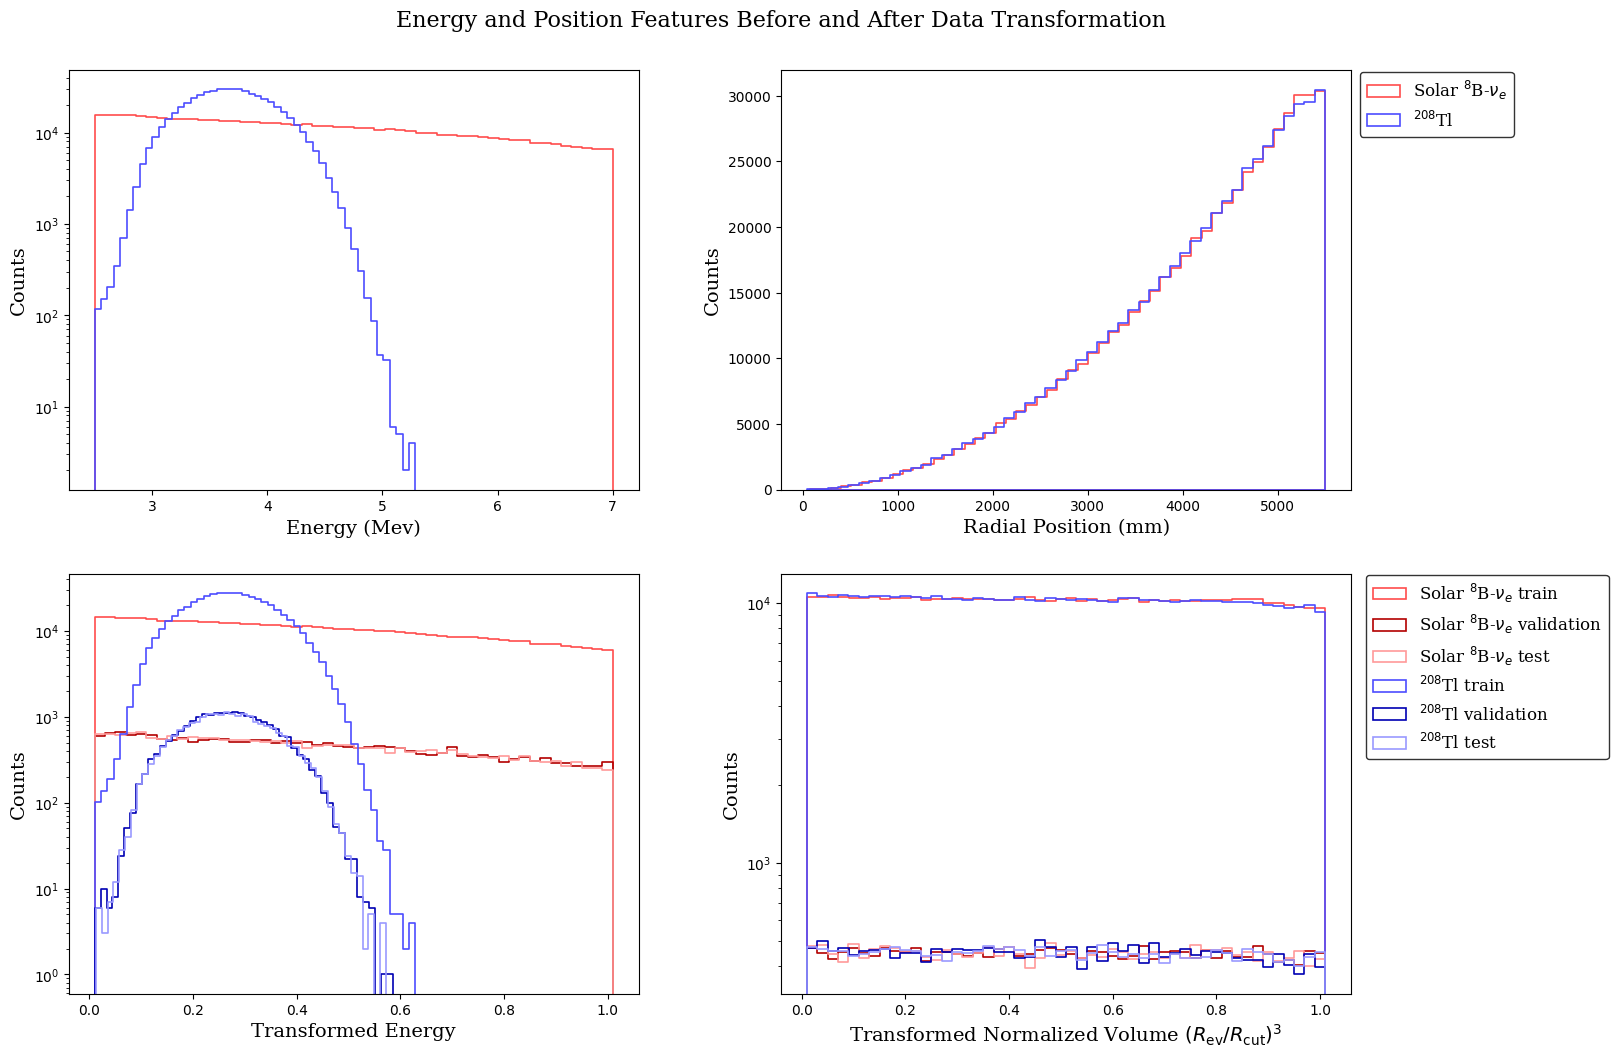

In [17]:
# Save Settings:
save_fig = False
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = f'Energy_Radius_Features_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ========= Plots Settings ===================
#mpl.rcParams.update(mpl.rcParamsDefault)
sn.reset_orig


# Font settings:
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':16}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':14}
font_prop = font_manager.FontProperties(family=font_style_axis['family'], weight=font_style_axis['weight'], size=12)

# Plot Representation settings:
linewidth = 1.2
alpha = 0

binwidth_en = 0.02
binwidth_rad = 0.1

bins = 50

# ========= Variables to plot lists =========
# non-transformed features:
energy_sig_tot = np.concatenate((df_energy_sig_train, df_energy_sig_test)).T[0]
energy_bkg_tot = np.concatenate((df_energy_bkg_train, df_energy_bkg_test)).T[0]

radius_sig_tot = np.concatenate((df_radi_sig_train, df_radi_sig_test)).T[0]
radius_bkg_tot = np.concatenate((df_radi_bkg_train, df_radi_bkg_test)).T[0]

energy_var_list = [energy_sig_tot, energy_bkg_tot]
radius_var_list = [radius_sig_tot, radius_bkg_tot]
labels_list = [r'Solar $^8$B-$\nu_e$', r'$^{208}$Tl']
colors_list = [red_variants[0], blue_variants[0]]

# Transformed features:
energy_transf_list = [energy_train_transf_sig, energy_val_transf_sig, energy_test1_transf_sig, 
                      energy_train_transf_bkg, energy_val_transf_bkg, energy_test1_transf_bkg]
radius_transf_list = [position_train_transf_sig, position_val_transf_sig, position_test1_transf_sig,
                      position_train_transf_bkg, position_val_transf_bkg, position_test1_transf_bkg]
lables_dataset_split_list = [r'Solar $^8$B-$\nu_e$ train', r'Solar $^8$B-$\nu_e$ validation', r'Solar $^8$B-$\nu_e$ test',
                             r'$^{208}$Tl train', r'$^{208}$Tl validation', r'$^{208}$Tl test']
colors_dataset_split_list = [red_variants[0], red_variants[1], red_variants[2],
                             blue_variants[0], blue_variants[1], blue_variants[2]]


# ========= Plots =========

fig, axes = plt.subplots(2, 2,
                         figsize=(19, 12),
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.25}  # (vertica space, horizontal space)
                        )

# ---------- Fila 1: Features no transformadas ----------
# Columna 1: Energía no transformada
ax = axes[0, 0]
for data, label, color in zip(energy_var_list, labels_list, colors_list):
    # To limit the shown plot using to the bin edges
    sn.histplot(data, bins = bins, label=label, ax = ax, color = color,
                alpha = alpha, element = 'step', linewidth = linewidth)
ax.set_xlabel("Energy (Mev)", fontdict = font_style_axis)
ax.set_ylabel(r'Counts', fontdict = font_style_axis)
ax.set_yscale('log')
#ax.legend()

# Columna 2: Posición (radio) no transformada
ax = axes[0, 1]
for data, label, color in zip(radius_var_list, labels_list, colors_list):
    sn.histplot(data, bins = bins, label=label, ax = ax, color = color, 
                alpha = alpha, element = 'step', linewidth = linewidth)
ax.set_xlabel("Radial Position (mm)", fontdict = font_style_axis)
ax.set_ylabel(r'Counts', fontdict = font_style_axis)
#ax.set_yscale('log')
#ax.legend()

# ---------- Fila 2: Features transformadas ----------
# Columna 1: Energía transformada
ax = axes[1, 0]
for data, label, color in zip(energy_transf_list, lables_dataset_split_list, colors_dataset_split_list):
    sn.histplot(data, bins = bins, label=label, ax = ax, color = color, 
                alpha = alpha, element = 'step', linewidth = linewidth)
ax.set_xlabel("Transformed Energy", fontdict = font_style_axis)
ax.set_ylabel(r'Counts', fontdict = font_style_axis)
ax.set_yscale('log')
#ax.legend()

# Columna 2: Posición transformada
ax = axes[1, 1]
for data, label, color in zip(radius_transf_list, lables_dataset_split_list, colors_dataset_split_list):
    sn.histplot(data, bins = bins, label=label, ax = ax, color = color, 
                alpha = alpha, element = 'step', linewidth = linewidth)
ax.set_xlabel(r'Transformed Normalized Volume $(R_\text{ev}/R_\text{cut})^{3}$', fontdict = font_style_axis)
ax.set_ylabel(r'Counts', fontdict = font_style_axis)
ax.set_yscale('log')
#ax.legend()

# ========= Crear leyendas únicas =========
# Leyenda para la primera fila (fuera de los plots)
handles_row1, labels_row1 = axes[0, 0].get_legend_handles_labels()
fig.legend(handles_row1, labels_row1,
           loc='upper right', bbox_to_anchor=(0.89, 0.885),
           prop=font_prop, frameon=True, edgecolor='black', labelcolor = font_style_axis['color'])
# Adjunts the plot size to left space to the legend box 
fig.subplots_adjust(right = 1.2)  # right space

# Leyenda para la segunda fila (fuera de los plots)
handles_row2, labels_row2 = axes[1, 0].get_legend_handles_labels()
fig.legend(handles_row2, labels_row2,
           loc='upper right', bbox_to_anchor=(0.94, 0.466),
           prop=font_prop, frameon=True, edgecolor='black', labelcolor = font_style_axis['color'])

# Adjunts the plot size to left space to the legend box 
fig.subplots_adjust(right = 0.80) # Plots contraction to right space

plt.suptitle(rf'Energy and Position Features Before and After Data Transformation', y = 0.93,
             family = 'serif', weight = 'normal', color = 'black', size = 16)

if save_fig:
    plt.savefig(save_dir + fname + pattern_train_save_name + '.png', format = 'png' , dpi=300, bbox_inches='tight')

plt.show()

### Train $\mathcal{L}(\Delta, \alpha)$ Plot

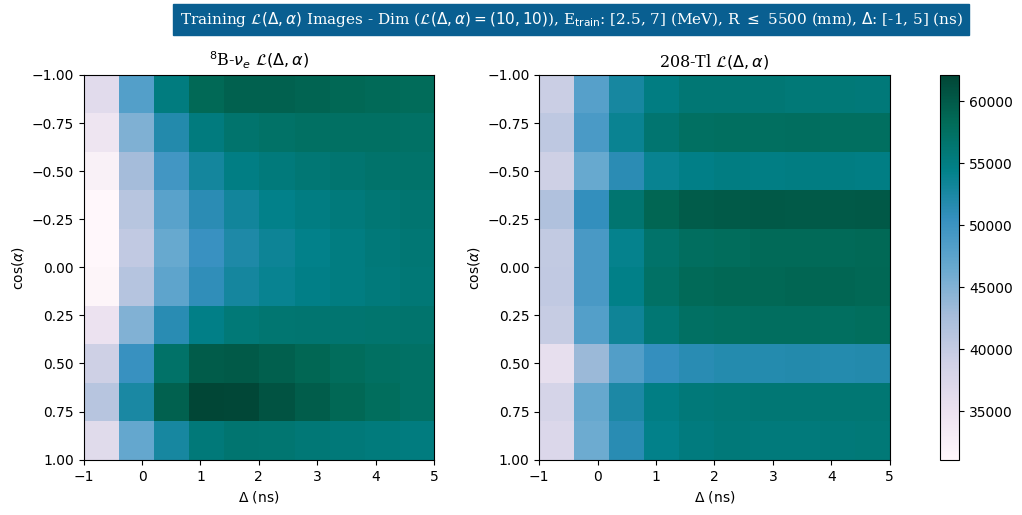

In [78]:
# --- Extract the Data ---
high_stat_L_sig = np.sum(pixel_train_transf_sig, axis = 0).reshape(10,10)
high_stat_L_bkg = np.sum(pixel_train_transf_bkg, axis = 0).reshape(10,10)

# Common normalization:

vmin = min(high_stat_L_sig.min(), high_stat_L_bkg.min())
vmax = max(high_stat_L_sig.max(), high_stat_L_bkg.max())

# -------- Plot Setting --------
sn.reset_orig

# Save Settings:
save_fig = True
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = f'L_delta_alpha_train_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'


# Font settings:
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':11.5}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':14}
font_prop = font_manager.FontProperties(family=font_style_axis['family'], weight=font_style_axis['weight'], size=10)

# Superior Title 
main_title = r'Training $\mathcal{L}(\Delta, \alpha)$ Images - '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut_train}] (MeV), R $\leq$ {posr_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + train_cut_title



fig, axes = plt.subplots(1, 2, figsize=(13, 5),
                         gridspec_kw={'hspace': 0.15, 'wspace': 0.30}  # (vertical space, horizontal space)
                        )

im0 = axes[0].imshow(high_stat_L_sig, cmap = cm.PuBuGn, extent = [time_res_inf_cut, time_res_sup_cut, 1, -1], aspect = 'auto', vmin=vmin, vmax=vmax)
im1 = axes[1].imshow(high_stat_L_bkg, cmap = cm.PuBuGn, extent = [time_res_inf_cut, time_res_sup_cut, 1, -1], aspect = 'auto', vmin=vmin, vmax=vmax)

#Color bar
cbar = fig.colorbar(im0, ax=axes)
cbar.set_label("")

axes[0].set_xlabel(r'$\Delta$ (ns)')
axes[0].set_ylabel(r'cos($\alpha$)')
axes[0].set_title(r'$^8$B-$\nu_e$ $\mathcal{L}(\Delta,\alpha)$', fontdict = font_style_title)

axes[1].set_xlabel(r'$\Delta$ (ns)')
axes[1].set_ylabel(r'cos($\alpha$)')
axes[1].set_title(r'208-Tl $\mathcal{L}(\Delta,\alpha)$', fontdict = font_style_title)

plt.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=11, weight='normal', y=1.01)

if save_fig:
    plt.savefig(save_dir + fname + pattern_train_save_name + '.png', format = 'png' , dpi=300, bbox_inches='tight')

plt.show()

## Initial Weights Suggestions

Use the flatten High Stat. Norm$[\mathcal{L}(\Delta,\alpha)]$ distribution as initial weights

In [21]:
initial_pixel_weights = np.sum(pixel_train_transf_sig, axis = 0)

#Normalize the weights values by the maximum value and then multiply by a factor < 1
reducer_factor = 0.2
initial_pixel_weights = (initial_pixel_weights/np.max(initial_pixel_weights)) * reducer_factor

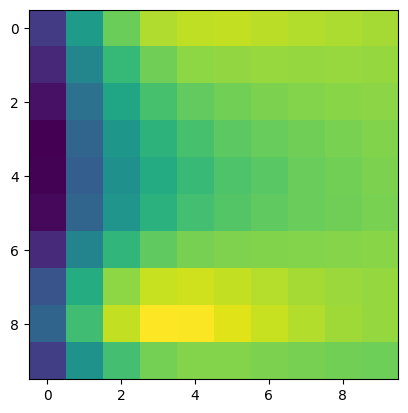

In [22]:
import matplotlib as mpl
sn.reset_orig
mpl.rcParams.update(mpl.rcParamsDefault)

plt.imshow(initial_pixel_weights.reshape(10,10))
plt.show()

### Weight Intializar: Keras Initializer

In [87]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom", name="PixelHintInitializer")
class PixelHintInitializer(tf.keras.initializers.Initializer):
    def __init__(self, weights_hint):
        self.weights_hint = np.array(weights_hint)

    def __call__(self, shape, dtype=None):
        W = np.tile(self.weights_hint.reshape(-1, 1), (1, shape[1]))
        return tf.convert_to_tensor(W, dtype=dtype)

    def get_config(self):
        return {"weights_hint": self.weights_hint.tolist()}

# Model Optimization

## Vary of Nº of Layers, Nº of Neurons, LR and Drop-out Rate.

In [17]:
def create_OP_Model(trial, weights_hint = None):
    # clear the Keras Session
    tf.keras.backend.clear_session()

    # Adam Optimizer Hyperparams
    lr_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3)
    
    # Dropout rate
    do_rate = trial.suggest_float('Drop_out_rate', 0.1, 0.7)

    # Image Dimensions
    image_dim = (10, 10)
    input_im_shape = image_dim[0] * image_dim[1]

    # Input Layers
    input_image = Input(shape=(input_im_shape,), name='image_input')
    input_energy = Input(shape=(1,), name='energy_input')
    input_position = Input(shape=(1,), name='position_input')

    # =======================
    # Image Model Branch
    # =======================
    n_layers_image = trial.suggest_int('n_layers_image', 1, 5)
    x_img = input_image
    image_layer_ranges = [(85, 95), (70, 80), (65, 75), (50, 60), (30, 45)]  #List with len = max(value_n_layers_suggest) where each entry is a tuple (min_suggest_neurons, max_suggest_neurons)

    for i in range(n_layers_image):
        n_units = trial.suggest_int(f'n_neurons_image_hidden_ly{i}', image_layer_ranges[i][0], image_layer_ranges[i][1])
        
        if i == 0 and weights_hint is not None:
            # Custom weights initialization function in the first hidden layer
            x_img = Dense(n_units, activation='gelu', kernel_initializer = PixelHintInitializer(weights_hint), name=f'imag_ly_{i}')(x_img)
        else:
            x_img = Dense(n_units, activation='gelu', name=f'imag_ly_{i}')(x_img)
            
    '''
    for i in range(n_layers_image):
        n_units = trial.suggest_int(f'n_neurons_image_hidden_ly{i}', image_layer_ranges[i][0], image_layer_ranges[i][1])
        x_img = Dense(n_units, activation='gelu', name=f'imag_ly_{i}')(x_img)
    '''
    
    # Concatenate Layer
    x = concatenate([x_img, input_energy, input_position])

    # =======================
    # Before DropOut (BDO) Model Branch
    # =======================
    n_layers_bdo = trial.suggest_int('n_layers_bdo', 1, 3)
    bdo_layer_ranges = [(26, 47), (22, 24), (18, 20)]
    x_bdo = x
    for i in range(n_layers_bdo):
        n_units = trial.suggest_int(f'n_neurons_bdo_hidden_ly{i}', bdo_layer_ranges[i][0], bdo_layer_ranges[i][1])
        x_bdo = Dense(n_units, activation='gelu', name=f'bdo_ly_{i}')(x_bdo)

    # Dropout
    x_bdo = Dropout(rate=do_rate)(x_bdo)

    # =======================
    # After DropOut (ADO) Model Branch
    # =======================
    n_layers_ado = trial.suggest_int('n_layers_ado', 1, 3)
    ado_layer_ranges = [(12, 16), (8, 10), (5, 7)] 
    x_ado = x_bdo
    for i in range(n_layers_ado):
        n_units = trial.suggest_int(f'n_neurons_ado_hidden_ly{i}', ado_layer_ranges[i][0], ado_layer_ranges[i][1])
        x_ado = Dense(n_units, activation='gelu', name=f'ado_ly_{i}')(x_ado)

    # Output Layer
    output_layer = Dense(2, activation='sigmoid', name='nu_predict')(x_ado)

    # Model Compilation ----------------------------------------------------------------------
    model = Model(inputs=[input_image, input_energy, input_position], outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.AUC(curve='ROC', name='roc_auc'),
                           tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
                           'accuracy'])

    return model

In [22]:
# ========= OPTUNA Model Optimization ===============
def objective(trial):
    
    global best_model_overall, best_score_overall
    
    model = create_OP_Model(trial, weights_hint = initial_pixel_weights)

    # Trainning
    history = model.fit(
        x = {'image_input': pixel_train_transf, 'energy_input': energy_train_transf, 'position_input': position_train_transf}, 
        y = {'nu_predict': labels_train}, 
        epochs = 200, 
        batch_size = 1000,
        validation_data = ([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
        callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, min_delta=1e-3, monitor="val_loss")],
        shuffle = True,
        verbose = 1
    )

    # Validation Predictions for signal events (better to evaluate the Precision-Recall AUC)
    model_predictions = model.predict([pixel_val_transf, energy_val_transf, position_val_transf], verbose=0)
    expected_labels = labels_val

    # Compute Precision-Recall AUC for signal
    precision, recall, _ = precision_recall_curve(expected_labels.flatten(), model_predictions.flatten())
    pr_auc_val = auc(recall, precision)

    return pr_auc_val

In [23]:
study = optuna.create_study(directions = ["maximize"])
study.optimize(objective, n_trials = 100)
best_trial = study.best_trial

# Print the best Model Results
print("Best Hyperparms.:", study.best_trial.params)
print("Best PR-AUC Value: ", best_trial.value)

[I 2025-08-15 01:05:09,139] A new study created in memory with name: no-name-2f58c125-dd2d-4845-b601-8cf7f225a979



Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7048 - loss: 0.5374 - pr_auc: 0.7875 - roc_auc: 0.7826 - val_accuracy: 0.7985 - val_loss: 0.4215 - val_pr_auc: 0.8872 - val_roc_auc: 0.8834
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7902 - loss: 0.4383 - pr_auc: 0.8755 - roc_auc: 0.8723 - val_accuracy: 0.8010 - val_loss: 0.4112 - val_pr_auc: 0.8928 - val_roc_auc: 0.8889
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7950 - loss: 0.4281 - pr_auc: 0.8822 - roc_auc: 0.8787 - val_accuracy: 0.8035 - val_loss: 0.4059 - val_pr_auc: 0.8958 - val_roc_auc: 0.8918
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7968 - loss: 0.4226 - pr_auc: 0.8859 - roc_auc: 0.8823 - val_accuracy: 0.8035 - val_loss: 0.4037 - val_pr_auc: 0.8976 - val_roc_auc: 0.8935
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7985 - loss: 0.4201 - pr_auc: 0.8879 - roc_auc: 0.8843 - val_accuracy: 0.7982 - val_loss: 0.41

[I 2025-08-15 01:07:25,204] Trial 0 finished with value: 0.839349264420012 and parameters: {'learning_rate': 0.003827708548243023, 'Drop_out_rate': 0.6126846927426564, 'n_layers_image': 5, 'n_neurons_image_hidden_ly0': 95, 'n_neurons_image_hidden_ly1': 70, 'n_neurons_image_hidden_ly2': 73, 'n_neurons_image_hidden_ly3': 56, 'n_neurons_image_hidden_ly4': 45, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 26, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 15}. Best is trial 0 with value: 0.839349264420012.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7157 - loss: 0.5233 - pr_auc: 0.8000 - roc_auc: 0.7953 - val_accuracy: 0.7906 - val_loss: 0.4266 - val_pr_auc: 0.8836 - val_roc_auc: 0.8789
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7914 - loss: 0.4295 - pr_auc: 0.8810 - roc_auc: 0.8769 - val_accuracy: 0.7991 - val_loss: 0.4122 - val_pr_auc: 0.8921 - val_roc_auc: 0.8878
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7969 - loss: 0.4192 - pr_auc: 0.8876 - roc_auc: 0.8836 - val_accuracy: 0.8011 - val_loss: 0.4077 - val_pr_auc: 0.8949 - val_roc_auc: 0.8907
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7995 - loss: 0.4131 - pr_auc: 0.8914 - roc_auc: 0.8875 - val_accuracy: 0.8028 - val_loss: 0.4028 - val_pr_auc: 0.8976 - val_roc_auc: 0.8933
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8014 - loss: 0.4084 - pr_auc: 0.8943 - roc_auc: 0.8902 - val_accuracy: 0.8023 - val_loss: 0.404

[I 2025-08-15 01:09:01,298] Trial 1 finished with value: 0.8749663983492811 and parameters: {'learning_rate': 0.0035181304517478383, 'Drop_out_rate': 0.401066319672587, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 85, 'n_neurons_image_hidden_ly1': 73, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 35, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 9}. Best is trial 1 with value: 0.8749663983492811.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6809 - loss: 0.5688 - pr_auc: 0.7549 - roc_auc: 0.7499 - val_accuracy: 0.7921 - val_loss: 0.4392 - val_pr_auc: 0.8741 - val_roc_auc: 0.8712
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7852 - loss: 0.4498 - pr_auc: 0.8681 - roc_auc: 0.8656 - val_accuracy: 0.7955 - val_loss: 0.4252 - val_pr_auc: 0.8849 - val_roc_auc: 0.8816
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7899 - loss: 0.4380 - pr_auc: 0.8759 - roc_auc: 0.8731 - val_accuracy: 0.7953 - val_loss: 0.4212 - val_pr_auc: 0.8880 - val_roc_auc: 0.8841
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7921 - loss: 0.4323 - pr_auc: 0.8797 - roc_auc: 0.8764 - val_accuracy: 0.7942 - val_loss: 0.4215 - val_pr_auc: 0.8881 - val_roc_auc: 0.8838
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7948 - loss: 0.4264 - pr_auc: 0.8836 - roc_auc: 0.8801 - val_accuracy: 0.7983 - val_loss: 0.414

[I 2025-08-15 01:11:41,431] Trial 2 finished with value: 0.8999597191146926 and parameters: {'learning_rate': 0.0011366031088355778, 'Drop_out_rate': 0.44447779662580156, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 90, 'n_neurons_image_hidden_ly1': 79, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 32, 'n_neurons_bdo_hidden_ly1': 22, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 13, 'n_neurons_ado_hidden_ly1': 9}. Best is trial 2 with value: 0.8999597191146926.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5996 - loss: 0.6551 - pr_auc: 0.6371 - roc_auc: 0.6421 - val_accuracy: 0.6615 - val_loss: 0.5750 - val_pr_auc: 0.7618 - val_roc_auc: 0.7476
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6905 - loss: 0.5662 - pr_auc: 0.7700 - roc_auc: 0.7665 - val_accuracy: 0.7520 - val_loss: 0.4905 - val_pr_auc: 0.8447 - val_roc_auc: 0.8383
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7543 - loss: 0.4790 - pr_auc: 0.8479 - roc_auc: 0.8423 - val_accuracy: 0.7665 - val_loss: 0.4521 - val_pr_auc: 0.8678 - val_roc_auc: 0.8607
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7800 - loss: 0.4503 - pr_auc: 0.8679 - roc_auc: 0.8640 - val_accuracy: 0.7610 - val_loss: 0.4564 - val_pr_auc: 0.8624 - val_roc_auc: 0.8553
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7850 - loss: 0.4437 - pr_auc: 0.8725 - roc_auc: 0.8689 - val_accuracy: 0.7362 - val_loss: 0.486

[I 2025-08-15 01:13:31,913] Trial 3 finished with value: 0.8303877743172314 and parameters: {'learning_rate': 0.00038022856603362907, 'Drop_out_rate': 0.4863534868777658, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 89, 'n_neurons_image_hidden_ly1': 76, 'n_neurons_image_hidden_ly2': 65, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 27, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 9}. Best is trial 2 with value: 0.8999597191146926.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7042 - loss: 0.5388 - pr_auc: 0.7862 - roc_auc: 0.7812 - val_accuracy: 0.7950 - val_loss: 0.4313 - val_pr_auc: 0.8809 - val_roc_auc: 0.8776
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7845 - loss: 0.4487 - pr_auc: 0.8687 - roc_auc: 0.8657 - val_accuracy: 0.7963 - val_loss: 0.4221 - val_pr_auc: 0.8872 - val_roc_auc: 0.8833
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7912 - loss: 0.4340 - pr_auc: 0.8787 - roc_auc: 0.8753 - val_accuracy: 0.8001 - val_loss: 0.4137 - val_pr_auc: 0.8922 - val_roc_auc: 0.8880
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7949 - loss: 0.4248 - pr_auc: 0.8848 - roc_auc: 0.8812 - val_accuracy: 0.8027 - val_loss: 0.4087 - val_pr_auc: 0.8944 - val_roc_auc: 0.8904
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7981 - loss: 0.4190 - pr_auc: 0.8884 - roc_auc: 0.8848 - val_accuracy: 0.8033 - val_loss: 0.405

[I 2025-08-15 01:16:15,308] Trial 4 finished with value: 0.9030563106586238 and parameters: {'learning_rate': 0.002224607355302504, 'Drop_out_rate': 0.5278691792182358, 'n_layers_image': 4, 'n_neurons_image_hidden_ly0': 87, 'n_neurons_image_hidden_ly1': 77, 'n_neurons_image_hidden_ly2': 68, 'n_neurons_image_hidden_ly3': 50, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 36, 'n_neurons_bdo_hidden_ly1': 24, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 13}. Best is trial 4 with value: 0.9030563106586238.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6271 - loss: 0.6153 - pr_auc: 0.6923 - roc_auc: 0.6860 - val_accuracy: 0.7828 - val_loss: 0.4687 - val_pr_auc: 0.8683 - val_roc_auc: 0.8646
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7707 - loss: 0.4628 - pr_auc: 0.8586 - roc_auc: 0.8545 - val_accuracy: 0.7931 - val_loss: 0.4376 - val_pr_auc: 0.8829 - val_roc_auc: 0.8786
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7835 - loss: 0.4469 - pr_auc: 0.8693 - roc_auc: 0.8655 - val_accuracy: 0.7949 - val_loss: 0.4354 - val_pr_auc: 0.8845 - val_roc_auc: 0.8803
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7864 - loss: 0.4427 - pr_auc: 0.8721 - roc_auc: 0.8683 - val_accuracy: 0.7882 - val_loss: 0.4498 - val_pr_auc: 0.8799 - val_roc_auc: 0.8755
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7870 - loss: 0.4403 - pr_auc: 0.8738 - roc_auc: 0.8698 - val_accuracy: 0.7720 - val_loss: 0.464

[I 2025-08-15 01:17:34,759] Trial 5 finished with value: 0.8555497867520645 and parameters: {'learning_rate': 0.0006884064762539119, 'Drop_out_rate': 0.5253296900388843, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 39, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 12, 'n_neurons_ado_hidden_ly1': 10, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 4 with value: 0.9030563106586238.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7342 - loss: 0.5027 - pr_auc: 0.8211 - roc_auc: 0.8152 - val_accuracy: 0.7956 - val_loss: 0.4237 - val_pr_auc: 0.8863 - val_roc_auc: 0.8827
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7946 - loss: 0.4272 - pr_auc: 0.8831 - roc_auc: 0.8796 - val_accuracy: 0.7959 - val_loss: 0.4199 - val_pr_auc: 0.8911 - val_roc_auc: 0.8869
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7982 - loss: 0.4170 - pr_auc: 0.8894 - roc_auc: 0.8856 - val_accuracy: 0.8045 - val_loss: 0.4052 - val_pr_auc: 0.8978 - val_roc_auc: 0.8937
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8000 - loss: 0.4116 - pr_auc: 0.8927 - roc_auc: 0.8887 - val_accuracy: 0.8042 - val_loss: 0.4013 - val_pr_auc: 0.8988 - val_roc_auc: 0.8944
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8018 - loss: 0.4077 - pr_auc: 0.8949 - roc_auc: 0.8909 - val_accuracy: 0.8055 - val_loss: 0.399

[I 2025-08-15 01:20:11,897] Trial 6 finished with value: 0.8933284975197939 and parameters: {'learning_rate': 0.004724375181148808, 'Drop_out_rate': 0.48290510068676973, 'n_layers_image': 4, 'n_neurons_image_hidden_ly0': 88, 'n_neurons_image_hidden_ly1': 73, 'n_neurons_image_hidden_ly2': 70, 'n_neurons_image_hidden_ly3': 59, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 45, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 10, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 4 with value: 0.9030563106586238.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7155 - loss: 0.5205 - pr_auc: 0.8009 - roc_auc: 0.7952 - val_accuracy: 0.7971 - val_loss: 0.4207 - val_pr_auc: 0.8885 - val_roc_auc: 0.8841
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7934 - loss: 0.4311 - pr_auc: 0.8801 - roc_auc: 0.8765 - val_accuracy: 0.7988 - val_loss: 0.4138 - val_pr_auc: 0.8915 - val_roc_auc: 0.8872
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7976 - loss: 0.4213 - pr_auc: 0.8865 - roc_auc: 0.8829 - val_accuracy: 0.7993 - val_loss: 0.4102 - val_pr_auc: 0.8948 - val_roc_auc: 0.8902
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7994 - loss: 0.4159 - pr_auc: 0.8899 - roc_auc: 0.8862 - val_accuracy: 0.8019 - val_loss: 0.4088 - val_pr_auc: 0.8947 - val_roc_auc: 0.8905
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8014 - loss: 0.4119 - pr_auc: 0.8923 - roc_auc: 0.8886 - val_accuracy: 0.7836 - val_loss: 0.433

[I 2025-08-15 01:22:03,697] Trial 7 finished with value: 0.9044373075828455 and parameters: {'learning_rate': 0.003820607177463289, 'Drop_out_rate': 0.5762180503481734, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 94, 'n_neurons_image_hidden_ly1': 77, 'n_neurons_image_hidden_ly2': 66, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 40, 'n_neurons_bdo_hidden_ly1': 24, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 10}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6658 - loss: 0.5855 - pr_auc: 0.7371 - roc_auc: 0.7347 - val_accuracy: 0.7936 - val_loss: 0.4306 - val_pr_auc: 0.8806 - val_roc_auc: 0.8770
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7873 - loss: 0.4392 - pr_auc: 0.8751 - roc_auc: 0.8714 - val_accuracy: 0.7976 - val_loss: 0.4204 - val_pr_auc: 0.8879 - val_roc_auc: 0.8839
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7933 - loss: 0.4292 - pr_auc: 0.8816 - roc_auc: 0.8780 - val_accuracy: 0.7976 - val_loss: 0.4169 - val_pr_auc: 0.8899 - val_roc_auc: 0.8859
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7947 - loss: 0.4249 - pr_auc: 0.8842 - roc_auc: 0.8803 - val_accuracy: 0.8013 - val_loss: 0.4088 - val_pr_auc: 0.8943 - val_roc_auc: 0.8902
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7978 - loss: 0.4191 - pr_auc: 0.8878 - roc_auc: 0.8840 - val_accuracy: 0.7991 - val_loss: 0.411

[I 2025-08-15 01:26:22,536] Trial 8 finished with value: 0.8862799956498306 and parameters: {'learning_rate': 0.0009500990639364673, 'Drop_out_rate': 0.4926114882090268, 'n_layers_image': 4, 'n_neurons_image_hidden_ly0': 88, 'n_neurons_image_hidden_ly1': 70, 'n_neurons_image_hidden_ly2': 65, 'n_neurons_image_hidden_ly3': 57, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 35, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 10}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7299 - loss: 0.5167 - pr_auc: 0.8055 - roc_auc: 0.8048 - val_accuracy: 0.7982 - val_loss: 0.4200 - val_pr_auc: 0.8891 - val_roc_auc: 0.8850
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7903 - loss: 0.4375 - pr_auc: 0.8759 - roc_auc: 0.8725 - val_accuracy: 0.7782 - val_loss: 0.4504 - val_pr_auc: 0.8780 - val_roc_auc: 0.8729
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7945 - loss: 0.4268 - pr_auc: 0.8832 - roc_auc: 0.8795 - val_accuracy: 0.7602 - val_loss: 0.4659 - val_pr_auc: 0.8657 - val_roc_auc: 0.8598
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7967 - loss: 0.4187 - pr_auc: 0.8883 - roc_auc: 0.8844 - val_accuracy: 0.7505 - val_loss: 0.4780 - val_pr_auc: 0.8586 - val_roc_auc: 0.8517
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7987 - loss: 0.4137 - pr_auc: 0.8913 - roc_auc: 0.8873 - val_accuracy: 0.7865 - val_loss: 0.442

[I 2025-08-15 01:28:22,641] Trial 9 finished with value: 0.8467003907866508 and parameters: {'learning_rate': 0.004972441745604967, 'Drop_out_rate': 0.660068637577, 'n_layers_image': 5, 'n_neurons_image_hidden_ly0': 89, 'n_neurons_image_hidden_ly1': 70, 'n_neurons_image_hidden_ly2': 71, 'n_neurons_image_hidden_ly3': 51, 'n_neurons_image_hidden_ly4': 44, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 29, 'n_neurons_bdo_hidden_ly1': 23, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7141 - loss: 0.5226 - pr_auc: 0.8010 - roc_auc: 0.7949 - val_accuracy: 0.7962 - val_loss: 0.4172 - val_pr_auc: 0.8893 - val_roc_auc: 0.8849
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7939 - loss: 0.4239 - pr_auc: 0.8847 - roc_auc: 0.8806 - val_accuracy: 0.7990 - val_loss: 0.4111 - val_pr_auc: 0.8928 - val_roc_auc: 0.8884
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7985 - loss: 0.4159 - pr_auc: 0.8896 - roc_auc: 0.8857 - val_accuracy: 0.8003 - val_loss: 0.4142 - val_pr_auc: 0.8929 - val_roc_auc: 0.8887
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8009 - loss: 0.4105 - pr_auc: 0.8930 - roc_auc: 0.8890 - val_accuracy: 0.8020 - val_loss: 0.4054 - val_pr_auc: 0.8967 - val_roc_auc: 0.8924
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8012 - loss: 0.4095 - pr_auc: 0.8936 - roc_auc: 0.8896 - val_accuracy: 0.8061 - val_loss: 0.399

[I 2025-08-15 01:31:22,946] Trial 10 finished with value: 0.9023839954102597 and parameters: {'learning_rate': 0.002725265783926948, 'Drop_out_rate': 0.25880108048112327, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 93, 'n_neurons_image_hidden_ly1': 80, 'n_neurons_image_hidden_ly2': 68, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 24, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 15}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7225 - loss: 0.5158 - pr_auc: 0.8084 - roc_auc: 0.8028 - val_accuracy: 0.7963 - val_loss: 0.4173 - val_pr_auc: 0.8892 - val_roc_auc: 0.8848
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7931 - loss: 0.4262 - pr_auc: 0.8831 - roc_auc: 0.8790 - val_accuracy: 0.7969 - val_loss: 0.4184 - val_pr_auc: 0.8889 - val_roc_auc: 0.8846
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7940 - loss: 0.4225 - pr_auc: 0.8854 - roc_auc: 0.8813 - val_accuracy: 0.8004 - val_loss: 0.4107 - val_pr_auc: 0.8934 - val_roc_auc: 0.8891
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7976 - loss: 0.4163 - pr_auc: 0.8894 - roc_auc: 0.8853 - val_accuracy: 0.8032 - val_loss: 0.4039 - val_pr_auc: 0.8969 - val_roc_auc: 0.8927
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7998 - loss: 0.4124 - pr_auc: 0.8917 - roc_auc: 0.8877 - val_accuracy: 0.8046 - val_loss: 0.403

[I 2025-08-15 01:35:33,629] Trial 11 finished with value: 0.8966809142903815 and parameters: {'learning_rate': 0.0019856291500914432, 'Drop_out_rate': 0.27584729361938815, 'n_layers_image': 4, 'n_neurons_image_hidden_ly0': 92, 'n_neurons_image_hidden_ly1': 77, 'n_neurons_image_hidden_ly2': 68, 'n_neurons_image_hidden_ly3': 50, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 40, 'n_neurons_bdo_hidden_ly1': 24, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 13}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7104 - loss: 0.5294 - pr_auc: 0.7943 - roc_auc: 0.7890 - val_accuracy: 0.7929 - val_loss: 0.4252 - val_pr_auc: 0.8857 - val_roc_auc: 0.8813
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7873 - loss: 0.4396 - pr_auc: 0.8746 - roc_auc: 0.8707 - val_accuracy: 0.7865 - val_loss: 0.4298 - val_pr_auc: 0.8828 - val_roc_auc: 0.8782
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7925 - loss: 0.4277 - pr_auc: 0.8825 - roc_auc: 0.8787 - val_accuracy: 0.7943 - val_loss: 0.4186 - val_pr_auc: 0.8893 - val_roc_auc: 0.8849
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7956 - loss: 0.4211 - pr_auc: 0.8869 - roc_auc: 0.8831 - val_accuracy: 0.7986 - val_loss: 0.4098 - val_pr_auc: 0.8939 - val_roc_auc: 0.8895
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7978 - loss: 0.4169 - pr_auc: 0.8896 - roc_auc: 0.8858 - val_accuracy: 0.7942 - val_loss: 0.414

[I 2025-08-15 01:37:24,736] Trial 12 finished with value: 0.8730608638892216 and parameters: {'learning_rate': 0.0026633907190183313, 'Drop_out_rate': 0.5837205127212546, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 85, 'n_neurons_image_hidden_ly1': 78, 'n_neurons_image_hidden_ly2': 67, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 39, 'n_neurons_bdo_hidden_ly1': 24, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 13}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7095 - loss: 0.5286 - pr_auc: 0.7949 - roc_auc: 0.7886 - val_accuracy: 0.7989 - val_loss: 0.4174 - val_pr_auc: 0.8898 - val_roc_auc: 0.8855
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7929 - loss: 0.4252 - pr_auc: 0.8839 - roc_auc: 0.8798 - val_accuracy: 0.7978 - val_loss: 0.4143 - val_pr_auc: 0.8907 - val_roc_auc: 0.8864
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7958 - loss: 0.4193 - pr_auc: 0.8874 - roc_auc: 0.8833 - val_accuracy: 0.8004 - val_loss: 0.4105 - val_pr_auc: 0.8931 - val_roc_auc: 0.8889
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7986 - loss: 0.4139 - pr_auc: 0.8908 - roc_auc: 0.8867 - val_accuracy: 0.8035 - val_loss: 0.4062 - val_pr_auc: 0.8960 - val_roc_auc: 0.8919
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7998 - loss: 0.4110 - pr_auc: 0.8925 - roc_auc: 0.8883 - val_accuracy: 0.8047 - val_loss: 0.403

[I 2025-08-15 01:40:25,185] Trial 13 finished with value: 0.903409269657883 and parameters: {'learning_rate': 0.001859211688799735, 'Drop_out_rate': 0.12929139038856885, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 92, 'n_neurons_image_hidden_ly1': 74, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 47, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 20, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 12}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7141 - loss: 0.5189 - pr_auc: 0.8020 - roc_auc: 0.7957 - val_accuracy: 0.7944 - val_loss: 0.4194 - val_pr_auc: 0.8880 - val_roc_auc: 0.8836
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7951 - loss: 0.4206 - pr_auc: 0.8865 - roc_auc: 0.8823 - val_accuracy: 0.7992 - val_loss: 0.4132 - val_pr_auc: 0.8916 - val_roc_auc: 0.8874
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8003 - loss: 0.4111 - pr_auc: 0.8924 - roc_auc: 0.8883 - val_accuracy: 0.8039 - val_loss: 0.4035 - val_pr_auc: 0.8974 - val_roc_auc: 0.8932
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8024 - loss: 0.4068 - pr_auc: 0.8950 - roc_auc: 0.8909 - val_accuracy: 0.8055 - val_loss: 0.4003 - val_pr_auc: 0.8989 - val_roc_auc: 0.8949
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8033 - loss: 0.4039 - pr_auc: 0.8967 - roc_auc: 0.8926 - val_accuracy: 0.8056 - val_loss: 0.398

[I 2025-08-15 01:42:31,585] Trial 14 finished with value: 0.9031175309339659 and parameters: {'learning_rate': 0.003584256809102434, 'Drop_out_rate': 0.1316673796663963, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 92, 'n_neurons_image_hidden_ly1': 74, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 47, 'n_neurons_bdo_hidden_ly1': 23, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 12, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6780 - loss: 0.5689 - pr_auc: 0.7534 - roc_auc: 0.7489 - val_accuracy: 0.7899 - val_loss: 0.4298 - val_pr_auc: 0.8822 - val_roc_auc: 0.8777
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7853 - loss: 0.4412 - pr_auc: 0.8737 - roc_auc: 0.8698 - val_accuracy: 0.7848 - val_loss: 0.4360 - val_pr_auc: 0.8772 - val_roc_auc: 0.8723
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7886 - loss: 0.4343 - pr_auc: 0.8781 - roc_auc: 0.8739 - val_accuracy: 0.7991 - val_loss: 0.4157 - val_pr_auc: 0.8900 - val_roc_auc: 0.8857
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7933 - loss: 0.4256 - pr_auc: 0.8836 - roc_auc: 0.8795 - val_accuracy: 0.7974 - val_loss: 0.4147 - val_pr_auc: 0.8913 - val_roc_auc: 0.8870
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7965 - loss: 0.4199 - pr_auc: 0.8872 - roc_auc: 0.8833 - val_accuracy: 0.8014 - val_loss: 0.408

[I 2025-08-15 01:44:31,904] Trial 15 finished with value: 0.9033346154953802 and parameters: {'learning_rate': 0.0016484880035872132, 'Drop_out_rate': 0.29550682134830747, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 92, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 23, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 14}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7319 - loss: 0.5037 - pr_auc: 0.8181 - roc_auc: 0.8129 - val_accuracy: 0.7978 - val_loss: 0.4169 - val_pr_auc: 0.8897 - val_roc_auc: 0.8853
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7944 - loss: 0.4223 - pr_auc: 0.8856 - roc_auc: 0.8814 - val_accuracy: 0.7989 - val_loss: 0.4116 - val_pr_auc: 0.8924 - val_roc_auc: 0.8881
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7998 - loss: 0.4120 - pr_auc: 0.8919 - roc_auc: 0.8877 - val_accuracy: 0.8025 - val_loss: 0.4107 - val_pr_auc: 0.8962 - val_roc_auc: 0.8918
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8017 - loss: 0.4069 - pr_auc: 0.8950 - roc_auc: 0.8908 - val_accuracy: 0.8070 - val_loss: 0.3969 - val_pr_auc: 0.9009 - val_roc_auc: 0.8968
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8040 - loss: 0.4028 - pr_auc: 0.8973 - roc_auc: 0.8933 - val_accuracy: 0.8068 - val_loss: 0.397

[I 2025-08-15 01:47:06,246] Trial 16 finished with value: 0.9041770553050302 and parameters: {'learning_rate': 0.004222492753987471, 'Drop_out_rate': 0.12957218225684722, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 95, 'n_neurons_image_hidden_ly1': 75, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 47, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 20, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 12, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6926 - loss: 0.5506 - pr_auc: 0.7720 - roc_auc: 0.7672 - val_accuracy: 0.7802 - val_loss: 0.4469 - val_pr_auc: 0.8699 - val_roc_auc: 0.8657
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7934 - loss: 0.4264 - pr_auc: 0.8829 - roc_auc: 0.8788 - val_accuracy: 0.8008 - val_loss: 0.4113 - val_pr_auc: 0.8925 - val_roc_auc: 0.8884
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7985 - loss: 0.4150 - pr_auc: 0.8902 - roc_auc: 0.8861 - val_accuracy: 0.8016 - val_loss: 0.4052 - val_pr_auc: 0.8966 - val_roc_auc: 0.8924
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8019 - loss: 0.4079 - pr_auc: 0.8945 - roc_auc: 0.8904 - val_accuracy: 0.8051 - val_loss: 0.4039 - val_pr_auc: 0.8988 - val_roc_auc: 0.8948
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8037 - loss: 0.4037 - pr_auc: 0.8968 - roc_auc: 0.8927 - val_accuracy: 0.8029 - val_loss: 0.402

[I 2025-08-15 01:49:12,871] Trial 17 finished with value: 0.9035730784527518 and parameters: {'learning_rate': 0.0041470173190426025, 'Drop_out_rate': 0.2070428298167659, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6985 - loss: 0.5365 - pr_auc: 0.7833 - roc_auc: 0.7770 - val_accuracy: 0.7983 - val_loss: 0.4155 - val_pr_auc: 0.8902 - val_roc_auc: 0.8859
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7946 - loss: 0.4245 - pr_auc: 0.8845 - roc_auc: 0.8806 - val_accuracy: 0.7935 - val_loss: 0.4237 - val_pr_auc: 0.8854 - val_roc_auc: 0.8811
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7977 - loss: 0.4181 - pr_auc: 0.8885 - roc_auc: 0.8846 - val_accuracy: 0.8042 - val_loss: 0.4034 - val_pr_auc: 0.8973 - val_roc_auc: 0.8930
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8006 - loss: 0.4124 - pr_auc: 0.8919 - roc_auc: 0.8880 - val_accuracy: 0.8055 - val_loss: 0.4015 - val_pr_auc: 0.8983 - val_roc_auc: 0.8942
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8013 - loss: 0.4092 - pr_auc: 0.8938 - roc_auc: 0.8898 - val_accuracy: 0.8066 - val_loss: 0.397

[I 2025-08-15 01:51:20,724] Trial 18 finished with value: 0.9034956777911589 and parameters: {'learning_rate': 0.0031125013980999546, 'Drop_out_rate': 0.35614430542006525, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 94, 'n_neurons_image_hidden_ly1': 75, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 32, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 20, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7181 - loss: 0.5226 - pr_auc: 0.8001 - roc_auc: 0.7954 - val_accuracy: 0.7943 - val_loss: 0.4292 - val_pr_auc: 0.8841 - val_roc_auc: 0.8803
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7890 - loss: 0.4431 - pr_auc: 0.8722 - roc_auc: 0.8691 - val_accuracy: 0.7965 - val_loss: 0.4209 - val_pr_auc: 0.8904 - val_roc_auc: 0.8862
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7932 - loss: 0.4335 - pr_auc: 0.8789 - roc_auc: 0.8756 - val_accuracy: 0.8004 - val_loss: 0.4120 - val_pr_auc: 0.8936 - val_roc_auc: 0.8895
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7964 - loss: 0.4253 - pr_auc: 0.8843 - roc_auc: 0.8808 - val_accuracy: 0.7951 - val_loss: 0.4178 - val_pr_auc: 0.8900 - val_roc_auc: 0.8856
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7980 - loss: 0.4181 - pr_auc: 0.8889 - roc_auc: 0.8852 - val_accuracy: 0.7859 - val_loss: 0.431

[I 2025-08-15 01:53:12,885] Trial 19 finished with value: 0.8876022292821727 and parameters: {'learning_rate': 0.004336909990338687, 'Drop_out_rate': 0.6837153667180944, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 94, 'n_neurons_image_hidden_ly1': 76, 'n_neurons_image_hidden_ly2': 75, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 24, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 12, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7073 - loss: 0.5285 - pr_auc: 0.7908 - roc_auc: 0.7860 - val_accuracy: 0.7966 - val_loss: 0.4186 - val_pr_auc: 0.8883 - val_roc_auc: 0.8840
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7936 - loss: 0.4260 - pr_auc: 0.8832 - roc_auc: 0.8792 - val_accuracy: 0.7988 - val_loss: 0.4161 - val_pr_auc: 0.8913 - val_roc_auc: 0.8868
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7987 - loss: 0.4147 - pr_auc: 0.8904 - roc_auc: 0.8864 - val_accuracy: 0.8035 - val_loss: 0.4062 - val_pr_auc: 0.8960 - val_roc_auc: 0.8918
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7999 - loss: 0.4113 - pr_auc: 0.8925 - roc_auc: 0.8884 - val_accuracy: 0.8036 - val_loss: 0.4033 - val_pr_auc: 0.8974 - val_roc_auc: 0.8933
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8019 - loss: 0.4065 - pr_auc: 0.8952 - roc_auc: 0.8911 - val_accuracy: 0.8045 - val_loss: 0.399

[I 2025-08-15 01:56:16,537] Trial 20 finished with value: 0.9030116762010202 and parameters: {'learning_rate': 0.003120165707402621, 'Drop_out_rate': 0.3424176753942274, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 91, 'n_neurons_image_hidden_ly1': 72, 'n_neurons_image_hidden_ly2': 71, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 38, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 20, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 10, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6872 - loss: 0.5521 - pr_auc: 0.7686 - roc_auc: 0.7632 - val_accuracy: 0.7966 - val_loss: 0.4194 - val_pr_auc: 0.8886 - val_roc_auc: 0.8842
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7934 - loss: 0.4256 - pr_auc: 0.8837 - roc_auc: 0.8795 - val_accuracy: 0.7982 - val_loss: 0.4161 - val_pr_auc: 0.8905 - val_roc_auc: 0.8863
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7986 - loss: 0.4144 - pr_auc: 0.8906 - roc_auc: 0.8865 - val_accuracy: 0.8039 - val_loss: 0.4069 - val_pr_auc: 0.8968 - val_roc_auc: 0.8927
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8023 - loss: 0.4074 - pr_auc: 0.8947 - roc_auc: 0.8906 - val_accuracy: 0.8058 - val_loss: 0.3987 - val_pr_auc: 0.9001 - val_roc_auc: 0.8959
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8035 - loss: 0.4039 - pr_auc: 0.8968 - roc_auc: 0.8926 - val_accuracy: 0.8055 - val_loss: 0.400

[I 2025-08-15 01:58:09,986] Trial 21 finished with value: 0.9028128502558261 and parameters: {'learning_rate': 0.004253322913062027, 'Drop_out_rate': 0.197600815947729, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 7 with value: 0.9044373075828455.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6725 - loss: 0.5712 - pr_auc: 0.7478 - roc_auc: 0.7426 - val_accuracy: 0.7807 - val_loss: 0.4427 - val_pr_auc: 0.8725 - val_roc_auc: 0.8679
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7891 - loss: 0.4306 - pr_auc: 0.8805 - roc_auc: 0.8761 - val_accuracy: 0.7951 - val_loss: 0.4233 - val_pr_auc: 0.8878 - val_roc_auc: 0.8834
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7954 - loss: 0.4187 - pr_auc: 0.8878 - roc_auc: 0.8835 - val_accuracy: 0.7991 - val_loss: 0.4153 - val_pr_auc: 0.8936 - val_roc_auc: 0.8891
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8005 - loss: 0.4093 - pr_auc: 0.8935 - roc_auc: 0.8892 - val_accuracy: 0.8032 - val_loss: 0.4018 - val_pr_auc: 0.8995 - val_roc_auc: 0.8953
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8022 - loss: 0.4059 - pr_auc: 0.8956 - roc_auc: 0.8914 - val_accuracy: 0.8065 - val_loss: 0.401

[I 2025-08-15 02:00:35,509] Trial 22 finished with value: 0.9045586920682717 and parameters: {'learning_rate': 0.004035755708877054, 'Drop_out_rate': 0.18089139209092142, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 22 with value: 0.9045586920682717.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7211 - loss: 0.5101 - pr_auc: 0.8100 - roc_auc: 0.8037 - val_accuracy: 0.7939 - val_loss: 0.4238 - val_pr_auc: 0.8860 - val_roc_auc: 0.8816
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7952 - loss: 0.4210 - pr_auc: 0.8864 - roc_auc: 0.8822 - val_accuracy: 0.7985 - val_loss: 0.4159 - val_pr_auc: 0.8920 - val_roc_auc: 0.8877
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8000 - loss: 0.4099 - pr_auc: 0.8931 - roc_auc: 0.8890 - val_accuracy: 0.8003 - val_loss: 0.4101 - val_pr_auc: 0.8946 - val_roc_auc: 0.8903
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8026 - loss: 0.4046 - pr_auc: 0.8962 - roc_auc: 0.8920 - val_accuracy: 0.8016 - val_loss: 0.4031 - val_pr_auc: 0.8977 - val_roc_auc: 0.8933
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8044 - loss: 0.4009 - pr_auc: 0.8983 - roc_auc: 0.8941 - val_accuracy: 0.8032 - val_loss: 0.400

[I 2025-08-15 02:03:14,443] Trial 23 finished with value: 0.9045094801074186 and parameters: {'learning_rate': 0.004495298708532346, 'Drop_out_rate': 0.10937471256170542, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 93, 'n_neurons_image_hidden_ly1': 78, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 22 with value: 0.9045586920682717.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6982 - loss: 0.5364 - pr_auc: 0.7830 - roc_auc: 0.7768 - val_accuracy: 0.7975 - val_loss: 0.4181 - val_pr_auc: 0.8885 - val_roc_auc: 0.8842
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7934 - loss: 0.4243 - pr_auc: 0.8843 - roc_auc: 0.8803 - val_accuracy: 0.8016 - val_loss: 0.4080 - val_pr_auc: 0.8945 - val_roc_auc: 0.8903
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7986 - loss: 0.4139 - pr_auc: 0.8908 - roc_auc: 0.8867 - val_accuracy: 0.7976 - val_loss: 0.4137 - val_pr_auc: 0.8917 - val_roc_auc: 0.8875
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8020 - loss: 0.4068 - pr_auc: 0.8950 - roc_auc: 0.8909 - val_accuracy: 0.8034 - val_loss: 0.4043 - val_pr_auc: 0.8973 - val_roc_auc: 0.8931
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8036 - loss: 0.4027 - pr_auc: 0.8974 - roc_auc: 0.8932 - val_accuracy: 0.8029 - val_loss: 0.402

[I 2025-08-15 02:05:09,265] Trial 24 finished with value: 0.9022218704468932 and parameters: {'learning_rate': 0.004719630878425211, 'Drop_out_rate': 0.22427306711131173, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 9}. Best is trial 22 with value: 0.9045586920682717.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7001 - loss: 0.5349 - pr_auc: 0.7853 - roc_auc: 0.7795 - val_accuracy: 0.7910 - val_loss: 0.4244 - val_pr_auc: 0.8852 - val_roc_auc: 0.8807
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7945 - loss: 0.4227 - pr_auc: 0.8853 - roc_auc: 0.8811 - val_accuracy: 0.8006 - val_loss: 0.4113 - val_pr_auc: 0.8924 - val_roc_auc: 0.8882
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7996 - loss: 0.4137 - pr_auc: 0.8909 - roc_auc: 0.8868 - val_accuracy: 0.8026 - val_loss: 0.4077 - val_pr_auc: 0.8946 - val_roc_auc: 0.8907
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8023 - loss: 0.4077 - pr_auc: 0.8945 - roc_auc: 0.8905 - val_accuracy: 0.8052 - val_loss: 0.4008 - val_pr_auc: 0.8986 - val_roc_auc: 0.8944
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8036 - loss: 0.4038 - pr_auc: 0.8968 - roc_auc: 0.8928 - val_accuracy: 0.8074 - val_loss: 0.394

[I 2025-08-15 02:07:14,580] Trial 25 finished with value: 0.9035387576476301 and parameters: {'learning_rate': 0.0038126263175453446, 'Drop_out_rate': 0.18614958666450968, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 93, 'n_neurons_image_hidden_ly1': 80, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 37, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 22 with value: 0.9045586920682717.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7022 - loss: 0.5423 - pr_auc: 0.7816 - roc_auc: 0.7775 - val_accuracy: 0.7915 - val_loss: 0.4302 - val_pr_auc: 0.8838 - val_roc_auc: 0.8798
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7913 - loss: 0.4310 - pr_auc: 0.8807 - roc_auc: 0.8772 - val_accuracy: 0.7980 - val_loss: 0.4178 - val_pr_auc: 0.8898 - val_roc_auc: 0.8857
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7965 - loss: 0.4204 - pr_auc: 0.8875 - roc_auc: 0.8836 - val_accuracy: 0.8015 - val_loss: 0.4098 - val_pr_auc: 0.8943 - val_roc_auc: 0.8900
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8005 - loss: 0.4118 - pr_auc: 0.8926 - roc_auc: 0.8886 - val_accuracy: 0.8016 - val_loss: 0.4062 - val_pr_auc: 0.8963 - val_roc_auc: 0.8921
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8019 - loss: 0.4071 - pr_auc: 0.8952 - roc_auc: 0.8911 - val_accuracy: 0.7999 - val_loss: 0.411

[I 2025-08-15 02:09:48,689] Trial 26 finished with value: 0.9044517093905392 and parameters: {'learning_rate': 0.0030325159544609902, 'Drop_out_rate': 0.10002291223049109, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 40, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 22 with value: 0.9045586920682717.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6691 - loss: 0.5785 - pr_auc: 0.7423 - roc_auc: 0.7360 - val_accuracy: 0.7729 - val_loss: 0.4525 - val_pr_auc: 0.8690 - val_roc_auc: 0.8646
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7876 - loss: 0.4427 - pr_auc: 0.8719 - roc_auc: 0.8690 - val_accuracy: 0.7916 - val_loss: 0.4291 - val_pr_auc: 0.8838 - val_roc_auc: 0.8793
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7947 - loss: 0.4245 - pr_auc: 0.8849 - roc_auc: 0.8814 - val_accuracy: 0.8002 - val_loss: 0.4145 - val_pr_auc: 0.8924 - val_roc_auc: 0.8884
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7997 - loss: 0.4136 - pr_auc: 0.8916 - roc_auc: 0.8877 - val_accuracy: 0.7972 - val_loss: 0.4138 - val_pr_auc: 0.8919 - val_roc_auc: 0.8875
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8019 - loss: 0.4083 - pr_auc: 0.8947 - roc_auc: 0.8907 - val_accuracy: 0.8043 - val_loss: 0.402

[I 2025-08-15 02:12:23,060] Trial 27 finished with value: 0.9051397166931748 and parameters: {'learning_rate': 0.0031800510408337827, 'Drop_out_rate': 0.10206054933109508, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 91, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7000 - loss: 0.5429 - pr_auc: 0.7820 - roc_auc: 0.7765 - val_accuracy: 0.7877 - val_loss: 0.4326 - val_pr_auc: 0.8792 - val_roc_auc: 0.8746
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7901 - loss: 0.4311 - pr_auc: 0.8800 - roc_auc: 0.8759 - val_accuracy: 0.7969 - val_loss: 0.4161 - val_pr_auc: 0.8901 - val_roc_auc: 0.8857
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7967 - loss: 0.4185 - pr_auc: 0.8880 - roc_auc: 0.8839 - val_accuracy: 0.8004 - val_loss: 0.4087 - val_pr_auc: 0.8942 - val_roc_auc: 0.8899
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8009 - loss: 0.4100 - pr_auc: 0.8933 - roc_auc: 0.8892 - val_accuracy: 0.8004 - val_loss: 0.4088 - val_pr_auc: 0.8941 - val_roc_auc: 0.8898
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8017 - loss: 0.4069 - pr_auc: 0.8950 - roc_auc: 0.8908 - val_accuracy: 0.8055 - val_loss: 0.399

[I 2025-08-15 02:15:04,529] Trial 28 finished with value: 0.903134373276352 and parameters: {'learning_rate': 0.0033705498224833987, 'Drop_out_rate': 0.16457712995968932, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 91, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6770 - loss: 0.5584 - pr_auc: 0.7564 - roc_auc: 0.7503 - val_accuracy: 0.7988 - val_loss: 0.4180 - val_pr_auc: 0.8895 - val_roc_auc: 0.8852
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7921 - loss: 0.4254 - pr_auc: 0.8840 - roc_auc: 0.8797 - val_accuracy: 0.7996 - val_loss: 0.4087 - val_pr_auc: 0.8944 - val_roc_auc: 0.8901
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7978 - loss: 0.4144 - pr_auc: 0.8906 - roc_auc: 0.8864 - val_accuracy: 0.8038 - val_loss: 0.4024 - val_pr_auc: 0.8977 - val_roc_auc: 0.8934
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8006 - loss: 0.4081 - pr_auc: 0.8943 - roc_auc: 0.8901 - val_accuracy: 0.8013 - val_loss: 0.4070 - val_pr_auc: 0.8959 - val_roc_auc: 0.8916
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8029 - loss: 0.4039 - pr_auc: 0.8968 - roc_auc: 0.8925 - val_accuracy: 0.8061 - val_loss: 0.397

[I 2025-08-15 02:17:01,580] Trial 29 finished with value: 0.9042901350947725 and parameters: {'learning_rate': 0.004598141658050569, 'Drop_out_rate': 0.16256141701864546, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 91, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 44, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7165 - loss: 0.5218 - pr_auc: 0.8010 - roc_auc: 0.7943 - val_accuracy: 0.7951 - val_loss: 0.4211 - val_pr_auc: 0.8864 - val_roc_auc: 0.8822
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7958 - loss: 0.4195 - pr_auc: 0.8873 - roc_auc: 0.8830 - val_accuracy: 0.8017 - val_loss: 0.4096 - val_pr_auc: 0.8939 - val_roc_auc: 0.8897
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7995 - loss: 0.4119 - pr_auc: 0.8919 - roc_auc: 0.8877 - val_accuracy: 0.8027 - val_loss: 0.4056 - val_pr_auc: 0.8963 - val_roc_auc: 0.8922
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8015 - loss: 0.4073 - pr_auc: 0.8947 - roc_auc: 0.8905 - val_accuracy: 0.8050 - val_loss: 0.4013 - val_pr_auc: 0.8983 - val_roc_auc: 0.8942
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8039 - loss: 0.4030 - pr_auc: 0.8972 - roc_auc: 0.8930 - val_accuracy: 0.8047 - val_loss: 0.397

[I 2025-08-15 02:19:27,340] Trial 30 finished with value: 0.9040083429516312 and parameters: {'learning_rate': 0.0039134476636325894, 'Drop_out_rate': 0.10118895490767547, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 93, 'n_neurons_image_hidden_ly1': 79, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6969 - loss: 0.5502 - pr_auc: 0.7751 - roc_auc: 0.7687 - val_accuracy: 0.7940 - val_loss: 0.4220 - val_pr_auc: 0.8866 - val_roc_auc: 0.8819
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7914 - loss: 0.4269 - pr_auc: 0.8829 - roc_auc: 0.8786 - val_accuracy: 0.7959 - val_loss: 0.4183 - val_pr_auc: 0.8885 - val_roc_auc: 0.8841
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7942 - loss: 0.4211 - pr_auc: 0.8863 - roc_auc: 0.8820 - val_accuracy: 0.8026 - val_loss: 0.4075 - val_pr_auc: 0.8950 - val_roc_auc: 0.8908
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7997 - loss: 0.4123 - pr_auc: 0.8917 - roc_auc: 0.8875 - val_accuracy: 0.8026 - val_loss: 0.4059 - val_pr_auc: 0.8968 - val_roc_auc: 0.8926
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8023 - loss: 0.4066 - pr_auc: 0.8952 - roc_auc: 0.8911 - val_accuracy: 0.8047 - val_loss: 0.401

[I 2025-08-15 02:21:32,813] Trial 31 finished with value: 0.9044687543591874 and parameters: {'learning_rate': 0.0029869825356197955, 'Drop_out_rate': 0.10236408234571534, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6847 - loss: 0.5550 - pr_auc: 0.7645 - roc_auc: 0.7595 - val_accuracy: 0.7886 - val_loss: 0.4327 - val_pr_auc: 0.8795 - val_roc_auc: 0.8753
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7884 - loss: 0.4341 - pr_auc: 0.8780 - roc_auc: 0.8738 - val_accuracy: 0.7960 - val_loss: 0.4187 - val_pr_auc: 0.8880 - val_roc_auc: 0.8836
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7936 - loss: 0.4249 - pr_auc: 0.8840 - roc_auc: 0.8798 - val_accuracy: 0.7981 - val_loss: 0.4163 - val_pr_auc: 0.8909 - val_roc_auc: 0.8867
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7971 - loss: 0.4171 - pr_auc: 0.8889 - roc_auc: 0.8848 - val_accuracy: 0.8001 - val_loss: 0.4103 - val_pr_auc: 0.8938 - val_roc_auc: 0.8896
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7996 - loss: 0.4119 - pr_auc: 0.8921 - roc_auc: 0.8880 - val_accuracy: 0.8022 - val_loss: 0.409

[I 2025-08-15 02:24:42,253] Trial 32 finished with value: 0.9033958419561601 and parameters: {'learning_rate': 0.0025100921257322764, 'Drop_out_rate': 0.23566672603941075, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6578 - loss: 0.5852 - pr_auc: 0.7328 - roc_auc: 0.7283 - val_accuracy: 0.7931 - val_loss: 0.4287 - val_pr_auc: 0.8837 - val_roc_auc: 0.8796
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7915 - loss: 0.4276 - pr_auc: 0.8823 - roc_auc: 0.8781 - val_accuracy: 0.7988 - val_loss: 0.4113 - val_pr_auc: 0.8929 - val_roc_auc: 0.8887
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7980 - loss: 0.4164 - pr_auc: 0.8893 - roc_auc: 0.8851 - val_accuracy: 0.8047 - val_loss: 0.4047 - val_pr_auc: 0.8967 - val_roc_auc: 0.8925
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7997 - loss: 0.4120 - pr_auc: 0.8920 - roc_auc: 0.8879 - val_accuracy: 0.8003 - val_loss: 0.4108 - val_pr_auc: 0.8934 - val_roc_auc: 0.8893
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8014 - loss: 0.4080 - pr_auc: 0.8944 - roc_auc: 0.8903 - val_accuracy: 0.8062 - val_loss: 0.399

[I 2025-08-15 02:26:43,183] Trial 33 finished with value: 0.9007732969354683 and parameters: {'learning_rate': 0.0034028690250764338, 'Drop_out_rate': 0.1620458995881563, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 38, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7053 - loss: 0.5327 - pr_auc: 0.7892 - roc_auc: 0.7833 - val_accuracy: 0.7956 - val_loss: 0.4230 - val_pr_auc: 0.8870 - val_roc_auc: 0.8826
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7920 - loss: 0.4259 - pr_auc: 0.8832 - roc_auc: 0.8789 - val_accuracy: 0.8009 - val_loss: 0.4115 - val_pr_auc: 0.8927 - val_roc_auc: 0.8885
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7982 - loss: 0.4151 - pr_auc: 0.8901 - roc_auc: 0.8859 - val_accuracy: 0.8014 - val_loss: 0.4063 - val_pr_auc: 0.8956 - val_roc_auc: 0.8913
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8019 - loss: 0.4075 - pr_auc: 0.8946 - roc_auc: 0.8905 - val_accuracy: 0.8059 - val_loss: 0.3999 - val_pr_auc: 0.8995 - val_roc_auc: 0.8952
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8034 - loss: 0.4043 - pr_auc: 0.8964 - roc_auc: 0.8923 - val_accuracy: 0.8059 - val_loss: 0.398

[I 2025-08-15 02:29:02,947] Trial 34 finished with value: 0.904397982363807 and parameters: {'learning_rate': 0.0035807987020444404, 'Drop_out_rate': 0.1401929075532901, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 90, 'n_neurons_image_hidden_ly1': 78, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 33, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6970 - loss: 0.5483 - pr_auc: 0.7759 - roc_auc: 0.7692 - val_accuracy: 0.7847 - val_loss: 0.4360 - val_pr_auc: 0.8766 - val_roc_auc: 0.8722
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7892 - loss: 0.4317 - pr_auc: 0.8796 - roc_auc: 0.8753 - val_accuracy: 0.7985 - val_loss: 0.4160 - val_pr_auc: 0.8901 - val_roc_auc: 0.8858
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7953 - loss: 0.4210 - pr_auc: 0.8864 - roc_auc: 0.8823 - val_accuracy: 0.7976 - val_loss: 0.4153 - val_pr_auc: 0.8902 - val_roc_auc: 0.8859
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7983 - loss: 0.4138 - pr_auc: 0.8909 - roc_auc: 0.8867 - val_accuracy: 0.8032 - val_loss: 0.4031 - val_pr_auc: 0.8978 - val_roc_auc: 0.8936
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8019 - loss: 0.4069 - pr_auc: 0.8950 - roc_auc: 0.8909 - val_accuracy: 0.8056 - val_loss: 0.398

[I 2025-08-15 02:31:39,884] Trial 35 finished with value: 0.9035178608917234 and parameters: {'learning_rate': 0.0028778013244692455, 'Drop_out_rate': 0.10063065895774652, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7152 - loss: 0.5250 - pr_auc: 0.7978 - roc_auc: 0.7928 - val_accuracy: 0.7950 - val_loss: 0.4191 - val_pr_auc: 0.8879 - val_roc_auc: 0.8835
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7938 - loss: 0.4255 - pr_auc: 0.8836 - roc_auc: 0.8796 - val_accuracy: 0.7951 - val_loss: 0.4193 - val_pr_auc: 0.8883 - val_roc_auc: 0.8840
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7965 - loss: 0.4191 - pr_auc: 0.8877 - roc_auc: 0.8837 - val_accuracy: 0.8025 - val_loss: 0.4070 - val_pr_auc: 0.8956 - val_roc_auc: 0.8914
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7988 - loss: 0.4138 - pr_auc: 0.8909 - roc_auc: 0.8868 - val_accuracy: 0.7974 - val_loss: 0.4140 - val_pr_auc: 0.8918 - val_roc_auc: 0.8874
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7999 - loss: 0.4109 - pr_auc: 0.8927 - roc_auc: 0.8886 - val_accuracy: 0.7972 - val_loss: 0.415

[I 2025-08-15 02:35:01,769] Trial 36 finished with value: 0.9007303824323767 and parameters: {'learning_rate': 0.0024279505542608142, 'Drop_out_rate': 0.32325612673844883, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 94, 'n_neurons_image_hidden_ly1': 79, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 37, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7011 - loss: 0.5391 - pr_auc: 0.7832 - roc_auc: 0.7783 - val_accuracy: 0.7956 - val_loss: 0.4202 - val_pr_auc: 0.8877 - val_roc_auc: 0.8834
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7914 - loss: 0.4298 - pr_auc: 0.8809 - roc_auc: 0.8768 - val_accuracy: 0.8014 - val_loss: 0.4096 - val_pr_auc: 0.8944 - val_roc_auc: 0.8902
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7959 - loss: 0.4188 - pr_auc: 0.8880 - roc_auc: 0.8839 - val_accuracy: 0.8031 - val_loss: 0.4068 - val_pr_auc: 0.8965 - val_roc_auc: 0.8921
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7976 - loss: 0.4130 - pr_auc: 0.8916 - roc_auc: 0.8874 - val_accuracy: 0.7973 - val_loss: 0.4103 - val_pr_auc: 0.8939 - val_roc_auc: 0.8893
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8005 - loss: 0.4078 - pr_auc: 0.8947 - roc_auc: 0.8906 - val_accuracy: 0.7922 - val_loss: 0.414

[I 2025-08-15 02:36:24,364] Trial 37 finished with value: 0.8981340396943998 and parameters: {'learning_rate': 0.004994771934647567, 'Drop_out_rate': 0.4032981386218549, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 90, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7109 - loss: 0.5312 - pr_auc: 0.7929 - roc_auc: 0.7884 - val_accuracy: 0.7957 - val_loss: 0.4254 - val_pr_auc: 0.8852 - val_roc_auc: 0.8820
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7952 - loss: 0.4241 - pr_auc: 0.8851 - roc_auc: 0.8815 - val_accuracy: 0.8001 - val_loss: 0.4112 - val_pr_auc: 0.8932 - val_roc_auc: 0.8894
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8001 - loss: 0.4126 - pr_auc: 0.8921 - roc_auc: 0.8881 - val_accuracy: 0.8044 - val_loss: 0.4019 - val_pr_auc: 0.8983 - val_roc_auc: 0.8942
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8027 - loss: 0.4063 - pr_auc: 0.8957 - roc_auc: 0.8916 - val_accuracy: 0.8051 - val_loss: 0.3985 - val_pr_auc: 0.9003 - val_roc_auc: 0.8961
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8045 - loss: 0.4021 - pr_auc: 0.8980 - roc_auc: 0.8939 - val_accuracy: 0.8084 - val_loss: 0.394

[I 2025-08-15 02:38:16,400] Trial 38 finished with value: 0.8978998317875411 and parameters: {'learning_rate': 0.004452890876741762, 'Drop_out_rate': 0.17991344932222408, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 94, 'n_neurons_image_hidden_ly1': 72, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 41, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6470 - loss: 0.6010 - pr_auc: 0.7142 - roc_auc: 0.7114 - val_accuracy: 0.7552 - val_loss: 0.4721 - val_pr_auc: 0.8567 - val_roc_auc: 0.8494
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7799 - loss: 0.4509 - pr_auc: 0.8668 - roc_auc: 0.8635 - val_accuracy: 0.7784 - val_loss: 0.4512 - val_pr_auc: 0.8681 - val_roc_auc: 0.8632
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7923 - loss: 0.4291 - pr_auc: 0.8818 - roc_auc: 0.8782 - val_accuracy: 0.7821 - val_loss: 0.4410 - val_pr_auc: 0.8753 - val_roc_auc: 0.8705
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7968 - loss: 0.4188 - pr_auc: 0.8883 - roc_auc: 0.8844 - val_accuracy: 0.7925 - val_loss: 0.4274 - val_pr_auc: 0.8850 - val_roc_auc: 0.8808
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7997 - loss: 0.4131 - pr_auc: 0.8917 - roc_auc: 0.8877 - val_accuracy: 0.7908 - val_loss: 0.430

[I 2025-08-15 02:41:39,315] Trial 39 finished with value: 0.8896013159733045 and parameters: {'learning_rate': 0.004002389636352073, 'Drop_out_rate': 0.23582843092885541, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 91, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 35, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7186 - loss: 0.5135 - pr_auc: 0.8070 - roc_auc: 0.8008 - val_accuracy: 0.7971 - val_loss: 0.4167 - val_pr_auc: 0.8896 - val_roc_auc: 0.8854
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7964 - loss: 0.4199 - pr_auc: 0.8871 - roc_auc: 0.8830 - val_accuracy: 0.8014 - val_loss: 0.4087 - val_pr_auc: 0.8941 - val_roc_auc: 0.8899
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7990 - loss: 0.4129 - pr_auc: 0.8915 - roc_auc: 0.8873 - val_accuracy: 0.8037 - val_loss: 0.4024 - val_pr_auc: 0.8976 - val_roc_auc: 0.8935
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8018 - loss: 0.4079 - pr_auc: 0.8943 - roc_auc: 0.8902 - val_accuracy: 0.8054 - val_loss: 0.4001 - val_pr_auc: 0.8993 - val_roc_auc: 0.8952
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8037 - loss: 0.4032 - pr_auc: 0.8971 - roc_auc: 0.8930 - val_accuracy: 0.8062 - val_loss: 0.396

[I 2025-08-15 02:43:57,471] Trial 40 finished with value: 0.9043790053416894 and parameters: {'learning_rate': 0.0037177079096834646, 'Drop_out_rate': 0.13458625762987958, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 86, 'n_neurons_image_hidden_ly1': 76, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6830 - loss: 0.5813 - pr_auc: 0.7439 - roc_auc: 0.7503 - val_accuracy: 0.7991 - val_loss: 0.4299 - val_pr_auc: 0.8866 - val_roc_auc: 0.8843
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7930 - loss: 0.4329 - pr_auc: 0.8830 - roc_auc: 0.8794 - val_accuracy: 0.7892 - val_loss: 0.4320 - val_pr_auc: 0.8827 - val_roc_auc: 0.8781
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7959 - loss: 0.4224 - pr_auc: 0.8873 - roc_auc: 0.8832 - val_accuracy: 0.8004 - val_loss: 0.4135 - val_pr_auc: 0.8923 - val_roc_auc: 0.8883
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7994 - loss: 0.4140 - pr_auc: 0.8917 - roc_auc: 0.8876 - val_accuracy: 0.8061 - val_loss: 0.4030 - val_pr_auc: 0.8987 - val_roc_auc: 0.8946
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8020 - loss: 0.4077 - pr_auc: 0.8953 - roc_auc: 0.8912 - val_accuracy: 0.8039 - val_loss: 0.403

[I 2025-08-15 02:46:32,640] Trial 41 finished with value: 0.9031562256599107 and parameters: {'learning_rate': 0.0029819619345967767, 'Drop_out_rate': 0.10200970319053994, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 39, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6893 - loss: 0.5570 - pr_auc: 0.7690 - roc_auc: 0.7629 - val_accuracy: 0.7911 - val_loss: 0.4403 - val_pr_auc: 0.8741 - val_roc_auc: 0.8713
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7880 - loss: 0.4415 - pr_auc: 0.8730 - roc_auc: 0.8700 - val_accuracy: 0.7986 - val_loss: 0.4215 - val_pr_auc: 0.8884 - val_roc_auc: 0.8847
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7915 - loss: 0.4309 - pr_auc: 0.8806 - roc_auc: 0.8772 - val_accuracy: 0.7961 - val_loss: 0.4214 - val_pr_auc: 0.8883 - val_roc_auc: 0.8844
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7946 - loss: 0.4235 - pr_auc: 0.8855 - roc_auc: 0.8816 - val_accuracy: 0.7933 - val_loss: 0.4233 - val_pr_auc: 0.8864 - val_roc_auc: 0.8821
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7980 - loss: 0.4162 - pr_auc: 0.8900 - roc_auc: 0.8860 - val_accuracy: 0.8017 - val_loss: 0.407

[I 2025-08-15 02:48:58,120] Trial 42 finished with value: 0.9048215657084695 and parameters: {'learning_rate': 0.0021917391647026563, 'Drop_out_rate': 0.15859089625691908, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 40, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6821 - loss: 0.5634 - pr_auc: 0.7602 - roc_auc: 0.7535 - val_accuracy: 0.7733 - val_loss: 0.4606 - val_pr_auc: 0.8615 - val_roc_auc: 0.8582
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7890 - loss: 0.4323 - pr_auc: 0.8792 - roc_auc: 0.8749 - val_accuracy: 0.7952 - val_loss: 0.4187 - val_pr_auc: 0.8888 - val_roc_auc: 0.8843
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7902 - loss: 0.4293 - pr_auc: 0.8812 - roc_auc: 0.8768 - val_accuracy: 0.7864 - val_loss: 0.4359 - val_pr_auc: 0.8790 - val_roc_auc: 0.8749
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7922 - loss: 0.4254 - pr_auc: 0.8836 - roc_auc: 0.8793 - val_accuracy: 0.7777 - val_loss: 0.4458 - val_pr_auc: 0.8716 - val_roc_auc: 0.8669
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7945 - loss: 0.4218 - pr_auc: 0.8859 - roc_auc: 0.8817 - val_accuracy: 0.7975 - val_loss: 0.416

[I 2025-08-15 02:52:15,856] Trial 43 finished with value: 0.9049367763437186 and parameters: {'learning_rate': 0.0013408802335751926, 'Drop_out_rate': 0.1540156068600422, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6670 - loss: 0.5788 - pr_auc: 0.7383 - roc_auc: 0.7317 - val_accuracy: 0.7763 - val_loss: 0.4552 - val_pr_auc: 0.8674 - val_roc_auc: 0.8627
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7790 - loss: 0.4522 - pr_auc: 0.8663 - roc_auc: 0.8623 - val_accuracy: 0.7870 - val_loss: 0.4322 - val_pr_auc: 0.8802 - val_roc_auc: 0.8756
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7888 - loss: 0.4361 - pr_auc: 0.8767 - roc_auc: 0.8728 - val_accuracy: 0.7933 - val_loss: 0.4238 - val_pr_auc: 0.8857 - val_roc_auc: 0.8813
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7906 - loss: 0.4320 - pr_auc: 0.8794 - roc_auc: 0.8754 - val_accuracy: 0.7999 - val_loss: 0.4149 - val_pr_auc: 0.8905 - val_roc_auc: 0.8862
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7933 - loss: 0.4256 - pr_auc: 0.8836 - roc_auc: 0.8795 - val_accuracy: 0.8014 - val_loss: 0.412

[I 2025-08-15 02:54:16,269] Trial 44 finished with value: 0.8946640746601539 and parameters: {'learning_rate': 0.0014547267021641469, 'Drop_out_rate': 0.26281536663102834, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6083 - loss: 0.6405 - pr_auc: 0.6650 - roc_auc: 0.6586 - val_accuracy: 0.7836 - val_loss: 0.4821 - val_pr_auc: 0.8566 - val_roc_auc: 0.8523
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7662 - loss: 0.4848 - pr_auc: 0.8460 - roc_auc: 0.8428 - val_accuracy: 0.7797 - val_loss: 0.4483 - val_pr_auc: 0.8718 - val_roc_auc: 0.8651
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7805 - loss: 0.4568 - pr_auc: 0.8626 - roc_auc: 0.8592 - val_accuracy: 0.7776 - val_loss: 0.4459 - val_pr_auc: 0.8724 - val_roc_auc: 0.8655
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7835 - loss: 0.4472 - pr_auc: 0.8700 - roc_auc: 0.8659 - val_accuracy: 0.7739 - val_loss: 0.4491 - val_pr_auc: 0.8688 - val_roc_auc: 0.8621
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7858 - loss: 0.4419 - pr_auc: 0.8735 - roc_auc: 0.8694 - val_accuracy: 0.7892 - val_loss: 0.429

[I 2025-08-15 02:59:38,537] Trial 45 finished with value: 0.8984632751558111 and parameters: {'learning_rate': 0.00015835305920224464, 'Drop_out_rate': 0.20425505542173925, 'n_layers_image': 5, 'n_neurons_image_hidden_ly0': 94, 'n_neurons_image_hidden_ly1': 78, 'n_neurons_image_hidden_ly2': 75, 'n_neurons_image_hidden_ly3': 53, 'n_neurons_image_hidden_ly4': 30, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 13, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6597 - loss: 0.5845 - pr_auc: 0.7313 - roc_auc: 0.7236 - val_accuracy: 0.7926 - val_loss: 0.4311 - val_pr_auc: 0.8798 - val_roc_auc: 0.8771
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7842 - loss: 0.4423 - pr_auc: 0.8730 - roc_auc: 0.8693 - val_accuracy: 0.7936 - val_loss: 0.4294 - val_pr_auc: 0.8840 - val_roc_auc: 0.8799
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7872 - loss: 0.4368 - pr_auc: 0.8766 - roc_auc: 0.8724 - val_accuracy: 0.7948 - val_loss: 0.4216 - val_pr_auc: 0.8872 - val_roc_auc: 0.8827
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7882 - loss: 0.4337 - pr_auc: 0.8785 - roc_auc: 0.8742 - val_accuracy: 0.7903 - val_loss: 0.4297 - val_pr_auc: 0.8835 - val_roc_auc: 0.8790
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7895 - loss: 0.4307 - pr_auc: 0.8804 - roc_auc: 0.8761 - val_accuracy: 0.7885 - val_loss: 0.430

[I 2025-08-15 03:01:56,386] Trial 46 finished with value: 0.8964550760527582 and parameters: {'learning_rate': 0.0009420495481937592, 'Drop_out_rate': 0.1591584138683363, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 89, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 26, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7078 - loss: 0.5360 - pr_auc: 0.7901 - roc_auc: 0.7845 - val_accuracy: 0.7956 - val_loss: 0.4392 - val_pr_auc: 0.8768 - val_roc_auc: 0.8738
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7938 - loss: 0.4300 - pr_auc: 0.8810 - roc_auc: 0.8780 - val_accuracy: 0.7954 - val_loss: 0.4280 - val_pr_auc: 0.8852 - val_roc_auc: 0.8819
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7991 - loss: 0.4172 - pr_auc: 0.8895 - roc_auc: 0.8858 - val_accuracy: 0.8014 - val_loss: 0.4107 - val_pr_auc: 0.8934 - val_roc_auc: 0.8893
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8001 - loss: 0.4131 - pr_auc: 0.8918 - roc_auc: 0.8880 - val_accuracy: 0.8044 - val_loss: 0.4035 - val_pr_auc: 0.8976 - val_roc_auc: 0.8936
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8024 - loss: 0.4083 - pr_auc: 0.8946 - roc_auc: 0.8906 - val_accuracy: 0.8051 - val_loss: 0.403

[I 2025-08-15 03:04:13,331] Trial 47 finished with value: 0.9013420766056914 and parameters: {'learning_rate': 0.0021610032687391333, 'Drop_out_rate': 0.14662693631269547, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 92, 'n_neurons_image_hidden_ly1': 71, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 38, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6335 - loss: 0.6096 - pr_auc: 0.6976 - roc_auc: 0.6921 - val_accuracy: 0.7900 - val_loss: 0.4476 - val_pr_auc: 0.8698 - val_roc_auc: 0.8662
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7736 - loss: 0.4674 - pr_auc: 0.8517 - roc_auc: 0.8485 - val_accuracy: 0.7822 - val_loss: 0.4449 - val_pr_auc: 0.8689 - val_roc_auc: 0.8654
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7819 - loss: 0.4533 - pr_auc: 0.8632 - roc_auc: 0.8606 - val_accuracy: 0.7871 - val_loss: 0.4420 - val_pr_auc: 0.8732 - val_roc_auc: 0.8699
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7871 - loss: 0.4431 - pr_auc: 0.8716 - roc_auc: 0.8683 - val_accuracy: 0.7949 - val_loss: 0.4283 - val_pr_auc: 0.8834 - val_roc_auc: 0.8793
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7883 - loss: 0.4393 - pr_auc: 0.8743 - roc_auc: 0.8706 - val_accuracy: 0.7848 - val_loss: 0.438

[I 2025-08-15 03:06:30,205] Trial 48 finished with value: 0.8926729201840121 and parameters: {'learning_rate': 0.000597318375580949, 'Drop_out_rate': 0.2939979624633838, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 40, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 16, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6761 - loss: 0.5677 - pr_auc: 0.7561 - roc_auc: 0.7471 - val_accuracy: 0.7847 - val_loss: 0.4545 - val_pr_auc: 0.8686 - val_roc_auc: 0.8643
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7839 - loss: 0.4549 - pr_auc: 0.8637 - roc_auc: 0.8604 - val_accuracy: 0.7794 - val_loss: 0.4420 - val_pr_auc: 0.8762 - val_roc_auc: 0.8714
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7912 - loss: 0.4369 - pr_auc: 0.8760 - roc_auc: 0.8733 - val_accuracy: 0.7953 - val_loss: 0.4237 - val_pr_auc: 0.8862 - val_roc_auc: 0.8828
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7936 - loss: 0.4301 - pr_auc: 0.8810 - roc_auc: 0.8780 - val_accuracy: 0.7997 - val_loss: 0.4167 - val_pr_auc: 0.8910 - val_roc_auc: 0.8871
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7962 - loss: 0.4241 - pr_auc: 0.8852 - roc_auc: 0.8818 - val_accuracy: 0.7949 - val_loss: 0.424

[I 2025-08-15 03:10:30,621] Trial 49 finished with value: 0.8962650101856622 and parameters: {'learning_rate': 0.0012435526605152497, 'Drop_out_rate': 0.2198364986439244, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 88, 'n_neurons_image_hidden_ly1': 80, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 6}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6578 - loss: 0.5894 - pr_auc: 0.7290 - roc_auc: 0.7252 - val_accuracy: 0.7711 - val_loss: 0.4649 - val_pr_auc: 0.8561 - val_roc_auc: 0.8515
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7745 - loss: 0.4616 - pr_auc: 0.8598 - roc_auc: 0.8565 - val_accuracy: 0.7804 - val_loss: 0.4461 - val_pr_auc: 0.8741 - val_roc_auc: 0.8694
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7834 - loss: 0.4485 - pr_auc: 0.8688 - roc_auc: 0.8657 - val_accuracy: 0.7924 - val_loss: 0.4350 - val_pr_auc: 0.8835 - val_roc_auc: 0.8789
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7864 - loss: 0.4422 - pr_auc: 0.8731 - roc_auc: 0.8695 - val_accuracy: 0.7942 - val_loss: 0.4328 - val_pr_auc: 0.8858 - val_roc_auc: 0.8813
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7887 - loss: 0.4374 - pr_auc: 0.8763 - roc_auc: 0.8725 - val_accuracy: 0.7969 - val_loss: 0.426

[I 2025-08-15 03:12:41,496] Trial 50 finished with value: 0.8885427194499124 and parameters: {'learning_rate': 0.0017606338428893787, 'Drop_out_rate': 0.4374095176860481, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 1, 'n_neurons_bdo_hidden_ly0': 29, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 13, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 27 with value: 0.9051397166931748.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6659 - loss: 0.5958 - pr_auc: 0.7272 - roc_auc: 0.7340 - val_accuracy: 0.7928 - val_loss: 0.4393 - val_pr_auc: 0.8828 - val_roc_auc: 0.8804
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7880 - loss: 0.4444 - pr_auc: 0.8761 - roc_auc: 0.8731 - val_accuracy: 0.7866 - val_loss: 0.4377 - val_pr_auc: 0.8789 - val_roc_auc: 0.8745
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7924 - loss: 0.4307 - pr_auc: 0.8826 - roc_auc: 0.8785 - val_accuracy: 0.7871 - val_loss: 0.4390 - val_pr_auc: 0.8771 - val_roc_auc: 0.8734
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7961 - loss: 0.4227 - pr_auc: 0.8868 - roc_auc: 0.8827 - val_accuracy: 0.7946 - val_loss: 0.4226 - val_pr_auc: 0.8867 - val_roc_auc: 0.8827
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7994 - loss: 0.4146 - pr_auc: 0.8913 - roc_auc: 0.8873 - val_accuracy: 0.8014 - val_loss: 0.408

[I 2025-08-15 03:15:30,567] Trial 51 finished with value: 0.9055579635785396 and parameters: {'learning_rate': 0.002058646628957968, 'Drop_out_rate': 0.1302143384685274, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 51 with value: 0.9055579635785396.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6740 - loss: 0.5747 - pr_auc: 0.7522 - roc_auc: 0.7440 - val_accuracy: 0.7191 - val_loss: 0.5087 - val_pr_auc: 0.8306 - val_roc_auc: 0.8258
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7220 - loss: 0.4999 - pr_auc: 0.8348 - roc_auc: 0.8290 - val_accuracy: 0.7794 - val_loss: 0.4708 - val_pr_auc: 0.8548 - val_roc_auc: 0.8502
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7855 - loss: 0.4677 - pr_auc: 0.8573 - roc_auc: 0.8543 - val_accuracy: 0.7784 - val_loss: 0.4717 - val_pr_auc: 0.8524 - val_roc_auc: 0.8510
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7919 - loss: 0.4436 - pr_auc: 0.8723 - roc_auc: 0.8700 - val_accuracy: 0.7969 - val_loss: 0.4318 - val_pr_auc: 0.8792 - val_roc_auc: 0.8769
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7973 - loss: 0.4276 - pr_auc: 0.8832 - roc_auc: 0.8807 - val_accuracy: 0.7977 - val_loss: 0.420

[I 2025-08-15 03:18:39,954] Trial 52 finished with value: 0.9024154436451219 and parameters: {'learning_rate': 0.002243006380985157, 'Drop_out_rate': 0.12387291896326678, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 51 with value: 0.9055579635785396.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6734 - loss: 0.5715 - pr_auc: 0.7483 - roc_auc: 0.7452 - val_accuracy: 0.7801 - val_loss: 0.4404 - val_pr_auc: 0.8752 - val_roc_auc: 0.8695
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7865 - loss: 0.4396 - pr_auc: 0.8745 - roc_auc: 0.8705 - val_accuracy: 0.7936 - val_loss: 0.4245 - val_pr_auc: 0.8846 - val_roc_auc: 0.8803
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7880 - loss: 0.4347 - pr_auc: 0.8775 - roc_auc: 0.8733 - val_accuracy: 0.7848 - val_loss: 0.4403 - val_pr_auc: 0.8747 - val_roc_auc: 0.8699
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7918 - loss: 0.4269 - pr_auc: 0.8827 - roc_auc: 0.8784 - val_accuracy: 0.7901 - val_loss: 0.4288 - val_pr_auc: 0.8821 - val_roc_auc: 0.8777
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7942 - loss: 0.4229 - pr_auc: 0.8852 - roc_auc: 0.8810 - val_accuracy: 0.7991 - val_loss: 0.414

[I 2025-08-15 03:21:00,746] Trial 53 finished with value: 0.9055962834471933 and parameters: {'learning_rate': 0.0014884415295860652, 'Drop_out_rate': 0.1814105654487572, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6839 - loss: 0.5640 - pr_auc: 0.7615 - roc_auc: 0.7552 - val_accuracy: 0.7881 - val_loss: 0.4468 - val_pr_auc: 0.8739 - val_roc_auc: 0.8714
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7848 - loss: 0.4477 - pr_auc: 0.8680 - roc_auc: 0.8653 - val_accuracy: 0.7893 - val_loss: 0.4362 - val_pr_auc: 0.8788 - val_roc_auc: 0.8754
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7891 - loss: 0.4367 - pr_auc: 0.8765 - roc_auc: 0.8734 - val_accuracy: 0.7975 - val_loss: 0.4209 - val_pr_auc: 0.8878 - val_roc_auc: 0.8841
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7915 - loss: 0.4300 - pr_auc: 0.8813 - roc_auc: 0.8776 - val_accuracy: 0.7967 - val_loss: 0.4193 - val_pr_auc: 0.8891 - val_roc_auc: 0.8848
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7956 - loss: 0.4227 - pr_auc: 0.8859 - roc_auc: 0.8821 - val_accuracy: 0.8027 - val_loss: 0.409

[I 2025-08-15 03:25:31,378] Trial 54 finished with value: 0.9031995021825724 and parameters: {'learning_rate': 0.0015233563267127042, 'Drop_out_rate': 0.1810324413529025, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6677 - loss: 0.5740 - pr_auc: 0.7455 - roc_auc: 0.7386 - val_accuracy: 0.7584 - val_loss: 0.4660 - val_pr_auc: 0.8544 - val_roc_auc: 0.8489
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7847 - loss: 0.4421 - pr_auc: 0.8732 - roc_auc: 0.8689 - val_accuracy: 0.7861 - val_loss: 0.4336 - val_pr_auc: 0.8804 - val_roc_auc: 0.8756
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7883 - loss: 0.4344 - pr_auc: 0.8777 - roc_auc: 0.8735 - val_accuracy: 0.7746 - val_loss: 0.4497 - val_pr_auc: 0.8678 - val_roc_auc: 0.8629
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7899 - loss: 0.4310 - pr_auc: 0.8799 - roc_auc: 0.8757 - val_accuracy: 0.7847 - val_loss: 0.4345 - val_pr_auc: 0.8810 - val_roc_auc: 0.8759
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7908 - loss: 0.4280 - pr_auc: 0.8820 - roc_auc: 0.8778 - val_accuracy: 0.7864 - val_loss: 0.433

[I 2025-08-15 03:32:44,779] Trial 55 finished with value: 0.8988780808757124 and parameters: {'learning_rate': 0.0012793707482215548, 'Drop_out_rate': 0.2549571081496878, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6940 - loss: 0.5500 - pr_auc: 0.7696 - roc_auc: 0.7664 - val_accuracy: 0.7887 - val_loss: 0.4330 - val_pr_auc: 0.8793 - val_roc_auc: 0.8752
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7863 - loss: 0.4389 - pr_auc: 0.8751 - roc_auc: 0.8710 - val_accuracy: 0.7815 - val_loss: 0.4419 - val_pr_auc: 0.8735 - val_roc_auc: 0.8692
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7888 - loss: 0.4328 - pr_auc: 0.8789 - roc_auc: 0.8747 - val_accuracy: 0.7815 - val_loss: 0.4424 - val_pr_auc: 0.8776 - val_roc_auc: 0.8727
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7915 - loss: 0.4259 - pr_auc: 0.8834 - roc_auc: 0.8791 - val_accuracy: 0.7974 - val_loss: 0.4165 - val_pr_auc: 0.8895 - val_roc_auc: 0.8852
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7965 - loss: 0.4182 - pr_auc: 0.8882 - roc_auc: 0.8840 - val_accuracy: 0.8028 - val_loss: 0.411

[I 2025-08-15 03:35:44,263] Trial 56 finished with value: 0.9049599653582567 and parameters: {'learning_rate': 0.0019939577397640545, 'Drop_out_rate': 0.1948292637164105, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 22, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6853 - loss: 0.5649 - pr_auc: 0.7602 - roc_auc: 0.7577 - val_accuracy: 0.7937 - val_loss: 0.4240 - val_pr_auc: 0.8860 - val_roc_auc: 0.8816
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7886 - loss: 0.4331 - pr_auc: 0.8788 - roc_auc: 0.8747 - val_accuracy: 0.7932 - val_loss: 0.4235 - val_pr_auc: 0.8851 - val_roc_auc: 0.8807
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7922 - loss: 0.4265 - pr_auc: 0.8830 - roc_auc: 0.8789 - val_accuracy: 0.7988 - val_loss: 0.4135 - val_pr_auc: 0.8921 - val_roc_auc: 0.8879
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7946 - loss: 0.4210 - pr_auc: 0.8865 - roc_auc: 0.8823 - val_accuracy: 0.7969 - val_loss: 0.4159 - val_pr_auc: 0.8907 - val_roc_auc: 0.8865
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7961 - loss: 0.4173 - pr_auc: 0.8888 - roc_auc: 0.8845 - val_accuracy: 0.7989 - val_loss: 0.411

[I 2025-08-15 03:38:39,141] Trial 57 finished with value: 0.9051408225905239 and parameters: {'learning_rate': 0.0019879683913245484, 'Drop_out_rate': 0.14673696172715012, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7158 - loss: 0.5270 - pr_auc: 0.7965 - roc_auc: 0.7916 - val_accuracy: 0.7969 - val_loss: 0.4284 - val_pr_auc: 0.8836 - val_roc_auc: 0.8803
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7926 - loss: 0.4322 - pr_auc: 0.8795 - roc_auc: 0.8766 - val_accuracy: 0.7958 - val_loss: 0.4209 - val_pr_auc: 0.8884 - val_roc_auc: 0.8843
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7955 - loss: 0.4246 - pr_auc: 0.8848 - roc_auc: 0.8812 - val_accuracy: 0.7921 - val_loss: 0.4245 - val_pr_auc: 0.8854 - val_roc_auc: 0.8810
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7974 - loss: 0.4198 - pr_auc: 0.8877 - roc_auc: 0.8839 - val_accuracy: 0.8022 - val_loss: 0.4092 - val_pr_auc: 0.8951 - val_roc_auc: 0.8910
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7994 - loss: 0.4140 - pr_auc: 0.8912 - roc_auc: 0.8873 - val_accuracy: 0.8015 - val_loss: 0.409

[I 2025-08-15 03:42:05,268] Trial 58 finished with value: 0.9027718811119181 and parameters: {'learning_rate': 0.0019540361316032983, 'Drop_out_rate': 0.20375682530559333, 'n_layers_image': 4, 'n_neurons_image_hidden_ly0': 87, 'n_neurons_image_hidden_ly1': 71, 'n_neurons_image_hidden_ly2': 73, 'n_neurons_image_hidden_ly3': 60, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 10, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6725 - loss: 0.5820 - pr_auc: 0.7341 - roc_auc: 0.7324 - val_accuracy: 0.7754 - val_loss: 0.4524 - val_pr_auc: 0.8656 - val_roc_auc: 0.8615
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7845 - loss: 0.4441 - pr_auc: 0.8715 - roc_auc: 0.8679 - val_accuracy: 0.7961 - val_loss: 0.4222 - val_pr_auc: 0.8866 - val_roc_auc: 0.8822
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7893 - loss: 0.4335 - pr_auc: 0.8784 - roc_auc: 0.8744 - val_accuracy: 0.7885 - val_loss: 0.4300 - val_pr_auc: 0.8810 - val_roc_auc: 0.8763
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7892 - loss: 0.4313 - pr_auc: 0.8798 - roc_auc: 0.8755 - val_accuracy: 0.7905 - val_loss: 0.4273 - val_pr_auc: 0.8840 - val_roc_auc: 0.8793
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7910 - loss: 0.4286 - pr_auc: 0.8816 - roc_auc: 0.8774 - val_accuracy: 0.7931 - val_loss: 0.422

[I 2025-08-15 03:46:14,376] Trial 59 finished with value: 0.9042625732813855 and parameters: {'learning_rate': 0.0009425021070152354, 'Drop_out_rate': 0.1819100728273071, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 47, 'n_neurons_bdo_hidden_ly1': 24, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6197 - loss: 0.6256 - pr_auc: 0.6778 - roc_auc: 0.6700 - val_accuracy: 0.7747 - val_loss: 0.4595 - val_pr_auc: 0.8617 - val_roc_auc: 0.8576
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7798 - loss: 0.4490 - pr_auc: 0.8687 - roc_auc: 0.8643 - val_accuracy: 0.7908 - val_loss: 0.4285 - val_pr_auc: 0.8830 - val_roc_auc: 0.8786
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7879 - loss: 0.4347 - pr_auc: 0.8777 - roc_auc: 0.8735 - val_accuracy: 0.7916 - val_loss: 0.4296 - val_pr_auc: 0.8818 - val_roc_auc: 0.8777
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7924 - loss: 0.4258 - pr_auc: 0.8836 - roc_auc: 0.8793 - val_accuracy: 0.7957 - val_loss: 0.4227 - val_pr_auc: 0.8860 - val_roc_auc: 0.8819
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7957 - loss: 0.4200 - pr_auc: 0.8871 - roc_auc: 0.8829 - val_accuracy: 0.7972 - val_loss: 0.419

[I 2025-08-15 03:50:08,512] Trial 60 finished with value: 0.901705344130387 and parameters: {'learning_rate': 0.001755357486167438, 'Drop_out_rate': 0.12981547238175944, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6870 - loss: 0.5599 - pr_auc: 0.7622 - roc_auc: 0.7565 - val_accuracy: 0.7924 - val_loss: 0.4350 - val_pr_auc: 0.8763 - val_roc_auc: 0.8732
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7881 - loss: 0.4409 - pr_auc: 0.8734 - roc_auc: 0.8705 - val_accuracy: 0.7918 - val_loss: 0.4267 - val_pr_auc: 0.8843 - val_roc_auc: 0.8804
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7937 - loss: 0.4266 - pr_auc: 0.8837 - roc_auc: 0.8800 - val_accuracy: 0.7996 - val_loss: 0.4153 - val_pr_auc: 0.8904 - val_roc_auc: 0.8867
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7975 - loss: 0.4194 - pr_auc: 0.8880 - roc_auc: 0.8842 - val_accuracy: 0.7980 - val_loss: 0.4160 - val_pr_auc: 0.8912 - val_roc_auc: 0.8870
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7994 - loss: 0.4147 - pr_auc: 0.8907 - roc_auc: 0.8868 - val_accuracy: 0.8032 - val_loss: 0.405

[I 2025-08-15 03:52:39,487] Trial 61 finished with value: 0.904184668420994 and parameters: {'learning_rate': 0.0022307060290828445, 'Drop_out_rate': 0.15922006397357086, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6940 - loss: 0.5487 - pr_auc: 0.7750 - roc_auc: 0.7703 - val_accuracy: 0.7849 - val_loss: 0.4372 - val_pr_auc: 0.8760 - val_roc_auc: 0.8714
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7901 - loss: 0.4305 - pr_auc: 0.8805 - roc_auc: 0.8763 - val_accuracy: 0.7937 - val_loss: 0.4212 - val_pr_auc: 0.8872 - val_roc_auc: 0.8827
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7929 - loss: 0.4246 - pr_auc: 0.8842 - roc_auc: 0.8800 - val_accuracy: 0.7940 - val_loss: 0.4212 - val_pr_auc: 0.8877 - val_roc_auc: 0.8834
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7944 - loss: 0.4224 - pr_auc: 0.8855 - roc_auc: 0.8813 - val_accuracy: 0.7982 - val_loss: 0.4151 - val_pr_auc: 0.8904 - val_roc_auc: 0.8862
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7971 - loss: 0.4166 - pr_auc: 0.8891 - roc_auc: 0.8850 - val_accuracy: 0.8035 - val_loss: 0.404

[I 2025-08-15 03:55:46,084] Trial 62 finished with value: 0.903730089810127 and parameters: {'learning_rate': 0.0021193899931342733, 'Drop_out_rate': 0.14584584936544362, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6516 - loss: 0.5972 - pr_auc: 0.7237 - roc_auc: 0.7181 - val_accuracy: 0.7691 - val_loss: 0.4637 - val_pr_auc: 0.8571 - val_roc_auc: 0.8536
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7815 - loss: 0.4444 - pr_auc: 0.8717 - roc_auc: 0.8677 - val_accuracy: 0.7729 - val_loss: 0.4574 - val_pr_auc: 0.8630 - val_roc_auc: 0.8590
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7876 - loss: 0.4341 - pr_auc: 0.8783 - roc_auc: 0.8740 - val_accuracy: 0.7947 - val_loss: 0.4206 - val_pr_auc: 0.8876 - val_roc_auc: 0.8833
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7915 - loss: 0.4278 - pr_auc: 0.8821 - roc_auc: 0.8780 - val_accuracy: 0.7957 - val_loss: 0.4196 - val_pr_auc: 0.8876 - val_roc_auc: 0.8832
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7932 - loss: 0.4244 - pr_auc: 0.8842 - roc_auc: 0.8800 - val_accuracy: 0.7842 - val_loss: 0.437

[I 2025-08-15 03:59:01,571] Trial 63 finished with value: 0.9055784839437064 and parameters: {'learning_rate': 0.0015250572082406266, 'Drop_out_rate': 0.12008698241567328, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6897 - loss: 0.5813 - pr_auc: 0.7473 - roc_auc: 0.7582 - val_accuracy: 0.7885 - val_loss: 0.4488 - val_pr_auc: 0.8732 - val_roc_auc: 0.8741
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7902 - loss: 0.4421 - pr_auc: 0.8784 - roc_auc: 0.8761 - val_accuracy: 0.7952 - val_loss: 0.4259 - val_pr_auc: 0.8871 - val_roc_auc: 0.8830
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7906 - loss: 0.4323 - pr_auc: 0.8822 - roc_auc: 0.8782 - val_accuracy: 0.7988 - val_loss: 0.4178 - val_pr_auc: 0.8907 - val_roc_auc: 0.8864
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7940 - loss: 0.4250 - pr_auc: 0.8857 - roc_auc: 0.8815 - val_accuracy: 0.7967 - val_loss: 0.4224 - val_pr_auc: 0.8884 - val_roc_auc: 0.8843
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7970 - loss: 0.4195 - pr_auc: 0.8885 - roc_auc: 0.8843 - val_accuracy: 0.8018 - val_loss: 0.410

[I 2025-08-15 04:01:44,096] Trial 64 finished with value: 0.9027996711005319 and parameters: {'learning_rate': 0.0015788560996823475, 'Drop_out_rate': 0.11923309883347434, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6779 - loss: 0.5664 - pr_auc: 0.7566 - roc_auc: 0.7502 - val_accuracy: 0.7914 - val_loss: 0.4336 - val_pr_auc: 0.8815 - val_roc_auc: 0.8771
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7813 - loss: 0.4494 - pr_auc: 0.8677 - roc_auc: 0.8638 - val_accuracy: 0.7608 - val_loss: 0.4750 - val_pr_auc: 0.8501 - val_roc_auc: 0.8457
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7858 - loss: 0.4405 - pr_auc: 0.8739 - roc_auc: 0.8699 - val_accuracy: 0.7930 - val_loss: 0.4427 - val_pr_auc: 0.8820 - val_roc_auc: 0.8782
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7926 - loss: 0.4289 - pr_auc: 0.8817 - roc_auc: 0.8779 - val_accuracy: 0.7985 - val_loss: 0.4363 - val_pr_auc: 0.8907 - val_roc_auc: 0.8865
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7958 - loss: 0.4203 - pr_auc: 0.8872 - roc_auc: 0.8833 - val_accuracy: 0.8009 - val_loss: 0.435

[I 2025-08-15 04:03:09,859] Trial 65 finished with value: 0.8844595030916957 and parameters: {'learning_rate': 0.00195126904576575, 'Drop_out_rate': 0.5328722738907976, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 47, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 13, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6670 - loss: 0.5777 - pr_auc: 0.7417 - roc_auc: 0.7376 - val_accuracy: 0.7924 - val_loss: 0.4293 - val_pr_auc: 0.8821 - val_roc_auc: 0.8782
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7871 - loss: 0.4369 - pr_auc: 0.8762 - roc_auc: 0.8719 - val_accuracy: 0.7827 - val_loss: 0.4401 - val_pr_auc: 0.8745 - val_roc_auc: 0.8699
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7871 - loss: 0.4355 - pr_auc: 0.8770 - roc_auc: 0.8727 - val_accuracy: 0.7945 - val_loss: 0.4222 - val_pr_auc: 0.8859 - val_roc_auc: 0.8813
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7903 - loss: 0.4312 - pr_auc: 0.8798 - roc_auc: 0.8755 - val_accuracy: 0.7948 - val_loss: 0.4207 - val_pr_auc: 0.8873 - val_roc_auc: 0.8828
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7914 - loss: 0.4276 - pr_auc: 0.8821 - roc_auc: 0.8778 - val_accuracy: 0.7906 - val_loss: 0.427

[I 2025-08-15 04:06:54,097] Trial 66 finished with value: 0.9040568407985754 and parameters: {'learning_rate': 0.0013739070810804281, 'Drop_out_rate': 0.22497338708700437, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6719 - loss: 0.5676 - pr_auc: 0.7548 - roc_auc: 0.7474 - val_accuracy: 0.7457 - val_loss: 0.4937 - val_pr_auc: 0.8418 - val_roc_auc: 0.8346
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7851 - loss: 0.4383 - pr_auc: 0.8752 - roc_auc: 0.8709 - val_accuracy: 0.7712 - val_loss: 0.4553 - val_pr_auc: 0.8646 - val_roc_auc: 0.8595
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7893 - loss: 0.4313 - pr_auc: 0.8797 - roc_auc: 0.8755 - val_accuracy: 0.7769 - val_loss: 0.4497 - val_pr_auc: 0.8690 - val_roc_auc: 0.8647
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7911 - loss: 0.4277 - pr_auc: 0.8821 - roc_auc: 0.8778 - val_accuracy: 0.7964 - val_loss: 0.4178 - val_pr_auc: 0.8888 - val_roc_auc: 0.8844
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7940 - loss: 0.4227 - pr_auc: 0.8852 - roc_auc: 0.8809 - val_accuracy: 0.7990 - val_loss: 0.413

[I 2025-08-15 04:11:50,469] Trial 67 finished with value: 0.9039845645862896 and parameters: {'learning_rate': 0.0010280809515522344, 'Drop_out_rate': 0.11883402244799456, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6953 - loss: 0.5460 - pr_auc: 0.7743 - roc_auc: 0.7686 - val_accuracy: 0.7776 - val_loss: 0.4510 - val_pr_auc: 0.8707 - val_roc_auc: 0.8659
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7885 - loss: 0.4413 - pr_auc: 0.8728 - roc_auc: 0.8694 - val_accuracy: 0.7644 - val_loss: 0.4609 - val_pr_auc: 0.8675 - val_roc_auc: 0.8616
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7926 - loss: 0.4283 - pr_auc: 0.8820 - roc_auc: 0.8784 - val_accuracy: 0.7901 - val_loss: 0.4360 - val_pr_auc: 0.8783 - val_roc_auc: 0.8735
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7960 - loss: 0.4194 - pr_auc: 0.8877 - roc_auc: 0.8839 - val_accuracy: 0.7754 - val_loss: 0.4488 - val_pr_auc: 0.8709 - val_roc_auc: 0.8659
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7971 - loss: 0.4158 - pr_auc: 0.8899 - roc_auc: 0.8861 - val_accuracy: 0.7731 - val_loss: 0.448

[I 2025-08-15 04:13:41,559] Trial 68 finished with value: 0.8674632456031335 and parameters: {'learning_rate': 0.0027106657559636768, 'Drop_out_rate': 0.6359652157779638, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 92, 'n_neurons_image_hidden_ly1': 74, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6894 - loss: 0.5557 - pr_auc: 0.7685 - roc_auc: 0.7634 - val_accuracy: 0.7845 - val_loss: 0.4384 - val_pr_auc: 0.8771 - val_roc_auc: 0.8724
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7876 - loss: 0.4365 - pr_auc: 0.8766 - roc_auc: 0.8725 - val_accuracy: 0.7538 - val_loss: 0.4830 - val_pr_auc: 0.8495 - val_roc_auc: 0.8434
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7891 - loss: 0.4318 - pr_auc: 0.8796 - roc_auc: 0.8753 - val_accuracy: 0.7976 - val_loss: 0.4188 - val_pr_auc: 0.8895 - val_roc_auc: 0.8851
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7922 - loss: 0.4259 - pr_auc: 0.8833 - roc_auc: 0.8791 - val_accuracy: 0.8008 - val_loss: 0.4128 - val_pr_auc: 0.8920 - val_roc_auc: 0.8877
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7955 - loss: 0.4209 - pr_auc: 0.8865 - roc_auc: 0.8824 - val_accuracy: 0.8013 - val_loss: 0.410

[I 2025-08-15 04:16:45,337] Trial 69 finished with value: 0.9029087839272932 and parameters: {'learning_rate': 0.001688420414589743, 'Drop_out_rate': 0.19521845655438225, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 24, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 2, 'n_neurons_ado_hidden_ly0': 13, 'n_neurons_ado_hidden_ly1': 8}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6793 - loss: 0.5641 - pr_auc: 0.7599 - roc_auc: 0.7550 - val_accuracy: 0.7930 - val_loss: 0.4272 - val_pr_auc: 0.8833 - val_roc_auc: 0.8793
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7911 - loss: 0.4313 - pr_auc: 0.8801 - roc_auc: 0.8760 - val_accuracy: 0.7845 - val_loss: 0.4397 - val_pr_auc: 0.8742 - val_roc_auc: 0.8703
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7933 - loss: 0.4253 - pr_auc: 0.8839 - roc_auc: 0.8797 - val_accuracy: 0.7981 - val_loss: 0.4142 - val_pr_auc: 0.8908 - val_roc_auc: 0.8866
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7960 - loss: 0.4202 - pr_auc: 0.8869 - roc_auc: 0.8828 - val_accuracy: 0.7978 - val_loss: 0.4177 - val_pr_auc: 0.8897 - val_roc_auc: 0.8854
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7973 - loss: 0.4176 - pr_auc: 0.8885 - roc_auc: 0.8844 - val_accuracy: 0.8003 - val_loss: 0.412

[I 2025-08-15 04:23:57,449] Trial 70 finished with value: 0.903720705787773 and parameters: {'learning_rate': 0.0007436065010197714, 'Drop_out_rate': 0.14614763409356626, 'n_layers_image': 4, 'n_neurons_image_hidden_ly0': 95, 'n_neurons_image_hidden_ly1': 73, 'n_neurons_image_hidden_ly2': 73, 'n_neurons_image_hidden_ly3': 54, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 23, 'n_neurons_bdo_hidden_ly2': 19, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 10, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6977 - loss: 0.5442 - pr_auc: 0.7799 - roc_auc: 0.7743 - val_accuracy: 0.7793 - val_loss: 0.4442 - val_pr_auc: 0.8711 - val_roc_auc: 0.8666
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7875 - loss: 0.4356 - pr_auc: 0.8771 - roc_auc: 0.8729 - val_accuracy: 0.7904 - val_loss: 0.4278 - val_pr_auc: 0.8836 - val_roc_auc: 0.8791
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7909 - loss: 0.4284 - pr_auc: 0.8816 - roc_auc: 0.8773 - val_accuracy: 0.7959 - val_loss: 0.4175 - val_pr_auc: 0.8887 - val_roc_auc: 0.8843
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7954 - loss: 0.4209 - pr_auc: 0.8865 - roc_auc: 0.8823 - val_accuracy: 0.7979 - val_loss: 0.4157 - val_pr_auc: 0.8914 - val_roc_auc: 0.8872
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7977 - loss: 0.4160 - pr_auc: 0.8895 - roc_auc: 0.8854 - val_accuracy: 0.8029 - val_loss: 0.406

[I 2025-08-15 04:27:38,751] Trial 71 finished with value: 0.9037353828708057 and parameters: {'learning_rate': 0.0023525043458842592, 'Drop_out_rate': 0.16469418102745836, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6843 - loss: 0.5622 - pr_auc: 0.7608 - roc_auc: 0.7566 - val_accuracy: 0.7914 - val_loss: 0.4425 - val_pr_auc: 0.8771 - val_roc_auc: 0.8741
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7854 - loss: 0.4457 - pr_auc: 0.8703 - roc_auc: 0.8671 - val_accuracy: 0.7764 - val_loss: 0.4468 - val_pr_auc: 0.8719 - val_roc_auc: 0.8676
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7893 - loss: 0.4361 - pr_auc: 0.8772 - roc_auc: 0.8737 - val_accuracy: 0.7970 - val_loss: 0.4202 - val_pr_auc: 0.8889 - val_roc_auc: 0.8849
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7935 - loss: 0.4256 - pr_auc: 0.8842 - roc_auc: 0.8804 - val_accuracy: 0.7901 - val_loss: 0.4272 - val_pr_auc: 0.8838 - val_roc_auc: 0.8790
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7970 - loss: 0.4188 - pr_auc: 0.8884 - roc_auc: 0.8845 - val_accuracy: 0.8007 - val_loss: 0.414

[I 2025-08-15 04:31:12,490] Trial 72 finished with value: 0.9052792174717041 and parameters: {'learning_rate': 0.0018193254506338177, 'Drop_out_rate': 0.14947819395219422, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6752 - loss: 0.5657 - pr_auc: 0.7553 - roc_auc: 0.7483 - val_accuracy: 0.7698 - val_loss: 0.4611 - val_pr_auc: 0.8626 - val_roc_auc: 0.8586
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7845 - loss: 0.4477 - pr_auc: 0.8686 - roc_auc: 0.8654 - val_accuracy: 0.7852 - val_loss: 0.4414 - val_pr_auc: 0.8741 - val_roc_auc: 0.8702
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7886 - loss: 0.4360 - pr_auc: 0.8773 - roc_auc: 0.8738 - val_accuracy: 0.7580 - val_loss: 0.4722 - val_pr_auc: 0.8539 - val_roc_auc: 0.8482
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7925 - loss: 0.4269 - pr_auc: 0.8834 - roc_auc: 0.8796 - val_accuracy: 0.7812 - val_loss: 0.4439 - val_pr_auc: 0.8720 - val_roc_auc: 0.8675
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7970 - loss: 0.4191 - pr_auc: 0.8883 - roc_auc: 0.8844 - val_accuracy: 0.7899 - val_loss: 0.428

[I 2025-08-15 04:34:35,343] Trial 73 finished with value: 0.9045467877219376 and parameters: {'learning_rate': 0.002021455784385725, 'Drop_out_rate': 0.12225571476669364, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6850 - loss: 0.5574 - pr_auc: 0.7649 - roc_auc: 0.7605 - val_accuracy: 0.7697 - val_loss: 0.4545 - val_pr_auc: 0.8663 - val_roc_auc: 0.8610
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7884 - loss: 0.4333 - pr_auc: 0.8787 - roc_auc: 0.8745 - val_accuracy: 0.7868 - val_loss: 0.4343 - val_pr_auc: 0.8789 - val_roc_auc: 0.8746
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7920 - loss: 0.4270 - pr_auc: 0.8826 - roc_auc: 0.8784 - val_accuracy: 0.7874 - val_loss: 0.4305 - val_pr_auc: 0.8816 - val_roc_auc: 0.8772
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7946 - loss: 0.4220 - pr_auc: 0.8858 - roc_auc: 0.8816 - val_accuracy: 0.7958 - val_loss: 0.4192 - val_pr_auc: 0.8881 - val_roc_auc: 0.8839
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7966 - loss: 0.4172 - pr_auc: 0.8887 - roc_auc: 0.8845 - val_accuracy: 0.8004 - val_loss: 0.409

[I 2025-08-15 04:37:00,151] Trial 74 finished with value: 0.9001975482662372 and parameters: {'learning_rate': 0.0018422899622266475, 'Drop_out_rate': 0.14361774574274647, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6885 - loss: 0.5579 - pr_auc: 0.7653 - roc_auc: 0.7609 - val_accuracy: 0.7880 - val_loss: 0.4321 - val_pr_auc: 0.8804 - val_roc_auc: 0.8758
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7837 - loss: 0.4420 - pr_auc: 0.8732 - roc_auc: 0.8691 - val_accuracy: 0.7800 - val_loss: 0.4470 - val_pr_auc: 0.8691 - val_roc_auc: 0.8648
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7883 - loss: 0.4346 - pr_auc: 0.8779 - roc_auc: 0.8737 - val_accuracy: 0.7964 - val_loss: 0.4195 - val_pr_auc: 0.8875 - val_roc_auc: 0.8832
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7906 - loss: 0.4296 - pr_auc: 0.8811 - roc_auc: 0.8769 - val_accuracy: 0.7831 - val_loss: 0.4411 - val_pr_auc: 0.8751 - val_roc_auc: 0.8706
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7910 - loss: 0.4276 - pr_auc: 0.8823 - roc_auc: 0.8781 - val_accuracy: 0.7933 - val_loss: 0.426

[I 2025-08-15 04:40:55,835] Trial 75 finished with value: 0.9031695360378418 and parameters: {'learning_rate': 0.00118224479701923, 'Drop_out_rate': 0.17746977801705704, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 92, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 47, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6729 - loss: 0.5704 - pr_auc: 0.7495 - roc_auc: 0.7436 - val_accuracy: 0.7852 - val_loss: 0.4366 - val_pr_auc: 0.8783 - val_roc_auc: 0.8738
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7832 - loss: 0.4440 - pr_auc: 0.8717 - roc_auc: 0.8676 - val_accuracy: 0.7857 - val_loss: 0.4370 - val_pr_auc: 0.8766 - val_roc_auc: 0.8724
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7869 - loss: 0.4366 - pr_auc: 0.8766 - roc_auc: 0.8724 - val_accuracy: 0.7912 - val_loss: 0.4264 - val_pr_auc: 0.8830 - val_roc_auc: 0.8784
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7900 - loss: 0.4307 - pr_auc: 0.8802 - roc_auc: 0.8760 - val_accuracy: 0.7928 - val_loss: 0.4274 - val_pr_auc: 0.8825 - val_roc_auc: 0.8784
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7917 - loss: 0.4270 - pr_auc: 0.8827 - roc_auc: 0.8785 - val_accuracy: 0.7981 - val_loss: 0.416

[I 2025-08-15 04:43:42,755] Trial 76 finished with value: 0.9054550486124824 and parameters: {'learning_rate': 0.0013962127362388294, 'Drop_out_rate': 0.21428062639123818, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6735 - loss: 0.5796 - pr_auc: 0.7441 - roc_auc: 0.7391 - val_accuracy: 0.7928 - val_loss: 0.4372 - val_pr_auc: 0.8797 - val_roc_auc: 0.8772
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7867 - loss: 0.4443 - pr_auc: 0.8707 - roc_auc: 0.8682 - val_accuracy: 0.7777 - val_loss: 0.4429 - val_pr_auc: 0.8750 - val_roc_auc: 0.8700
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7912 - loss: 0.4319 - pr_auc: 0.8800 - roc_auc: 0.8766 - val_accuracy: 0.7860 - val_loss: 0.4418 - val_pr_auc: 0.8751 - val_roc_auc: 0.8717
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7936 - loss: 0.4262 - pr_auc: 0.8838 - roc_auc: 0.8800 - val_accuracy: 0.7976 - val_loss: 0.4213 - val_pr_auc: 0.8899 - val_roc_auc: 0.8858
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7974 - loss: 0.4189 - pr_auc: 0.8883 - roc_auc: 0.8846 - val_accuracy: 0.7967 - val_loss: 0.421

[I 2025-08-15 04:47:00,034] Trial 77 finished with value: 0.9032521043241617 and parameters: {'learning_rate': 0.0016378604608742937, 'Drop_out_rate': 0.2226441252875129, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 23, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6727 - loss: 0.5700 - pr_auc: 0.7487 - roc_auc: 0.7441 - val_accuracy: 0.7785 - val_loss: 0.4491 - val_pr_auc: 0.8684 - val_roc_auc: 0.8651
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7889 - loss: 0.4395 - pr_auc: 0.8745 - roc_auc: 0.8717 - val_accuracy: 0.7960 - val_loss: 0.4198 - val_pr_auc: 0.8889 - val_roc_auc: 0.8848
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7951 - loss: 0.4259 - pr_auc: 0.8840 - roc_auc: 0.8806 - val_accuracy: 0.7982 - val_loss: 0.4165 - val_pr_auc: 0.8908 - val_roc_auc: 0.8867
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7978 - loss: 0.4182 - pr_auc: 0.8888 - roc_auc: 0.8851 - val_accuracy: 0.7988 - val_loss: 0.4127 - val_pr_auc: 0.8926 - val_roc_auc: 0.8883
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8003 - loss: 0.4131 - pr_auc: 0.8918 - roc_auc: 0.8879 - val_accuracy: 0.7979 - val_loss: 0.416

[I 2025-08-15 04:50:38,660] Trial 78 finished with value: 0.9004961405835967 and parameters: {'learning_rate': 0.0025500925214959327, 'Drop_out_rate': 0.24646998038602924, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7125 - loss: 0.5267 - pr_auc: 0.7973 - roc_auc: 0.7920 - val_accuracy: 0.7960 - val_loss: 0.4209 - val_pr_auc: 0.8869 - val_roc_auc: 0.8825
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7917 - loss: 0.4273 - pr_auc: 0.8823 - roc_auc: 0.8781 - val_accuracy: 0.7976 - val_loss: 0.4156 - val_pr_auc: 0.8903 - val_roc_auc: 0.8859
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7957 - loss: 0.4203 - pr_auc: 0.8867 - roc_auc: 0.8826 - val_accuracy: 0.7978 - val_loss: 0.4150 - val_pr_auc: 0.8920 - val_roc_auc: 0.8876
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7994 - loss: 0.4126 - pr_auc: 0.8915 - roc_auc: 0.8875 - val_accuracy: 0.8037 - val_loss: 0.4053 - val_pr_auc: 0.8972 - val_roc_auc: 0.8930
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8004 - loss: 0.4094 - pr_auc: 0.8935 - roc_auc: 0.8893 - val_accuracy: 0.8030 - val_loss: 0.402

[I 2025-08-15 04:53:47,901] Trial 79 finished with value: 0.8991665387520781 and parameters: {'learning_rate': 0.0018986625623539845, 'Drop_out_rate': 0.19614342532408163, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 95, 'n_neurons_image_hidden_ly1': 72, 'n_layers_bdo': 3, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 24, 'n_neurons_bdo_hidden_ly2': 18, 'n_layers_ado': 1, 'n_neurons_ado_hidden_ly0': 14}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6671 - loss: 0.5785 - pr_auc: 0.7403 - roc_auc: 0.7371 - val_accuracy: 0.7815 - val_loss: 0.4405 - val_pr_auc: 0.8758 - val_roc_auc: 0.8707
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7863 - loss: 0.4409 - pr_auc: 0.8737 - roc_auc: 0.8698 - val_accuracy: 0.7905 - val_loss: 0.4292 - val_pr_auc: 0.8824 - val_roc_auc: 0.8779
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7892 - loss: 0.4357 - pr_auc: 0.8770 - roc_auc: 0.8730 - val_accuracy: 0.7910 - val_loss: 0.4275 - val_pr_auc: 0.8822 - val_roc_auc: 0.8778
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7903 - loss: 0.4316 - pr_auc: 0.8798 - roc_auc: 0.8758 - val_accuracy: 0.7901 - val_loss: 0.4269 - val_pr_auc: 0.8846 - val_roc_auc: 0.8800
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7938 - loss: 0.4255 - pr_auc: 0.8837 - roc_auc: 0.8797 - val_accuracy: 0.7976 - val_loss: 0.415

[I 2025-08-15 04:55:35,932] Trial 80 finished with value: 0.8857729569760866 and parameters: {'learning_rate': 0.0014151675338609905, 'Drop_out_rate': 0.3773686721290188, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 91, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6471 - loss: 0.6025 - pr_auc: 0.7128 - roc_auc: 0.7099 - val_accuracy: 0.7908 - val_loss: 0.4277 - val_pr_auc: 0.8836 - val_roc_auc: 0.8789
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7868 - loss: 0.4379 - pr_auc: 0.8757 - roc_auc: 0.8714 - val_accuracy: 0.7916 - val_loss: 0.4254 - val_pr_auc: 0.8834 - val_roc_auc: 0.8789
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7905 - loss: 0.4304 - pr_auc: 0.8805 - roc_auc: 0.8763 - val_accuracy: 0.7900 - val_loss: 0.4277 - val_pr_auc: 0.8823 - val_roc_auc: 0.8779
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7912 - loss: 0.4272 - pr_auc: 0.8826 - roc_auc: 0.8782 - val_accuracy: 0.7874 - val_loss: 0.4312 - val_pr_auc: 0.8803 - val_roc_auc: 0.8758
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7933 - loss: 0.4232 - pr_auc: 0.8851 - roc_auc: 0.8808 - val_accuracy: 0.7912 - val_loss: 0.426

[I 2025-08-15 04:58:12,307] Trial 81 finished with value: 0.9035944781974796 and parameters: {'learning_rate': 0.0011158263953640155, 'Drop_out_rate': 0.1744056856836821, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6822 - loss: 0.5651 - pr_auc: 0.7583 - roc_auc: 0.7490 - val_accuracy: 0.7917 - val_loss: 0.4267 - val_pr_auc: 0.8838 - val_roc_auc: 0.8793
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7866 - loss: 0.4369 - pr_auc: 0.8766 - roc_auc: 0.8723 - val_accuracy: 0.7872 - val_loss: 0.4343 - val_pr_auc: 0.8783 - val_roc_auc: 0.8738
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7900 - loss: 0.4305 - pr_auc: 0.8804 - roc_auc: 0.8760 - val_accuracy: 0.7902 - val_loss: 0.4264 - val_pr_auc: 0.8831 - val_roc_auc: 0.8787
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7920 - loss: 0.4256 - pr_auc: 0.8835 - roc_auc: 0.8791 - val_accuracy: 0.7997 - val_loss: 0.4132 - val_pr_auc: 0.8914 - val_roc_auc: 0.8872
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7962 - loss: 0.4181 - pr_auc: 0.8882 - roc_auc: 0.8840 - val_accuracy: 0.8009 - val_loss: 0.409

[I 2025-08-15 05:01:13,895] Trial 82 finished with value: 0.9048875683732533 and parameters: {'learning_rate': 0.0015120574052252815, 'Drop_out_rate': 0.11901921637629723, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6896 - loss: 0.5545 - pr_auc: 0.7690 - roc_auc: 0.7629 - val_accuracy: 0.7603 - val_loss: 0.4863 - val_pr_auc: 0.8480 - val_roc_auc: 0.8436
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7860 - loss: 0.4379 - pr_auc: 0.8755 - roc_auc: 0.8713 - val_accuracy: 0.7944 - val_loss: 0.4219 - val_pr_auc: 0.8858 - val_roc_auc: 0.8814
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7911 - loss: 0.4287 - pr_auc: 0.8814 - roc_auc: 0.8772 - val_accuracy: 0.7977 - val_loss: 0.4175 - val_pr_auc: 0.8891 - val_roc_auc: 0.8849
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7945 - loss: 0.4219 - pr_auc: 0.8858 - roc_auc: 0.8817 - val_accuracy: 0.7977 - val_loss: 0.4141 - val_pr_auc: 0.8918 - val_roc_auc: 0.8875
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7981 - loss: 0.4152 - pr_auc: 0.8899 - roc_auc: 0.8858 - val_accuracy: 0.8045 - val_loss: 0.403

[I 2025-08-15 05:04:48,885] Trial 83 finished with value: 0.9030837383760225 and parameters: {'learning_rate': 0.002079610582105495, 'Drop_out_rate': 0.1404544584206178, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6897 - loss: 0.5564 - pr_auc: 0.7663 - roc_auc: 0.7617 - val_accuracy: 0.7928 - val_loss: 0.4288 - val_pr_auc: 0.8826 - val_roc_auc: 0.8791
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7818 - loss: 0.4445 - pr_auc: 0.8714 - roc_auc: 0.8674 - val_accuracy: 0.7524 - val_loss: 0.4826 - val_pr_auc: 0.8452 - val_roc_auc: 0.8388
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7853 - loss: 0.4379 - pr_auc: 0.8756 - roc_auc: 0.8714 - val_accuracy: 0.7842 - val_loss: 0.4350 - val_pr_auc: 0.8792 - val_roc_auc: 0.8742
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7900 - loss: 0.4299 - pr_auc: 0.8809 - roc_auc: 0.8766 - val_accuracy: 0.7946 - val_loss: 0.4197 - val_pr_auc: 0.8875 - val_roc_auc: 0.8835
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7928 - loss: 0.4246 - pr_auc: 0.8841 - roc_auc: 0.8799 - val_accuracy: 0.7968 - val_loss: 0.415

[I 2025-08-15 05:07:29,230] Trial 84 finished with value: 0.8999433430619289 and parameters: {'learning_rate': 0.0013332987797079364, 'Drop_out_rate': 0.1526565337595308, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 90, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6827 - loss: 0.5605 - pr_auc: 0.7610 - roc_auc: 0.7564 - val_accuracy: 0.7567 - val_loss: 0.4700 - val_pr_auc: 0.8517 - val_roc_auc: 0.8450
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7882 - loss: 0.4338 - pr_auc: 0.8786 - roc_auc: 0.8745 - val_accuracy: 0.7882 - val_loss: 0.4350 - val_pr_auc: 0.8793 - val_roc_auc: 0.8750
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7916 - loss: 0.4278 - pr_auc: 0.8822 - roc_auc: 0.8781 - val_accuracy: 0.7797 - val_loss: 0.4508 - val_pr_auc: 0.8691 - val_roc_auc: 0.8652
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7934 - loss: 0.4247 - pr_auc: 0.8841 - roc_auc: 0.8800 - val_accuracy: 0.7905 - val_loss: 0.4328 - val_pr_auc: 0.8810 - val_roc_auc: 0.8769
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7950 - loss: 0.4214 - pr_auc: 0.8862 - roc_auc: 0.8821 - val_accuracy: 0.7928 - val_loss: 0.429

[I 2025-08-15 05:11:00,730] Trial 85 finished with value: 0.9032195672091174 and parameters: {'learning_rate': 0.0018249476449458697, 'Drop_out_rate': 0.2118675562483967, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6732 - loss: 0.5822 - pr_auc: 0.7454 - roc_auc: 0.7397 - val_accuracy: 0.7791 - val_loss: 0.4482 - val_pr_auc: 0.8709 - val_roc_auc: 0.8664
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7844 - loss: 0.4397 - pr_auc: 0.8744 - roc_auc: 0.8700 - val_accuracy: 0.7922 - val_loss: 0.4277 - val_pr_auc: 0.8834 - val_roc_auc: 0.8790
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7900 - loss: 0.4294 - pr_auc: 0.8811 - roc_auc: 0.8768 - val_accuracy: 0.7958 - val_loss: 0.4185 - val_pr_auc: 0.8883 - val_roc_auc: 0.8841
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7944 - loss: 0.4219 - pr_auc: 0.8859 - roc_auc: 0.8817 - val_accuracy: 0.7996 - val_loss: 0.4155 - val_pr_auc: 0.8926 - val_roc_auc: 0.8883
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7975 - loss: 0.4169 - pr_auc: 0.8890 - roc_auc: 0.8848 - val_accuracy: 0.7951 - val_loss: 0.418

[I 2025-08-15 05:13:41,628] Trial 86 finished with value: 0.9044796438253321 and parameters: {'learning_rate': 0.002381550359307275, 'Drop_out_rate': 0.17093532918026752, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 89, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6825 - loss: 0.5719 - pr_auc: 0.7513 - roc_auc: 0.7527 - val_accuracy: 0.7950 - val_loss: 0.4205 - val_pr_auc: 0.8886 - val_roc_auc: 0.8842
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7910 - loss: 0.4281 - pr_auc: 0.8822 - roc_auc: 0.8779 - val_accuracy: 0.7976 - val_loss: 0.4156 - val_pr_auc: 0.8904 - val_roc_auc: 0.8860
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7941 - loss: 0.4225 - pr_auc: 0.8855 - roc_auc: 0.8813 - val_accuracy: 0.7900 - val_loss: 0.4293 - val_pr_auc: 0.8822 - val_roc_auc: 0.8779
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7943 - loss: 0.4213 - pr_auc: 0.8864 - roc_auc: 0.8821 - val_accuracy: 0.7960 - val_loss: 0.4169 - val_pr_auc: 0.8895 - val_roc_auc: 0.8852
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7977 - loss: 0.4154 - pr_auc: 0.8899 - roc_auc: 0.8857 - val_accuracy: 0.8015 - val_loss: 0.407

[I 2025-08-15 05:17:01,394] Trial 87 finished with value: 0.9043686779365305 and parameters: {'learning_rate': 0.0016841654987939643, 'Drop_out_rate': 0.11317901016808304, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 33, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6595 - loss: 0.5931 - pr_auc: 0.7244 - roc_auc: 0.7181 - val_accuracy: 0.7812 - val_loss: 0.4531 - val_pr_auc: 0.8655 - val_roc_auc: 0.8612
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7734 - loss: 0.4661 - pr_auc: 0.8525 - roc_auc: 0.8497 - val_accuracy: 0.7920 - val_loss: 0.4407 - val_pr_auc: 0.8715 - val_roc_auc: 0.8690
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7850 - loss: 0.4493 - pr_auc: 0.8664 - roc_auc: 0.8632 - val_accuracy: 0.7945 - val_loss: 0.4335 - val_pr_auc: 0.8798 - val_roc_auc: 0.8763
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7866 - loss: 0.4445 - pr_auc: 0.8705 - roc_auc: 0.8672 - val_accuracy: 0.7959 - val_loss: 0.4280 - val_pr_auc: 0.8839 - val_roc_auc: 0.8801
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7889 - loss: 0.4387 - pr_auc: 0.8748 - roc_auc: 0.8712 - val_accuracy: 0.7924 - val_loss: 0.433

[I 2025-08-15 05:20:15,186] Trial 88 finished with value: 0.895146668024394 and parameters: {'learning_rate': 0.0008313594805839102, 'Drop_out_rate': 0.2702607235737922, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 46, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 13, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6872 - loss: 0.5471 - pr_auc: 0.7704 - roc_auc: 0.7640 - val_accuracy: 0.7938 - val_loss: 0.4234 - val_pr_auc: 0.8859 - val_roc_auc: 0.8815
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7911 - loss: 0.4289 - pr_auc: 0.8814 - roc_auc: 0.8773 - val_accuracy: 0.7940 - val_loss: 0.4224 - val_pr_auc: 0.8867 - val_roc_auc: 0.8824
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7952 - loss: 0.4206 - pr_auc: 0.8867 - roc_auc: 0.8825 - val_accuracy: 0.7912 - val_loss: 0.4266 - val_pr_auc: 0.8853 - val_roc_auc: 0.8810
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7998 - loss: 0.4125 - pr_auc: 0.8917 - roc_auc: 0.8876 - val_accuracy: 0.8012 - val_loss: 0.4117 - val_pr_auc: 0.8936 - val_roc_auc: 0.8896
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8017 - loss: 0.4074 - pr_auc: 0.8948 - roc_auc: 0.8907 - val_accuracy: 0.7917 - val_loss: 0.424

[I 2025-08-15 05:23:47,611] Trial 89 finished with value: 0.8999193141186073 and parameters: {'learning_rate': 0.0032484406614840997, 'Drop_out_rate': 0.2879442587449372, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 95, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 9, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6855 - loss: 0.5902 - pr_auc: 0.7378 - roc_auc: 0.7520 - val_accuracy: 0.7877 - val_loss: 0.4540 - val_pr_auc: 0.8646 - val_roc_auc: 0.8707
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7909 - loss: 0.4457 - pr_auc: 0.8746 - roc_auc: 0.8751 - val_accuracy: 0.7971 - val_loss: 0.4249 - val_pr_auc: 0.8885 - val_roc_auc: 0.8848
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7950 - loss: 0.4276 - pr_auc: 0.8855 - roc_auc: 0.8820 - val_accuracy: 0.8029 - val_loss: 0.4134 - val_pr_auc: 0.8941 - val_roc_auc: 0.8901
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7990 - loss: 0.4179 - pr_auc: 0.8903 - roc_auc: 0.8864 - val_accuracy: 0.8015 - val_loss: 0.4125 - val_pr_auc: 0.8957 - val_roc_auc: 0.8916
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7996 - loss: 0.4146 - pr_auc: 0.8918 - roc_auc: 0.8878 - val_accuracy: 0.8033 - val_loss: 0.406

[I 2025-08-15 05:26:48,243] Trial 90 finished with value: 0.9017401261810476 and parameters: {'learning_rate': 0.0015098099922965904, 'Drop_out_rate': 0.19140585272639912, 'n_layers_image': 2, 'n_neurons_image_hidden_ly0': 93, 'n_neurons_image_hidden_ly1': 71, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 45, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 15, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6782 - loss: 0.5763 - pr_auc: 0.7513 - roc_auc: 0.7452 - val_accuracy: 0.7707 - val_loss: 0.4523 - val_pr_auc: 0.8692 - val_roc_auc: 0.8631
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7861 - loss: 0.4398 - pr_auc: 0.8749 - roc_auc: 0.8711 - val_accuracy: 0.7957 - val_loss: 0.4249 - val_pr_auc: 0.8858 - val_roc_auc: 0.8815
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7894 - loss: 0.4318 - pr_auc: 0.8800 - roc_auc: 0.8758 - val_accuracy: 0.7950 - val_loss: 0.4199 - val_pr_auc: 0.8883 - val_roc_auc: 0.8839
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7926 - loss: 0.4264 - pr_auc: 0.8833 - roc_auc: 0.8790 - val_accuracy: 0.7868 - val_loss: 0.4338 - val_pr_auc: 0.8790 - val_roc_auc: 0.8748
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7962 - loss: 0.4189 - pr_auc: 0.8879 - roc_auc: 0.8837 - val_accuracy: 0.8030 - val_loss: 0.408

[I 2025-08-15 05:30:10,489] Trial 91 finished with value: 0.9051500865696668 and parameters: {'learning_rate': 0.0015317797817469298, 'Drop_out_rate': 0.12636581577581837, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 53 with value: 0.9055962834471933.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6651 - loss: 0.5873 - pr_auc: 0.7367 - roc_auc: 0.7341 - val_accuracy: 0.7790 - val_loss: 0.4493 - val_pr_auc: 0.8691 - val_roc_auc: 0.8654
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7852 - loss: 0.4395 - pr_auc: 0.8747 - roc_auc: 0.8705 - val_accuracy: 0.7931 - val_loss: 0.4228 - val_pr_auc: 0.8855 - val_roc_auc: 0.8811
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7898 - loss: 0.4304 - pr_auc: 0.8805 - roc_auc: 0.8762 - val_accuracy: 0.7947 - val_loss: 0.4235 - val_pr_auc: 0.8860 - val_roc_auc: 0.8819
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7926 - loss: 0.4260 - pr_auc: 0.8833 - roc_auc: 0.8791 - val_accuracy: 0.7844 - val_loss: 0.4348 - val_pr_auc: 0.8776 - val_roc_auc: 0.8730
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7939 - loss: 0.4231 - pr_auc: 0.8852 - roc_auc: 0.8810 - val_accuracy: 0.7847 - val_loss: 0.437

[I 2025-08-15 05:34:23,094] Trial 92 finished with value: 0.9058428514161014 and parameters: {'learning_rate': 0.001150850507319806, 'Drop_out_rate': 0.13587142898507532, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6609 - loss: 0.5934 - pr_auc: 0.7248 - roc_auc: 0.7232 - val_accuracy: 0.7920 - val_loss: 0.4384 - val_pr_auc: 0.8741 - val_roc_auc: 0.8707
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7859 - loss: 0.4467 - pr_auc: 0.8694 - roc_auc: 0.8665 - val_accuracy: 0.7881 - val_loss: 0.4352 - val_pr_auc: 0.8818 - val_roc_auc: 0.8775
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7887 - loss: 0.4382 - pr_auc: 0.8759 - roc_auc: 0.8726 - val_accuracy: 0.7935 - val_loss: 0.4261 - val_pr_auc: 0.8852 - val_roc_auc: 0.8810
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7899 - loss: 0.4336 - pr_auc: 0.8790 - roc_auc: 0.8753 - val_accuracy: 0.7953 - val_loss: 0.4213 - val_pr_auc: 0.8875 - val_roc_auc: 0.8831
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7920 - loss: 0.4289 - pr_auc: 0.8820 - roc_auc: 0.8781 - val_accuracy: 0.7970 - val_loss: 0.420

[I 2025-08-15 05:37:51,583] Trial 93 finished with value: 0.9054840916945097 and parameters: {'learning_rate': 0.001134981173940768, 'Drop_out_rate': 0.13324906158554922, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6554 - loss: 0.5984 - pr_auc: 0.7198 - roc_auc: 0.7166 - val_accuracy: 0.7831 - val_loss: 0.4489 - val_pr_auc: 0.8660 - val_roc_auc: 0.8622
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7806 - loss: 0.4582 - pr_auc: 0.8573 - roc_auc: 0.8547 - val_accuracy: 0.7924 - val_loss: 0.4379 - val_pr_auc: 0.8708 - val_roc_auc: 0.8681
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7836 - loss: 0.4525 - pr_auc: 0.8606 - roc_auc: 0.8579 - val_accuracy: 0.7838 - val_loss: 0.4492 - val_pr_auc: 0.8642 - val_roc_auc: 0.8610
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7856 - loss: 0.4489 - pr_auc: 0.8652 - roc_auc: 0.8620 - val_accuracy: 0.7896 - val_loss: 0.4367 - val_pr_auc: 0.8767 - val_roc_auc: 0.8728
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7870 - loss: 0.4411 - pr_auc: 0.8738 - roc_auc: 0.8698 - val_accuracy: 0.7950 - val_loss: 0.427

[I 2025-08-15 05:40:59,536] Trial 94 finished with value: 0.8937442826962545 and parameters: {'learning_rate': 0.0005256955702336706, 'Drop_out_rate': 0.13328638086351577, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6188 - loss: 0.6093 - pr_auc: 0.6868 - roc_auc: 0.6748 - val_accuracy: 0.7950 - val_loss: 0.4317 - val_pr_auc: 0.8823 - val_roc_auc: 0.8759
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7861 - loss: 0.4408 - pr_auc: 0.8751 - roc_auc: 0.8701 - val_accuracy: 0.7953 - val_loss: 0.4225 - val_pr_auc: 0.8866 - val_roc_auc: 0.8820
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7889 - loss: 0.4321 - pr_auc: 0.8795 - roc_auc: 0.8752 - val_accuracy: 0.7749 - val_loss: 0.4504 - val_pr_auc: 0.8679 - val_roc_auc: 0.8631
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7905 - loss: 0.4291 - pr_auc: 0.8814 - roc_auc: 0.8770 - val_accuracy: 0.7987 - val_loss: 0.4161 - val_pr_auc: 0.8900 - val_roc_auc: 0.8857
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7931 - loss: 0.4240 - pr_auc: 0.8845 - roc_auc: 0.8802 - val_accuracy: 0.7988 - val_loss: 0.414

[I 2025-08-15 05:45:13,525] Trial 95 finished with value: 0.9055486141794957 and parameters: {'learning_rate': 0.0010818762178781782, 'Drop_out_rate': 0.11303925334844528, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 93, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6558 - loss: 0.6029 - pr_auc: 0.7149 - roc_auc: 0.7160 - val_accuracy: 0.7767 - val_loss: 0.4508 - val_pr_auc: 0.8691 - val_roc_auc: 0.8647
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7875 - loss: 0.4382 - pr_auc: 0.8759 - roc_auc: 0.8719 - val_accuracy: 0.7743 - val_loss: 0.4534 - val_pr_auc: 0.8665 - val_roc_auc: 0.8613
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7890 - loss: 0.4318 - pr_auc: 0.8797 - roc_auc: 0.8753 - val_accuracy: 0.7980 - val_loss: 0.4168 - val_pr_auc: 0.8896 - val_roc_auc: 0.8852
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7914 - loss: 0.4266 - pr_auc: 0.8828 - roc_auc: 0.8784 - val_accuracy: 0.7946 - val_loss: 0.4201 - val_pr_auc: 0.8878 - val_roc_auc: 0.8832
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7937 - loss: 0.4231 - pr_auc: 0.8851 - roc_auc: 0.8809 - val_accuracy: 0.7801 - val_loss: 0.448

[I 2025-08-15 05:49:48,383] Trial 96 finished with value: 0.9055282750616864 and parameters: {'learning_rate': 0.0010559675869184328, 'Drop_out_rate': 0.1306264818696064, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 92, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6689 - loss: 0.5814 - pr_auc: 0.7393 - roc_auc: 0.7337 - val_accuracy: 0.7830 - val_loss: 0.4545 - val_pr_auc: 0.8697 - val_roc_auc: 0.8657
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7806 - loss: 0.4553 - pr_auc: 0.8641 - roc_auc: 0.8601 - val_accuracy: 0.7017 - val_loss: 0.5204 - val_pr_auc: 0.8101 - val_roc_auc: 0.7983
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7851 - loss: 0.4433 - pr_auc: 0.8722 - roc_auc: 0.8687 - val_accuracy: 0.7540 - val_loss: 0.4717 - val_pr_auc: 0.8546 - val_roc_auc: 0.8481
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7897 - loss: 0.4336 - pr_auc: 0.8792 - roc_auc: 0.8756 - val_accuracy: 0.7996 - val_loss: 0.4189 - val_pr_auc: 0.8898 - val_roc_auc: 0.8860
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7914 - loss: 0.4296 - pr_auc: 0.8819 - roc_auc: 0.8781 - val_accuracy: 0.7794 - val_loss: 0.443

[I 2025-08-15 05:52:56,443] Trial 97 finished with value: 0.8965618561477035 and parameters: {'learning_rate': 0.0010811299131032715, 'Drop_out_rate': 0.11147364926863734, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 92, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 42, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 7}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6683 - loss: 0.5692 - pr_auc: 0.7527 - roc_auc: 0.7442 - val_accuracy: 0.7919 - val_loss: 0.4318 - val_pr_auc: 0.8811 - val_roc_auc: 0.8769
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7874 - loss: 0.4374 - pr_auc: 0.8765 - roc_auc: 0.8725 - val_accuracy: 0.7840 - val_loss: 0.4602 - val_pr_auc: 0.8725 - val_roc_auc: 0.8682
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7922 - loss: 0.4274 - pr_auc: 0.8828 - roc_auc: 0.8788 - val_accuracy: 0.7990 - val_loss: 0.4165 - val_pr_auc: 0.8909 - val_roc_auc: 0.8867
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7961 - loss: 0.4196 - pr_auc: 0.8876 - roc_auc: 0.8835 - val_accuracy: 0.8005 - val_loss: 0.4118 - val_pr_auc: 0.8926 - val_roc_auc: 0.8884
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7989 - loss: 0.4151 - pr_auc: 0.8903 - roc_auc: 0.8862 - val_accuracy: 0.7976 - val_loss: 0.414

[I 2025-08-15 05:58:47,714] Trial 98 finished with value: 0.9016705698576878 and parameters: {'learning_rate': 0.0008318760723051855, 'Drop_out_rate': 0.1287878482774485, 'n_layers_image': 3, 'n_neurons_image_hidden_ly0': 93, 'n_neurons_image_hidden_ly1': 75, 'n_neurons_image_hidden_ly2': 70, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 41, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6846 - loss: 0.5609 - pr_auc: 0.7652 - roc_auc: 0.7602 - val_accuracy: 0.7942 - val_loss: 0.4264 - val_pr_auc: 0.8843 - val_roc_auc: 0.8801
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7877 - loss: 0.4366 - pr_auc: 0.8767 - roc_auc: 0.8726 - val_accuracy: 0.7959 - val_loss: 0.4207 - val_pr_auc: 0.8875 - val_roc_auc: 0.8830
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7887 - loss: 0.4328 - pr_auc: 0.8788 - roc_auc: 0.8745 - val_accuracy: 0.7899 - val_loss: 0.4296 - val_pr_auc: 0.8810 - val_roc_auc: 0.8768
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7922 - loss: 0.4266 - pr_auc: 0.8828 - roc_auc: 0.8786 - val_accuracy: 0.7931 - val_loss: 0.4235 - val_pr_auc: 0.8873 - val_roc_auc: 0.8826
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7927 - loss: 0.4242 - pr_auc: 0.8845 - roc_auc: 0.8802 - val_accuracy: 0.7945 - val_loss: 0.420

[I 2025-08-15 06:01:40,556] Trial 99 finished with value: 0.9000414408192291 and parameters: {'learning_rate': 0.0011938649303585595, 'Drop_out_rate': 0.13828850372502724, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 92, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 43, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}. Best is trial 92 with value: 0.9058428514161014.


Best Hyperparms.: {'learning_rate': 0.001150850507319806, 'Drop_out_rate': 0.13587142898507532, 'n_layers_image': 1, 'n_neurons_image_hidden_ly0': 94, 'n_layers_bdo': 2, 'n_neurons_bdo_hidden_ly0': 44, 'n_neurons_bdo_hidden_ly1': 22, 'n_layers_ado': 3, 'n_neurons_ado_hidden_ly0': 14, 'n_neurons_ado_hidden_ly1': 8, 'n_neurons_ado_hidden_ly2': 5}
Best PR-AUC Value:  0.9058428514161014


C:\Users\joanc\AppData\Local\Temp\ipykernel_30432\1149268645.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


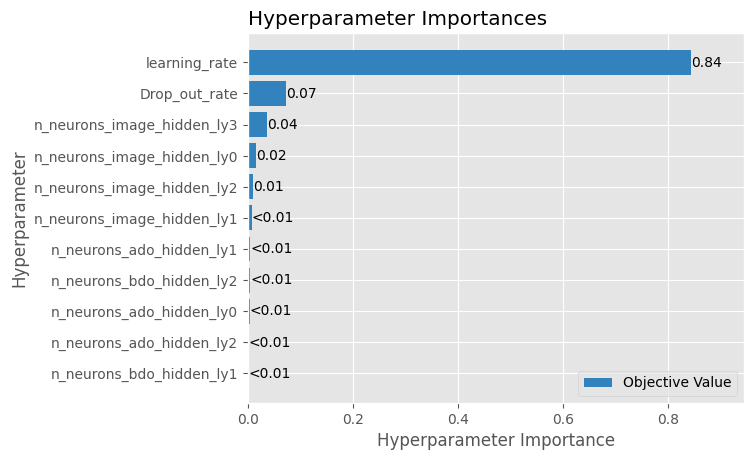

In [22]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.legend(loc = 'lower right')
#plt.savefig('figs/Optimized Models/10x10/Hyperparameter Importance.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Re-train the best Model Architecture with the weights initializer

In [24]:
best_model = create_OP_Model(best_trial, weights_hint = initial_pixel_weights)

history = best_model.fit(
    x = {'image_input': pixel_train_transf, 'energy_input': energy_train_transf, 'position_input': position_train_transf},
    y = {'nu_predict': labels_train},
    epochs = 200,
    batch_size = 1000,
    validation_data = ([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, min_delta=1e-3, monitor="val_loss")],
    shuffle = True
)

Epoch 1/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6617 - loss: 0.5798 - pr_auc: 0.7366 - roc_auc: 0.7306 - val_accuracy: 0.7528 - val_loss: 0.4838 - val_pr_auc: 0.8485 - val_roc_auc: 0.8416
Epoch 2/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7860 - loss: 0.4396 - pr_auc: 0.8744 - roc_auc: 0.8702 - val_accuracy: 0.7971 - val_loss: 0.4189 - val_pr_auc: 0.8884 - val_roc_auc: 0.8840
Epoch 3/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7904 - loss: 0.4302 - pr_auc: 0.8804 - roc_auc: 0.8762 - val_accuracy: 0.7984 - val_loss: 0.4158 - val_pr_auc: 0.8902 - val_roc_auc: 0.8858
Epoch 4/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7926 - loss: 0.4261 - pr_auc: 0.8831 - roc_auc: 0.8789 - val_accuracy: 0.7916 - val_loss: 0.4256 - val_pr_auc: 0.8846 - val_roc_auc: 0.8801
Epoch 5/200
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7939 - loss: 0.4234 - pr_auc: 0.8848 - roc_auc: 0.8806 - val_accuracy: 0.7978 - val_loss: 0.415

## Save The Best Model and History

In [89]:
save_model = False # General Save for every model!
save_dir = 'C:/Users/joanc/jupyter notebooks/solar neutrino analysis/Machine Learning/TensorFlow Frame/Sequential Models/models save/10x10/optimized models/pipeline_std_minmax/'
model_name = f'Seq_MLM1_E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns'
history_name = 'history_' + model_name

if save_model:
    #Save training History
    with open(save_dir + history_name + ".pkl", "wb") as f:
        pickle.dump(history, f)

    #Save the model
    best_model.save(save_dir + model_name + '.keras')

## Load the Model

In [90]:
load = True

if load:
    #Load the dictionary history
    with open(save_dir + history_name + ".pkl", "rb") as f:
        history = pickle.load(f)

    #Load the Model
    best_model = tf.keras.models.load_model(save_dir + model_name + '.keras', custom_objects={"gelu": tf.keras.activations.gelu})
    best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ imag_ly_0 (Dense)             │ (None, 94)                │           9,494 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ energy_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ position_input (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 96)                │               0 │ imag_ly_0[0][0],           │
│                               │                           │                 │ energy_input[0][0],        │
│                               │                           │                 │ position_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_0 (Dense)              │ (None, 29)                │           2,813 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_1 (Dense)              │ (None, 24)                │             720 │ bdo_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 24)                │               0 │ bdo_ly_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ado_ly_0 (Dense)              │ (None, 14)                │             350 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ nu_predict (Dense)            │ (None, 2)                 │              30 │ ado_ly_0[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 40,223 (157.12 KB)

 Trainable params: 13,407 (52.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,816 (104.75 KB)

In [92]:
for layer in best_model.layers:
    if "Dropout" in layer.__class__.__name__:
        print("Dropout rate:", layer.rate)

lr = best_model.optimizer.learning_rate.numpy()
print("Learning rate:", lr)

Dropout rate: 0.15821664782074943
Learning rate: 0.00041099256


In [44]:
history

# Plots

In [21]:
save_fig = False #Save figures

## Learning Curves

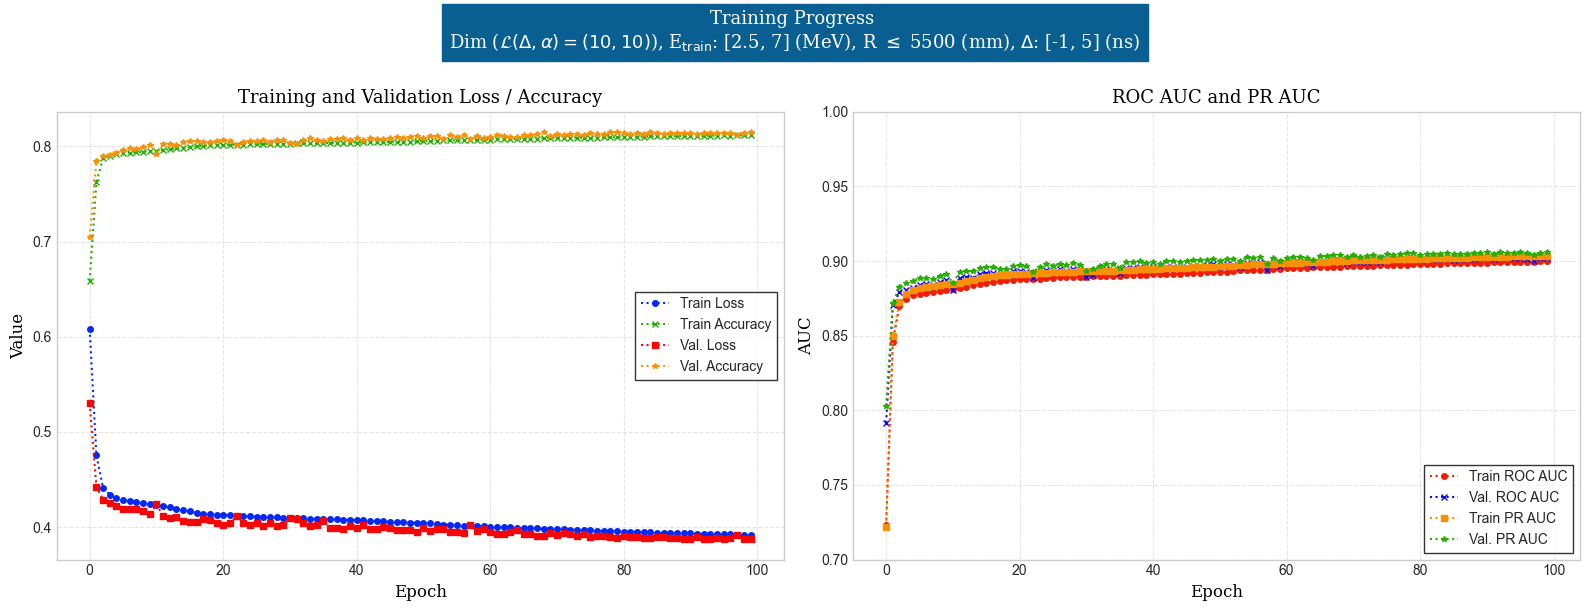

In [46]:
import matplotlib as mpl
# -------Save settings -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'training_curves_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Training Progress '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut_train}] (MeV), R $\leq$ {posr_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

plt.style.use('seaborn-v0_8-whitegrid')  # O prueba 'ggplot', 'seaborn-dark', etc.
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':13}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':12}

# Figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Loss & Accuracy ---
axes[0].plot(history.history['loss'], 'o:', color='#0528f2', label='Train Loss', linewidth=1.5, markersize=4)
axes[0].plot(history.history['accuracy'], 'x:', color='#27ad05', label='Train Accuracy', linewidth=1.5, markersize=4)
axes[0].plot(history.history['val_loss'], 's:', color='#f50505', label='Val. Loss', linewidth=1.5, markersize=4)
axes[0].plot(history.history['val_accuracy'], '*:', color='#fa9005', label='Val. Accuracy', linewidth=1.5, markersize=4)

axes[0].set_title('Training and Validation Loss / Accuracy', fontdict = font_style_title)
axes[0].set_xlabel('Epoch', fontdict = font_style_axis)
axes[0].set_ylabel('Value', fontdict = font_style_axis)
axes[0].legend(loc='center right', frameon=True, edgecolor='black', fancybox=False)
axes[0].grid(True, linestyle='--', alpha=0.5)

# axes[0].set_yscale('log')  # solo si realmente lo necesitas

# --- Plot 2: AUC ---
axes[1].plot(history.history['roc_auc'], 'o:', color='#f21d05', label='Train ROC AUC', linewidth=1.5, markersize=4)
axes[1].plot(history.history['val_roc_auc'], 'x:', color='#0d05f2', label='Val. ROC AUC', linewidth=1.5, markersize=4)
axes[1].plot(history.history['pr_auc'], 's:', color='#fa9005', label='Train PR AUC', linewidth=1.5, markersize=4)
axes[1].plot(history.history['val_pr_auc'], '*:', color='#27ad05', label='Val. PR AUC', linewidth=1.5, markersize=4)

axes[1].set_title('ROC AUC and PR AUC', fontdict = font_style_title)
axes[1].set_xlabel('Epoch', fontdict = font_style_axis)
axes[1].set_ylabel('AUC', fontdict = font_style_axis)
axes[1].set_ylim(0.7, 1)
axes[1].legend(loc='lower right', frameon=True, edgecolor='black', fancybox=False)
axes[1].grid(True, linestyle='--', alpha=0.5)

# axes[1].set_yscale('log')  # igual que arriba, solo si necesario

# Super título
fig.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=13, weight='normal', y=1.01)

fig.tight_layout()

# Save Plot
if save_fig:
    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
plt.show()

# Observation and Analysis of Predictions

## DNN Prediction

In [27]:
X_sig_pred = best_model.predict([pixel_test1_transf_sig, energy_test1_transf_sig, position_test1_transf_sig])
X_bkg_pred = best_model.predict([pixel_test1_transf_bkg, energy_test1_transf_bkg, position_test1_transf_bkg])

699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step


In [28]:
X_sig_pred

array([[1.0000000e+00, 8.2257416e-13],
       [7.8203106e-01, 2.2533545e-01],
       [9.9999464e-01, 5.6834924e-06],
       ...,
       [9.9999255e-01, 8.1251128e-06],
       [9.9530590e-01, 4.5923330e-03],
       [9.9999994e-01, 3.5084366e-08]], dtype=float32)

In [29]:
X_bkg_pred

array([[0.23620884, 0.7639656 ],
       [0.21224739, 0.7877705 ],
       [0.43259394, 0.56902635],
       ...,
       [0.03257973, 0.9677948 ],
       [0.4233282 , 0.576036  ],
       [0.63055754, 0.36887997]], dtype=float32)

In [30]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 22347 of signal and 22346 of background as testing data


## Representation of Predictions

### Distribution of Probabilities

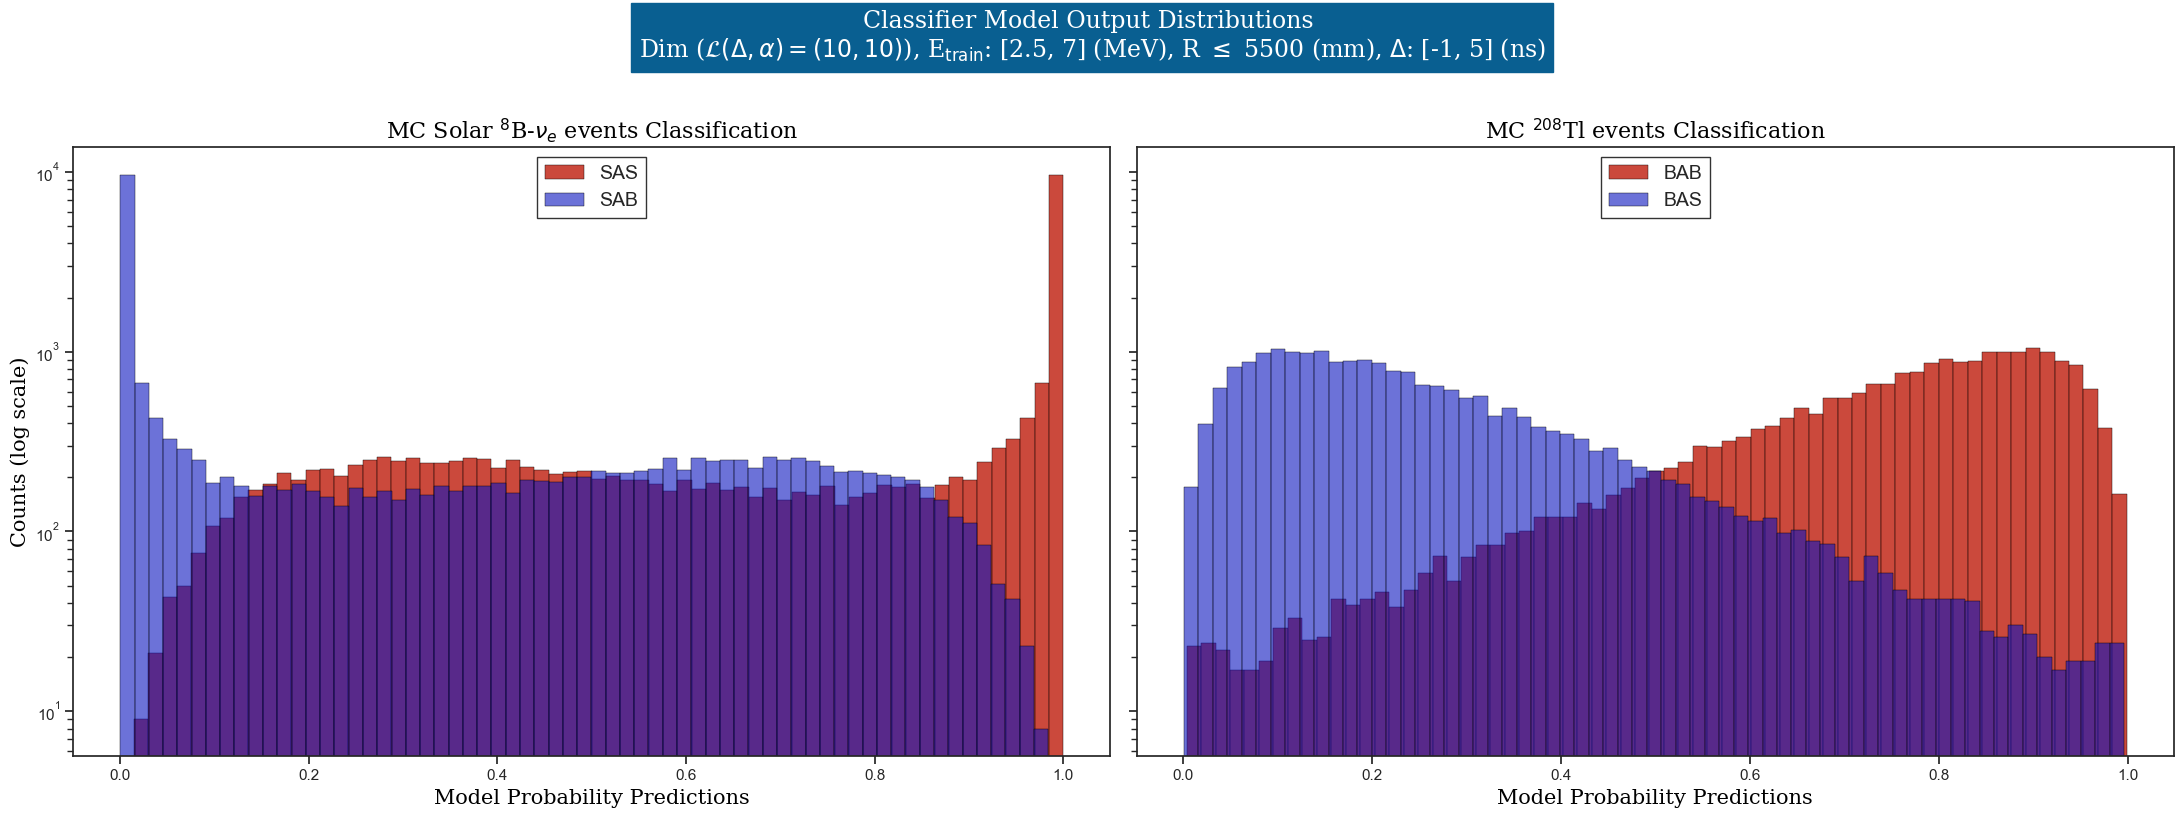

In [51]:
# ------- Save settings : -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'Classifier_Model_Output_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Classifier Model Output Distributions '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut_train}] (MeV), R $\leq$ {posr_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

sn.set_theme(style="ticks")  # o "ticks", "darkgrid", etc.
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':16}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':15}

bins = 65
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=True)

# Solar ν predictions
sn.histplot(X_sig_pred[:, 0], bins=bins, label='SAS', color='#bf1c0b',
             edgecolor='black', linewidth=0.3, alpha=0.8, ax=axes[0])
sn.histplot(X_sig_pred[:, 1], bins=bins, label='SAB', color='#0b14bf',
             edgecolor='black', linewidth=0.3, alpha=0.6, ax=axes[0])

# Background predictions
sn.histplot(X_bkg_pred[:, 1], bins=bins, label='BAB', color='#bf1c0b',
             edgecolor='black', linewidth=0.3, alpha=0.8, ax=axes[1])
sn.histplot(X_bkg_pred[:, 0], bins=bins, label='BAS', color='#0b14bf',
             edgecolor='black', linewidth=0.3, alpha=0.6, ax=axes[1])

# Titles and labels
axes[0].set_title('MC Solar $^8$B-$\\nu_e$ events Classification', fontdict = font_style_title)
axes[0].set_xlabel('Model Probability Predictions', fontdict = font_style_axis)
axes[0].set_ylabel('Counts (log scale)', fontdict = font_style_axis)
axes[0].legend(loc = 'best', frameon=True, edgecolor='black', fancybox=False, fontsize=14)
axes[0].set_yscale('log')

axes[1].set_title('MC $^{208}$Tl events Classification', fontdict = font_style_title)
axes[1].set_xlabel('Model Probability Predictions', fontdict = font_style_axis)
axes[1].set_ylabel('Counts (log scale)', fontdict = font_style_axis)
axes[1].legend(loc = 'upper center', frameon=True, edgecolor='black', fancybox=False, fontsize=14)
axes[1].set_yscale('log')

# General formatting
plt.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=17, weight='normal', y=1.02)

plt.tight_layout()
if save_fig:
    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC and PR Curves

In [54]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))              #Predicted
X_exp = np.concatenate((labels_test1_sig, labels_test1_bkg))     #Expected

# ====================== ROC Calculation ======================
fpr_sig, tpr_sig, _ = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

fpr_bkg, tpr_bkg, _ = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

fpr_all, tpr_all, _ = roc_curve(
    np.concatenate((X_exp[:,0], X_exp[:,1])),
    np.concatenate((X_pred[:,0], X_pred[:,1]))
)
auc_all = auc(fpr_all, tpr_all)

# ====================== PR Calculation ======================
prec_sig, rec_sig, _ = precision_recall_curve(X_exp[:,0], X_pred[:,0])
pr_auc_sig = auc(rec_sig, prec_sig)
N_positive = X_sig_pred.shape[0]
N_samples = X_sig_pred.shape[0] + X_bkg_pred.shape[0]
random_guess_line = N_positive/N_samples  #The random guess line is given by an horizontal line in the precision coordinate = (Nº of positive smaples)/(Nº of samples)

prec_bkg, rec_bkg, _ = precision_recall_curve(X_exp[:,1], X_pred[:,1])
pr_auc_bkg = auc(rec_bkg, prec_bkg)

prec_all, rec_all, _ = precision_recall_curve(
    np.concatenate((X_exp[:,0], X_exp[:,1])),
    np.concatenate((X_pred[:,0], X_pred[:,1]))
)
pr_auc_all = auc(rec_all, prec_all)

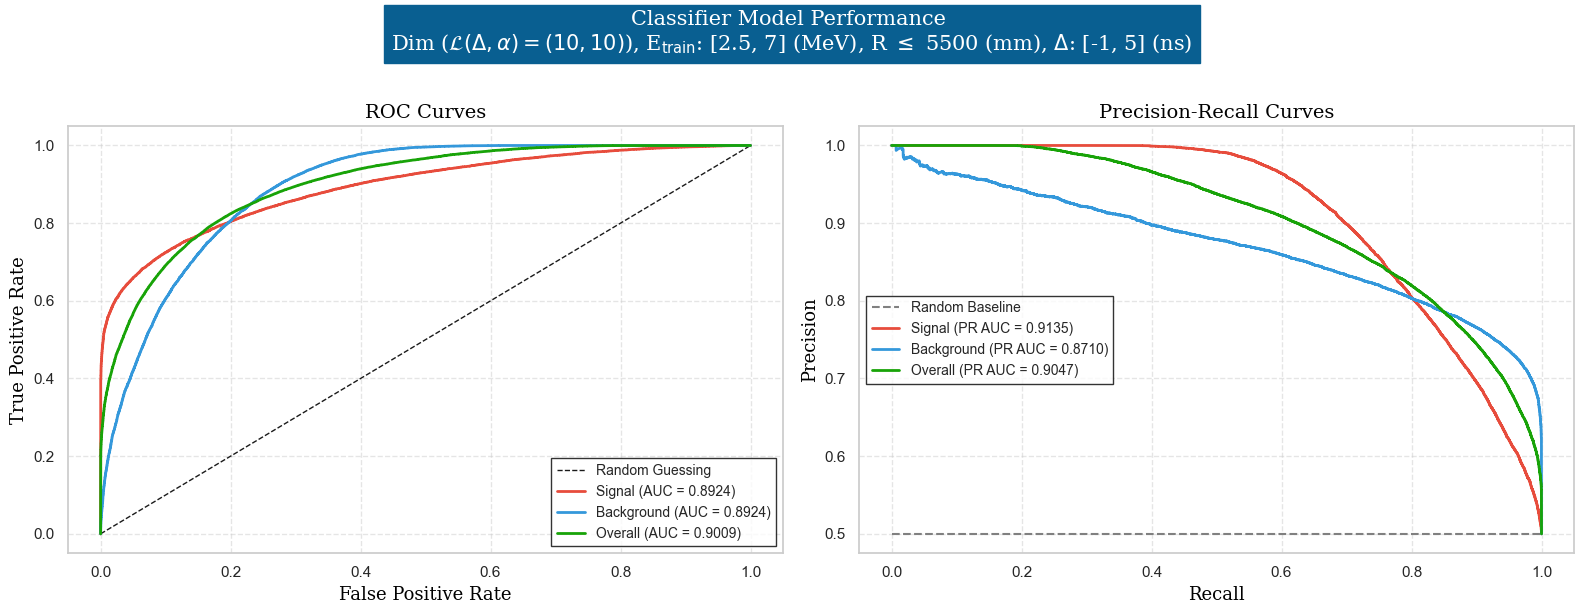

In [58]:
# ------- Save settings : -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'ROC_PR_'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Classifier Model Performance '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut_train}] (MeV), R $\leq$ {posr_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

sn.set_theme(style="whitegrid")
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':14}
font_style_axis  = {'family':'serif', 'weight': 'normal','color':'black','size':13}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---------- Subplot 1: ROC para sig, bkg y overall ----------
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guessing', linewidth=1)
axes[0].plot(fpr_sig, tpr_sig, color='#e74c3c', linewidth=2,
             label=f'Signal (AUC = {auc_sig:.4f})')
axes[0].plot(fpr_bkg, tpr_bkg, color='#3498db', linewidth=2,
             label=f'Background (AUC = {auc_bkg:.4f})')
axes[0].plot(fpr_all, tpr_all, color='#18a308', linewidth=2,
             label=f'Overall (AUC = {auc_all:.4f})')

axes[0].set_title('ROC Curves', fontdict=font_style_title)
axes[0].set_xlabel('False Positive Rate', fontdict=font_style_axis)
axes[0].set_ylabel('True Positive Rate', fontdict=font_style_axis)
axes[0].legend(loc='lower right', frameon=True, edgecolor='black', fancybox=False, fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# ---------- Subplot 2: Precision-Recall para sig, bkg y overall ----------
axes[1].hlines(random_guess_line, 0, 1, colors="gray", linestyles="--", label="Random Baseline")
axes[1].plot(rec_sig, prec_sig, color='#e74c3c', linewidth=2,
             label=f'Signal (PR AUC = {pr_auc_sig:.4f})')
axes[1].plot(rec_bkg, prec_bkg, color='#3498db', linewidth=2,
             label=f'Background (PR AUC = {pr_auc_bkg:.4f})')
axes[1].plot(rec_all, prec_all, color='#18a308', linewidth=2,
             label=f'Overall (PR AUC = {pr_auc_all:.4f})')

axes[1].set_title('Precision-Recall Curves', fontdict=font_style_title)
axes[1].set_xlabel('Recall', fontdict=font_style_axis)
axes[1].set_ylabel('Precision', fontdict=font_style_axis)
axes[1].legend(loc='center left', frameon=True, edgecolor='black', fancybox=False, fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

# --------- Título general ---------
fig.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=15, weight='normal', y=1.02)

plt.tight_layout()
if save_fig:
    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
plt.show()

###  Reconstrucción de espector de solar $ν_e$ y de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio (Inverse Standard Scaler) y Normalización en Volumen

In [31]:
energy_sig_rc = scaler_energy_test.inverse_transform([energy_test1_transf_sig])[0]
energy_bkg_rc = scaler_energy_test.inverse_transform([energy_test1_transf_bkg])[0]

# Volume Normalization + Std Scaler: la formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
#Recover from Transformation Rule
position_sig_rc = scaler_position_test.inverse_transform([position_test1_transf_sig])[0]
position_bkg_rc = scaler_position_test.inverse_transform([position_test1_transf_bkg])[0]

#Recover the radius values from the Volume
radi_sig_rc = np.cbrt(position_sig_rc*vol)
radi_bkg_rc = np.cbrt(position_bkg_rc*vol)

### Normalized Efficiency by N_Counts(true)

Construir un plot de eficicencia normalizada por el numero total de eventos en un bin del plot "Separated Spectrums for Threshold (trh)".
Procedimientos de construcción:

1) extraer valores de energia contenidos en cada bin de "Separated Spectrums for Threshold (trh)"
2) Contabilizar el nº de eventos que superan el treshold dentro del bin de energia, y dividir por el número de eventos contenido en el bin, esta será la eficiencia normalizado por N_events_true
3) Hacer plot de la eficiciencia normalizada en funcion del valor medio de las energias contenida en el bin (cuanto mas bins, mas puntos de eficiencia habra)

#### Graficos de Energia Reconstruida y de Eficiencia Normalizada para varios Threshold de Predicción del Modelo

##### Extraer Información para los Gráficos

In [32]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_nu = 15             #-> Define how many intervals in energy. Equals to the number of point of norm_eff. PREDEFINED BINS = 20
bins_tl = 8              #-> BINS = 8

thr = [0.90, 0.80, 0.70, 0.60]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]      #probiblity of the event of neutrino being detected as neutrino
#prob_bab = X_bkg_pred[:,1]      #probiblity of the event of thallium being detected as thallium
prob_bas = X_bkg_pred[:,0]      #probiblity of the event of thallium being detected as neutrino

en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins_nu)   #Extract interval of binned data
en_bkg_test_count, en_bkg_test_edge = np.histogram(energy_bkg_rc, bins = bins_tl)   #Extract interval of binned data

# Extract the binwidth - Expresion only valid for constant binning!
binwidth_en_sig = en_sig_test_edge[2] - en_sig_test_edge[1]  
binwidth_en_bkg = en_bkg_test_edge[2] - en_bkg_test_edge[1]


N_edges_sig = len(en_sig_test_edge)
N_edges_bkg = len(en_bkg_test_edge)

#Information to extract--------------------------------------
nu_energy_in_sas = []
#nu_energy_out_sas = []

tl_energy_in_bas = []
#tl_energy_out_bab = []

#mean normalized eficiency values for signal as signal and bkg as sig
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []

norm_eff_bkg = []

#mean energy within each bin for signal and bkg data
mean_energy_sig = []  
mean_energy_bkg = []   

for thr_i in thr: 

    #Information to save in each loop of threshold --------------
    nu_energy_in_sas_thr = []
    #nu_energy_out_sas_thr = []
    
    tl_energy_in_bas_thr = []
    #tl_energy_out_bas_thr = []

    #normalized eficiency values for signal and bkg for each thr
    #Used to contruct the norm eff plot
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])

    #mean energy within each bin for signal and bkg data for each thr (aunque acaba siendo el mismo valor medio para cado thr y para los histogramas que preservan el número de bins).
    #Used to contruct the norm eff plot
    mean_energy_sig_thr = np.array([]) 
    mean_energy_bkg_thr = np.array([]) 

    #mean radial values within each bin for signal and bkg data for each thr
    #Used to contruct the norm eff plot
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract info for Plot of energy > thr and energy < thr

    #Extract
    for i in np.where(prob_sas >= thr_i)[0]:
        nu_energy_in_sas_thr.append(energy_sig_rc[i])
        
    #for j in np.where(prob_sas < thr_i)[0]:
        #nu_energy_out_sas_thr.append(energy_sig_rc[j])
    
    for m in np.where(prob_bas >= thr_i)[0]:
        tl_energy_in_bas_thr.append(energy_bkg_rc[m])
    
    #for k in np.where(prob_bab < thr_i)[0]:
        #tl_energy_out_spectrum_thr.append(energy_bkg_rc[k])
        
    nu_energy_in_sas.append(np.array(nu_energy_in_sas_thr))
    #nu_energy_out_sas.append(np.array(nu_energy_out_sas_thr))
    tl_energy_in_bas.append(np.array(tl_energy_in_bas_thr))
    #tl_energy_out_bab.append(np.array(tl_energy_out_spectrum_thr))

    #Extract norm_eff and mean nu enery within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges_sig-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_sig_test_edge[i]
        energy_edge_f = en_sig_test_edge[i+1]
    
        #find energy in energy_test_sig between edges values and the model prediction for SAS 
        energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), energy_sig_rc)
        prob_sas_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), prob_sas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_sig_thr = np.append(mean_energy_sig_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_energy_sig.append(mean_energy_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges_bkg-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_bkg_test_edge[i]
        energy_edge_f = en_bkg_test_edge[i+1]
    
        #find energy in energy_test_bkg between edges values and the model prediction for BAS
        energy_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), energy_bkg_rc)
        prob_bas_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), prob_bas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_bkg_thr = np.append(mean_energy_bkg_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_energy_bkg.append(mean_energy_bkg_thr)

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_energy_sig = np.array(mean_energy_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_energy_bkg = np.array(mean_energy_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

In [33]:
norm_eff_sig_in_sas

array([[8.89899473e-01, 1.22815534e-01, 5.34188034e-04, 5.54016620e-04,
        4.65928946e-03, 1.42180095e-02, 1.63862928e-01, 8.02807487e-01,
        9.98569385e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.69363332e-01, 3.14077670e-01, 1.65598291e-02, 7.20221607e-03,
        1.57251019e-02, 6.57582938e-02, 3.55140187e-01, 9.27807487e-01,
        9.99284692e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.87075156e-01, 5.06796117e-01, 5.71581197e-02, 2.82548476e-02,
        4.77577169e-02, 1.51658768e-01, 5.38317757e-01, 9.68582888e-01,
        9.99284692e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.96170416e-01, 6.72330097e-01, 1.45833333e-01, 5.92797784e-02,
        1.07163658e-01, 2.70142180e-01, 6.73520249e-01, 9.89973262e-01,
        1.00000000e+00, 1.00000000e+0

#### Construir los Gráficos

- Energia

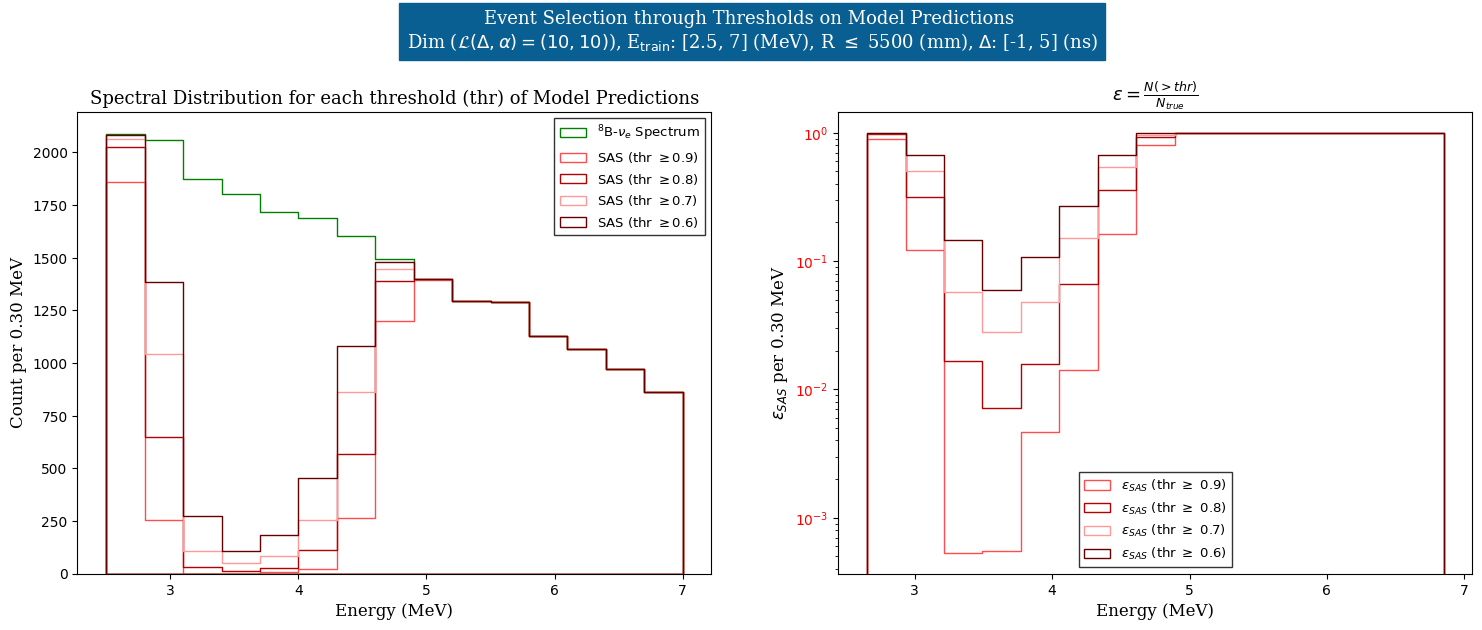

In [38]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sn.reset_orig

# ------- Save settings : -------
save_dir = 'figs/Optimized Models/10x10/pipeline_std_minmax/'
fname = 'classified_ev_energy_per_and_eff_per_thr'
pattern_train_save_name = f'E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_({time_res_inf_cut}_{time_res_sup_cut})_ns'

# ------- Superior Title -------
main_title = 'Event Selection through Thresholds on Model Predictions '
train_cut_title = rf'Dim ($\mathcal{{L}}(\Delta, \alpha) = (10,10)$), E$_\text{{train}}$: [{energy_inf_cut}, {energy_cut_train}] (MeV), R $\leq$ {posr_cut} (mm), $\Delta$: [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'
full_title = main_title + '\n' + train_cut_title

# ------- Font Styles -------
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':13}
font_style_axis  = {'family':'serif', 'weight': 'normal','color':'black','size':12}

bas_on = False
alpha = 0

#main plot: Test Solar Energy
fig, axes = plt.subplots(1,2, figsize =(18, 6)) 

sn.histplot(energy_sig_rc, ax = axes[0], bins = bins_nu, color = 'g' , label = r'$^8$B-$ν_e$ Spectrum', alpha = alpha, element = 'step')

for i_dx, thr_i in enumerate(thr):  
    #Sig Spectral distribution
    sn.histplot(nu_energy_in_sas[i_dx], ax = axes[0], bins = bins_nu, color = red_variants[i_dx] , label = r'SAS (thr $\geq$'+str(thr_i)+')', 
                alpha = alpha, element = 'step')

    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_energy_sig[i_dx], ax = axes[1], bins=len(mean_energy_sig[i_dx]), color = red_variants[i_dx], 
                weights=norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$ (thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg spectra
        sn.histplot(tl_energy_in_bas[i_dx], ax = axes[0], bins = bins_tl, color = blue_variants[i_dx] , label = r'BAS (thr $\geq$'+str(thr_i)+')', 
                    alpha = alpha, element = 'step')

        #bkg efficiency
        ax1_1 = axes[1].twinx()  #Right axis for the norm_eff plot due to differences between eff scales
        sn.histplot(x = mean_energy_bkg[i_dx], ax = ax1_1, bins=len(mean_energy_bkg[i_dx]), color = blue_variants[i_dx], 
                    weights=norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$ (thr $\geq$ '+str(thr_i)+')')

        ax1_1.legend(loc = 'upper right')
        ax1_1.set_ylabel(r'$\epsilon_{BAS}$', fontdict=font_style_axis)
        ax1_1.tick_params(axis='y', labelcolor='b')
        

axes[0].set_title(r'Spectral Distribution for each threshold (thr) of Model Predictions', fontdict=font_style_title)
axes[0].set_xlabel('Energy (MeV)', fontdict=font_style_axis)
axes[0].set_ylabel(f'Count per {binwidth_en_sig:.2f} MeV', fontdict=font_style_axis)
axes[0].legend(loc = 'upper right', frameon=True, edgecolor='black', fancybox=False, fontsize=9.5)
#axes[0].set_yscale('log')

axes[1].set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontdict=font_style_title)
axes[1].set_xlabel('Energy (MeV)', fontdict=font_style_axis)
axes[1].set_ylabel(rf'$\epsilon_{{SAS}}$ per {binwidth_en_sig:.2f} MeV', fontdict=font_style_axis)
axes[1].legend(loc = 'lower center', frameon=True, edgecolor='black', fancybox=False, fontsize=9.5)
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].set_yscale('log')

plt.suptitle(full_title, backgroundcolor='#095f91', family = 'serif', color='white', fontsize=13, weight='normal', y=1.05)

if save_fig:
    fig.savefig(save_dir + fname + pattern_train_save_name + '.png', dpi=300, bbox_inches='tight')
    
plt.show()

In [113]:
# Mean eficiency calculation in [2.5,10] for each thr in SAS

mean_eff = []  # List with the values of the mean efficicency for each threshold in energy within a range [2.5,10] MeV
eff_error = [] # list with the error value associated to hte mean_eff by the maximum desviation.
results = []   # List with explicit result of the thr and mean value of efficiency

for i_dx, thr_i in enumerate(thr):

    eff_sas_thr = norm_eff_sig_in_sas[i_dx]
    energy_sas_thr = mean_energy_sig[i_dx]
    
    #Extract the values of efficiency which verifies the energy cut
    condition = (energy_sas_thr <= 10)
    eff_sas_filter = np.extract(condition, eff_sas_thr)

    #Obtain mean value as the mean percentage of events in thr which are truly solar nu
    mean_eff_sas_thr = np.mean(eff_sas_filter, dtype = np.float16)
    mean_eff.append(mean_eff_sas_thr)

    #Compute the eff error by the maximum deviation of the samples from the mean value
    deviations = abs(eff_sas_thr -  mean_eff_sas_thr)
    max_deviation = np.max(deviations)
    eff_error.append(max_deviation)

    result_thr = 'For thr='+str(thr_i) + r', the eff for SAS is = ' + str(mean_eff_sas_thr) + ' with an error of ' + str(max_deviation)
    results.append(result_thr)

In [78]:
mean_eff

[0.599, 0.6406, 0.678, 0.7183]

In [79]:
eff_error

[0.5985577134683099,
 0.6358453929899097,
 0.6612284979919012,
 0.6715277835402284]

In [80]:
results

['For thr=0.9, the eff for SAS is = 0.599 with an error of 0.5985577134683099',
 'For thr=0.8, the eff for SAS is = 0.6406 with an error of 0.6358453929899097',
 'For thr=0.7, the eff for SAS is = 0.678 with an error of 0.6612284979919012',
 'For thr=0.6, the eff for SAS is = 0.7183 with an error of 0.6715277835402284']

- Radius

In [81]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_rad = 20            #-> BINS = 20
thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]
prob_bas = X_bkg_pred[:,0]

rad_sig_test_count, rad_sig_test_edge = np.histogram(radi_sig_rc, bins = bins_rad)
rad_bkg_test_count, rad_bkg_test_edge = np.histogram(radi_bkg_rc, bins = bins_rad)

N_edges= len(rad_sig_test_edge)

#mean normalized eficiency values for signal and bkg
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []  

#mean radial values within each bin for signal and bkg data
mean_rad_sig = []
mean_rad_bkg = []

for thr_i in thr: 

    #mean normalized eficiency values for signal and bkg for each thr
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])
    
    #mean radial values within each bin for signal and bkg data for each thr
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract norm_eff and mean radius within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges-1):
        #extract edges value of energy at each bin
        radi_edge_i = rad_sig_test_edge[i]
        radi_edge_f = rad_sig_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), radi_sig_rc)
        prob_sas_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), prob_sas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_sig_thr = np.append(mean_rad_sig_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_rad_sig.append(mean_rad_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges-1):
        #extract edges value of radius at each bin
        radi_edge_i = rad_bkg_test_edge[i]
        radi_edge_f = rad_bkg_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), radi_bkg_rc)
        prob_bas_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), prob_bas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_bkg_thr = np.append(mean_rad_bkg_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract value of normalized efficiency for each bin
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_rad_bkg.append(mean_rad_bkg_thr)
    

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_rad_sig = np.array(mean_rad_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_rad_bkg = np.array(mean_rad_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

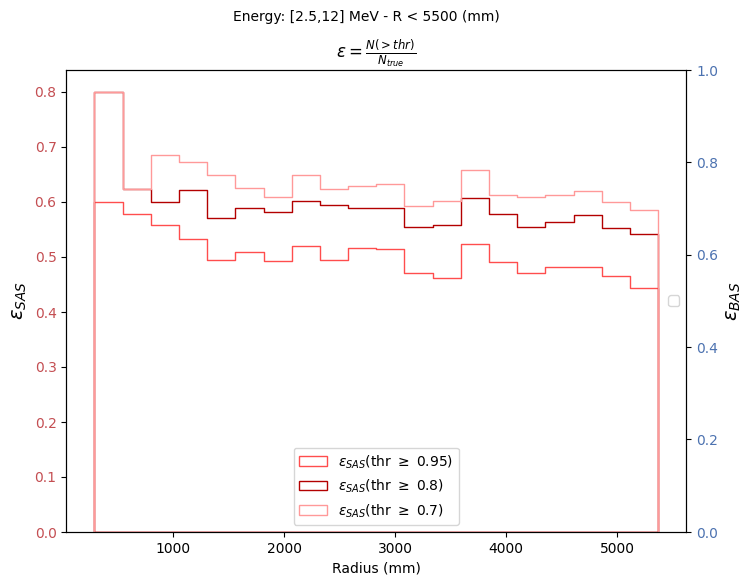

In [82]:
bas_on = False

#main plot: Test Solar radius vs. Normalized efficiency
fig, axes_1 = plt.subplots(figsize =(8, 6))
axes_2 = axes_1.twinx()

for i_dx, thr_i in enumerate(thr):  
    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_rad_sig[i_dx], ax = axes_1,bins = len(mean_rad_sig[i_dx]), color = red_variants[i_dx], 
                weights = norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$(thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg efficiency
        sn.histplot(x = mean_rad_bkg[i_dx], ax = axes_2, bins=len(mean_rad_bkg[i_dx]), color = blue_variants[i_dx], kde=False,
                    weights = norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$(thr $\geq$ '+str(thr_i)+')')
        

plt.suptitle('Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 10)
axes_1.set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes_1.legend(loc = 'lower center')
axes_2.legend(loc = 'center right')

axes_1.tick_params(axis='y', labelcolor='r')
axes_2.tick_params(axis='y', labelcolor='b')


axes_1.set_xlabel('Radius (mm)')
axes_1.set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
axes_2.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

#axes_1.set_xlim(0, 5500.0)
#axes_2.set_ylim(0, np.max(norm_eff_bkg_in_bas) + 0.15)
#axes_1.set_yscale('log')

#if bas_on:
#    plt.savefig('figs/Optimized Models/10x10/Radial_sig_bkg_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
#else:
#    plt.savefig('figs/Optimized Models/10x10/Radial_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()